# Plan
- Include VQSLOD in gatk callset
- 3 (FPhom, FPhet, FPall) VQSLOD ROC (FDR vs sensitivity) for coding/variant_type (4 lines) across all samples
- 12 VQSLOD ROCs with line for each sample
- Does VQSLOD threshold 0 look sane?
- Function to create table for given VQSLOD, GQ and samples
- Create table for VQSLOD >= 0, GQ >= 0
- Create table for VQSLOD >= 6, GQ >= 0
- Create table for VQSLOD >= 6, GQ >= 0, 100bp samples
- Create table for VQSLOD >= 6, GQ >= 30
- Create table for VQSLOD >= 6, GQ >= 99
- Function to create table split into multi-allelics

- Calculate FDR/sensitivity

- Calculate crosses variables
    - Create separate vcfs for each cross with segregating variants only
    - For each variant in each cross, calculate
        - sum across progeny of Mendelian errors, homozygous calls (include both parents)
        - sum across duplicate pairs of homozygous calls, homozygous differences, called, any called difference
        - sum across all samples of called, missing and heterozygous
    - Create sums across all crosses of all the above
    - Calculate variables
        - Missingness (crosses) = sum(missing) / (sum(missing) + sum(called))
        - Heterozygosity (crosses) = sum(heterozygous) / (sum(called))
        - MER = sum(Mendelian errors) / sum(homozygous calls)
        - Discordance (hom) = sum(hom differences) / sum(homozygous calls)
        - Discordance (all) = sum(any called difference) / sum(called)
    

In [1]:
%run _standard_imports.ipynb
%run _shared_setup.ipynb
%run _plotting_setup.ipynb

import pandas as pd


python 3.4.5 |Anaconda 2.2.0 (64-bit)| (default, Jul  2 2016, 17:47:47) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy 1.11.1
scipy 0.18.0
pandas 0.19.0
numexpr 2.6.1
pysam 0.9.1.4
pysamstats 0.24.3
petl 1.1.0
petlx 1.0.3
vcf 0.6.8
vcfnp 2.3.0.dev0
h5py 2.4.0
tables 3.1.1


In [2]:
release5_final_files_dir = '/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0'
# chrom_vcf_fn = "%s/SNP_INDEL_Pf3D7_14_v3.combined.filtered.vcf.gz" % (release5_final_files_dir)
wg_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.vcf.gz" % (release5_final_files_dir)
crosses_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.crosses.vcf.gz" % (release5_final_files_dir)
sites_only_vcf_fn = "%s/SNP_INDEL_WG.combined.filtered.sites.vcf.gz" % (release5_final_files_dir)
pacbio_vcf_fn = "/nfs/team112_internal/rp7/data/pf3k/pacbio_3/vcf/pf3k_pacbio_3.vcf.gz" # See 20161012_pf3k_pacbio_3_setup.ipynb

output_dir = "/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary"
!mkdir -p {output_dir}/vcf
!mkdir -p {output_dir}/figures
!mkdir -p {output_dir}/tables

fdr_vcf_fn = "%s/vcf/SNP_INDEL_WG.combined.filtered.fdr.vcf.gz" % output_dir
sites_annotation_vcf_fn = "%s/vcf/SNP_INDEL_WG.combined.filtered.annotation.vcf.gz" % output_dir
pacbio_fdr_vcf_fn = "%s/vcf/pf3k_pacbio_3.fdr.vcf.gz" % output_dir
release5_crosses_metadata_txt_fn = '../../meta/pf3k_release_5_crosses_metadata.txt'
release5_mixtures_metadata_txt_fn = '../../meta/pf3k_release_5_mixtures_metadata.txt'
gff_fn = "%s/Pfalciparum.noseq.gff3.gz" % output_dir
cds_gff_fn = "%s/Pfalciparum.noseq.gff3.cds.gz" % output_dir
core_bed_fn = '/nfs/users/nfs_r/rp7/temp_github_src/pf-crosses/meta/regions-20130115.Conserved.bed'

summary_table_fn = "%s/callset_summary.xlsx" % output_dir
# simplifed_counts_table_fn = "%s/simplified_variant_counts.xlsx" % output_dir

GENOME_FN = "/lustre/scratch109/malaria/pf3k_methods/resources/Pfalciparum.genome.fasta"

BCFTOOLS = '/nfs/team112_internal/rp7/src/github/malariagen/methods-dev/pf3k_techbm/opt_4/bcftools/bcftools'
GATK = '/software/jre1.8.0_74/bin/java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.6/GenomeAnalysisTK.jar'
# GATK = '/software/jre1.7.0_25/bin/java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar'

In [3]:
wg_vcf_fn

'/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_WG.combined.filtered.vcf.gz'

In [4]:
pacbio_vcf_reader = vcf.Reader(filename=pacbio_vcf_fn)
pacbio_samples = np.array(pacbio_vcf_reader.samples)
pacbio_samples

array(['Pf7G8', 'PfGB4', 'PfGN01', 'PfKE01', 'PfKH02'], 
      dtype='<U6')

In [5]:
fdr_samples = collections.OrderedDict()
fdr_samples['Pf7G8'] = '7G8' # This is 76bp crosses parent
fdr_samples['PfGB4'] = 'GB4' # This is 76bp crosses parent
fdr_samples['PfGN01'] = 'ERS740940' # This is 100bp version created from 250bp MiSeq data
fdr_samples['PfKE01'] = 'ERS740937' # This is 100bp version created from 250bp MiSeq data
# fdr_samples['PfKH02'] = 'PH0197-C' # This is 76bp originally sequenced sample. There is also 100bp version created from 250bp MiSeq data (ERS740936)
fdr_samples['PfKH02'] = 'ERS740936' # This is 100bp version created from 250bp MiSeq data, There is also 76bp originally sequenced sample (PH0197-C)

In [6]:
fdr_samples_text = ','.join(list(fdr_samples.values()))
fdr_samples_text

'7G8,GB4,ERS740940,ERS740937,ERS740936'

In [7]:
annotations_header_fn = "%s/vcf/annotations.hdr" % (output_dir)
fo=open(annotations_header_fn, 'w')
print('##INFO=<ID=CDS,Number=0,Type=Flag,Description="Is position coding">', file=fo)
print('##INFO=<ID=VARIANT_TYPE,Number=1,Type=String,Description="SNP or indel (IND)">', file=fo)
print('##INFO=<ID=MULTIALLELIC,Number=1,Type=String,Description="Is position biallelic (BI), biallelic plus spanning deletion (SD) or truly multiallelic (MU)">', file=fo)
fo.close()

In [8]:
tbl_release5_crosses_metadata = etl.fromtsv(release5_crosses_metadata_txt_fn)
print(len(tbl_release5_crosses_metadata.data()))
tbl_release5_crosses_metadata

98


sample,acc,study,study_title,clone,parent_or_progeny
PG0008-CW,ERS010540,1041,HB3xDD2 cross progeny,DD2,parent
PG0004-CW,ERS010539,1041,HB3xDD2 cross progeny,HB3,parent
PG0023-C,"ERS010581,ERS010543",1041,HB3xDD2 cross progeny,1BB5,progeny
PG0022-Cx,ERS088714,1041,HB3xDD2 cross progeny,3BA6,progeny
PG0024-C,ERS010150,1041,HB3xDD2 cross progeny,3BD5,progeny


In [9]:
crosses = tbl_release5_crosses_metadata.distinct('study_title').values('study_title').array()
crosses

array(['3D7xHB3 cross progeny', '7G8xGB4 cross progeny',
       'HB3xDD2 cross progeny'], 
      dtype='<U21')

In [10]:
','.join(tbl_release5_crosses_metadata.selecteq('study_title', '3D7xHB3 cross progeny').values('sample').array())

'PG0051-C,PG0052-C,PG0062-C,PG0065-C,PG0053-C,PG0055-C,PG0056-C,PG0067-C,PG0066-C,PG0061-C,PG0068-C,PG0069-C,PG0070-C,PG0071-C,PG0072-C,PG0063-C,PG0064-C,PG0058-C,PG0054-C,PG0060-C,PG0057-C'

In [10]:
crosses_samples_text_dict = collections.OrderedDict()
for cross in crosses:
    crosses_samples_text_dict[cross] = ','.join(
        tbl_release5_crosses_metadata.selecteq('study_title', cross).values('sample').array()
    )

In [11]:
replicates_first = [
 'PG0112-C',
 'PG0062-C',
 'PG0053-C',
 'PG0053-C',
 'PG0053-C',
 'PG0055-C',
 'PG0055-C',
 'PG0056-C',
 'PG0004-CW',
 'PG0111-C',
 'PG0100-C',
 'PG0079-C',
 'PG0104-C',
 'PG0086-C',
 'PG0095-C',
 'PG0078-C',
 'PG0105-C',
 'PG0102-C']

replicates_second = [
 'PG0112-CW',
 'PG0065-C',
 'PG0055-C',
 'PG0056-C',
 'PG0067-C',
 'PG0056-C',
 'PG0067-C',
 'PG0067-C',
 'PG0052-C',
 'PG0111-CW',
 'PG0100-CW',
 'PG0079-CW',
 'PG0104-CW',
 'PG0086-CW',
 'PG0095-CW',
 'PG0078-CW',
 'PG0105-CW',
 'PG0102-CW']

# Create annotations

In [8]:
def create_multiallelics_file(input_vcf_fn=sites_only_vcf_fn, multiallelics_fn=None):
    if multiallelics_fn is None:
        multiallelics_fn = "%s/vcf/SNP_INDEL_WG.sites.multiallelics.txt" % (output_dir)
    fo = open(multiallelics_fn, 'w')
    input_vcf_reader = vcf.Reader(filename=input_vcf_fn)
#     for record in input_vcf_reader.fetch('Pf3D7_01_v3', 29000, 29100):
    for record in input_vcf_reader:
        if len(record.ALT) == 1:
            multiallelic = 'BI'
        elif len(record.ALT) == 2 and (record.ALT[0] == '*' or record.ALT[1] == '*'):
            multiallelic = 'SD'
        else:
            multiallelic = 'MU'
#         print(multiallelic, record.ALT)
        print("%s\t%s\t%s\t%s\t%s" % (
                record.CHROM,
                record.POS,
                record.REF,
                ",".join([str(x) for x in record.ALT]),
                multiallelic), file=fo)
    fo.close()
    
    !bgzip {multiallelics_fn} && tabix -s1 -b2 -e2 {multiallelics_fn}.gz

In [85]:
temp = create_multiallelics_file()
temp

# Note on STRs
I attempted to separate STRs from non-STRs here, but came to the conclusion that it is difficult getting a clear definition of an STR. Many non-coding regions that have multiple indels not annotated as STRs by GATK, nonetheless look very much like STR regions, e.g. mostly AT repeats but with occasional AA, AAA, TTT, etc.

In [61]:
def create_annotation_file(input_vcf_fn=sites_only_vcf_fn, annotation_fn=None, BCFTOOLS=BCFTOOLS, GATK=GATK,
                           rewrite=False):
    if annotation_fn is None:
        annotation_fn = "%s/vcf/SNP_INDEL_WG.sites.annotation.txt.gz" % (output_dir)

    intermediate_fns = collections.OrderedDict()
    for intermediate_file in ['snp', 'indel', 'multiallelics']:
        intermediate_fns[intermediate_file] = annotation_fn.replace('annotation', intermediate_file)
    indels_vcf_fn = intermediate_fns['indel'].replace('txt.gz', 'vcf.gz')
    tra_vcf_fn = indels_vcf_fn.replace('indel', 'TRA')

    if rewrite or not os.path.exists(indels_vcf_fn):
        !{BCFTOOLS} view --include 'TYPE!="snp"' {input_vcf_fn} | \
        {BCFTOOLS} norm -m -any --fasta-ref {GENOME_FN} -Oz -o {indels_vcf_fn}
        !{BCFTOOLS} index --tbi {indels_vcf_fn}

    if rewrite or not os.path.exists(tra_vcf_fn):
        !{GATK} \
            -T VariantAnnotator \
            -R {GENOME_FN} \
            -o /dev/stdout \
            -A TandemRepeatAnnotator \
            -V {indels_vcf_fn} | \
        {BCFTOOLS} norm -m +any --fasta-ref {GENOME_FN} -Oz -o {tra_vcf_fn}
        !{BCFTOOLS} index --tbi {tra_vcf_fn}

    if rewrite or not os.path.exists(intermediate_fns['snp']):
        !{BCFTOOLS} query -f'%CHROM\t%POS\t%REF\t%ALT\tSNP\n' --include 'TYPE="snp"' {input_vcf_fn} | \
        bgzip -c > {intermediate_fns['snp']} && tabix -s1 -b2 -e2 -f {intermediate_fns['snp']}

    if rewrite or not os.path.exists(intermediate_fns['indel']):
        !{BCFTOOLS} query -f'%CHROM\t%POS\t%REF\t%ALT\tINDEL\n' --include 'TYPE!="snp"' {input_vcf_fn} | \
        bgzip -c > {intermediate_fns['indel']} && tabix -s1 -b2 -e2 -f {intermediate_fns['indel']}

    if rewrite or not os.path.exists(intermediate_fns['multiallelics']):
        create_multiallelics_file(input_vcf_fn, annotation_fn)
#         create_multiallelics_file(input_vcf_fn, "%s/vcf/pf3k_pacbio_3.multiallelics.txt" % (output_dir))
        
    if rewrite or not os.path.exists(annotation_fn):
        !{BCFTOOLS} annotate -a {cds_gff_fn} -c CHROM,FROM,TO,CDS -h {annotations_header_fn} {input_vcf_fn} | \
        {BCFTOOLS} annotate -a {intermediate_fns['snp']} -c CHROM,POS,REF,ALT,INFO/VARIANT_TYPE | \
        {BCFTOOLS} annotate -a {intermediate_fns['indel']} -c CHROM,POS,REF,ALT,INFO/VARIANT_TYPE | \
        {BCFTOOLS} annotate -a {intermediate_fns['multiallelics']} -c CHROM,POS,REF,ALT,INFO/MULTIALLELIC | \
        {BCFTOOLS} query -f'%CHROM\t%POS\t%REF\t%ALT\t%CDS\t%VARIANT_TYPE\t%MULTIALLELIC\n' | \
        bgzip -c > {annotation_fn}
        !tabix -s1 -b2 -e2 {annotation_fn}
      

In [62]:
create_annotation_file()

Lines   total/split/realigned/skipped:	1650575/1387397/2226778/0
INFO  15:12:29,539 HelpFormatter - -------------------------------------------------------------------------------- 
INFO  15:12:29,545 HelpFormatter - The Genome Analysis Toolkit (GATK) v3.6-0-g89b7209, Compiled 2016/06/01 22:27:29 
INFO  15:12:29,547 HelpFormatter - Copyright (c) 2010-2016 The Broad Institute 
INFO  15:12:29,547 HelpFormatter - For support and documentation go to https://www.broadinstitute.org/gatk 
INFO  15:12:29,547 HelpFormatter - [Tue Oct 25 15:12:29 BST 2016] Executing on Linux 3.2.0-75-generic amd64 
INFO  15:12:29,548 HelpFormatter - Java HotSpot(TM) 64-Bit Server VM 1.8.0_74-b02 JdkDeflater 
INFO  15:12:29,555 HelpFormatter - Program Args: -T VariantAnnotator -R /lustre/scratch109/malaria/pf3k_methods/resources/Pfalciparum.genome.fasta -o /dev/stdout -A TandemRepeatAnnotator -V /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.indel.vcf.gz 
INFO 

In [13]:
create_annotation_file(pacbio_vcf_fn, "%s/vcf/pf3k_pacbio_3.annotation.txt.gz" % (output_dir))

In [12]:
!zgrep SNP /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
!zgrep INDEL /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep SNP SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep INDEL SNP_INDEL_WG.sites.annotation.txt.gz | wc -l

2561890+1650575

2561890
1650575


4212465

In [90]:
# Here sanity checking that:
# a) Multi-allelic annotations are added 1-1
# b) Every position has a multi-allelic annotation

!zgrep MU /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
!zgrep BI /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
!zgrep SD /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.annotation.txt.gz | wc -l

!zgrep MU /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.multiallelics.txt.gz | wc -l
!zgrep BI /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.multiallelics.txt.gz | wc -l
!zgrep SD /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.sites.multiallelics.txt.gz | wc -l

# zgrep MU SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep BI SNP_INDEL_WG.sites.annotation.txt.gz | wc -l
# zgrep SD SNP_INDEL_WG.sites.annotation.txt.gz | wc -l

# 1180582+2118683+913200
1267853+2116676+827936

1267853
2116676
827936
1267853
2116676
827936


4212465

In [623]:
# Create VCF to be used for variant counts
# This takes ~10 mins

annotation_fn = "%s/vcf/SNP_INDEL_WG.sites.annotation.txt.gz" % (output_dir)

# !{BCFTOOLS} view --regions Pf3D7_01_v3:29000-30000 --min-ac 1 -s {fdr_samples_text} {wg_vcf_fn} | \
# !{BCFTOOLS} view {sites_only_vcf_fn} | \
!{BCFTOOLS} norm -m -any --fasta-ref {GENOME_FN} {sites_only_vcf_fn}| \
{BCFTOOLS} view --include 'ALT!="*"' | \
{BCFTOOLS} annotate -h {annotations_header_fn} \
-a {annotation_fn} -c CHROM,POS,REF,ALT,CDS,VARIANT_TYPE,MULTIALLELIC \
--include 'INFO/AC>0' \
--remove ^INFO/AC,INFO/AN,INFO/AF,INFO/VQSLOD,^FORMAT/GT,FORMAT/AD,FORMAT/GQ -Oz -o {sites_annotation_vcf_fn}

!{BCFTOOLS} index --tbi {sites_annotation_vcf_fn}

Lines   total/split/realigned/skipped:	4212465/2095789/2226778/0


In [91]:
# Create VCF to be used for FDR calculations
# This command is slow (~1.5 hours)

annotation_fn = "%s/vcf/SNP_INDEL_WG.sites.annotation.txt.gz" % (output_dir)

# !{BCFTOOLS} view --regions Pf3D7_01_v3:29000-30000 --min-ac 1 -s {fdr_samples_text} {wg_vcf_fn} | \
!{BCFTOOLS} view --regions-file {core_bed_fn} --min-ac 1 -s {fdr_samples_text} {wg_vcf_fn} | \
{BCFTOOLS} norm -m -any --fasta-ref {GENOME_FN} | \
{BCFTOOLS} view --include 'ALT!="*"' | \
{BCFTOOLS} annotate -h {annotations_header_fn} \
-a {annotation_fn} -c CHROM,POS,REF,ALT,CDS,VARIANT_TYPE,MULTIALLELIC \
--include 'INFO/AC>0' \
--remove ^INFO/AC,INFO/AN,INFO/AF,INFO/VQSLOD,^FORMAT/GT,FORMAT/AD,FORMAT/GQ -Oz -o {fdr_vcf_fn}

!{BCFTOOLS} index --tbi {fdr_vcf_fn}

Lines   total/split/realigned/skipped:	283133/253218/339064/0


In [44]:
# Create VCF to be used for crosses calculations (Mendelian error and duplicate discordance)
# This takes ~15 mins

annotation_fn = "%s/vcf/SNP_INDEL_WG.sites.annotation.txt.gz" % (output_dir)

# !{BCFTOOLS} view --regions Pf3D7_01_v3:29000-30000 --min-ac 1 -s {fdr_samples_text} {wg_vcf_fn} | \
for cross in crosses:
    cross_vcf_fn = "%s/vcf/SNP_INDEL_WG.combined.filtered.%s.vcf.gz" % (output_dir, cross)
    print(cross_vcf_fn)
    
    !{BCFTOOLS} view --regions-file {core_bed_fn} --min-ac 1 -s {crosses_samples_text_dict[cross]} {crosses_vcf_fn} | \
    {BCFTOOLS} norm -m -any --fasta-ref {GENOME_FN} | \
    {BCFTOOLS} view --include 'ALT!="*"' | \
    {BCFTOOLS} annotate -h {annotations_header_fn} \
    -a {annotation_fn} -c CHROM,POS,REF,ALT,CDS,VARIANT_TYPE,MULTIALLELIC \
    --include 'INFO/AC>0' \
    --remove ^INFO/AC,INFO/AN,INFO/AF,INFO/VQSLOD,^FORMAT/GT,FORMAT/AD,FORMAT/GQ -Oz -o "{cross_vcf_fn}"

    !{BCFTOOLS} index --tbi "{cross_vcf_fn}"

/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.combined.filtered.3D7xHB3 cross progeny.vcf.gz
Lines   total/split/realigned/skipped:	216932/195896/274733/0
/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.combined.filtered.7G8xGB4 cross progeny.vcf.gz
Lines   total/split/realigned/skipped:	316723/284802/367296/0
/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.combined.filtered.HB3xDD2 cross progeny.vcf.gz
Lines   total/split/realigned/skipped:	338396/302518/383262/0


In [622]:
sites_annotation_vcf_fn

'/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.combined.filtered.annotation.vcf.gz'

In [90]:
pacbio_annotation_fn = "%s/vcf/pf3k_pacbio_3.annotation.txt.gz" % (output_dir)

!{BCFTOOLS} view --regions-file {core_bed_fn} --min-ac 1 {pacbio_vcf_fn} | \
{BCFTOOLS} norm -m -any --fasta-ref {GENOME_FN} | \
{BCFTOOLS} view --include 'ALT!="*"' | \
{BCFTOOLS} annotate -h {annotations_header_fn} \
-a {pacbio_annotation_fn} -c CHROM,POS,REF,ALT,CDS,VARIANT_TYPE,MULTIALLELIC \
--include 'INFO/AC>0' \
--remove ^INFO/AC,INFO/AN,^FORMAT/GT,FORMAT/AD,FORMAT/GQ -Oz -o {pacbio_fdr_vcf_fn}

!{BCFTOOLS} index --tbi {pacbio_fdr_vcf_fn}

Lines   total/split/realigned/skipped:	138566/50292/48401/0


In [46]:
def create_variants_npy(vcf_fn):
    output_dir = '%s.vcfnp_cache' % vcf_fn
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    vcfnp.variants(
        vcf_fn,
        fields=['CHROM', 'POS', 'REF', 'ALT', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC',
                'AC', 'AN', 'FILTER', 'VQSLOD'],
        dtypes={
            'REF':                      'a200',
            'ALT':                      'a200',
            'VARIANT_TYPE':             'a3',
            'CDS':                      bool,
            'MULTIALLELIC':             'a2',
        },
        arities={
            'ALT':   1,
            'AC':    1,
        },
        flatten_filter=True,
        progress=100000,
        verbose=True,
        cache=True,
        cachedir=output_dir
    )

def create_calldata_npy(vcf_fn, max_alleles=2):
    output_dir = '%s.vcfnp_cache' % vcf_fn
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    vcfnp.calldata_2d(
        vcf_fn,
        fields=['GT', 'AD', 'GQ'],
        dtypes={
            'AD': 'u2',
        },
        arities={
            'AD': max_alleles,
        },
        progress=100000,
        verbose=True,
        cache=True,
        cachedir=output_dir
    )


In [11]:
create_variants_npy(fdr_vcf_fn)
create_calldata_npy(fdr_vcf_fn)


[vcfnp] 2016-10-24 16:26:50.179125 :: caching is enabled
[vcfnp] 2016-10-24 16:26:50.181900 :: cache file available
[vcfnp] 2016-10-24 16:26:50.182705 :: loading from cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.combined.filtered.fdr.vcf.gz.vcfnp_cache/variants.npy
[vcfnp] 2016-10-24 16:26:50.266738 :: caching is enabled
[vcfnp] 2016-10-24 16:26:50.268204 :: no cache file found
[vcfnp] 2016-10-24 16:26:50.268909 :: building array
[vcfnp] 2016-10-24 16:26:55.729318 :: 100000 rows in 5.43s; batch in 5.43s (18419 rows/s)
[vcfnp] 2016-10-24 16:27:00.128038 :: 169464 rows in 9.83s (17243 rows/s)
[vcfnp] 2016-10-24 16:27:00.130150 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.combined.filtered.fdr.vcf.gz.vcfnp_cache/calldata_2d.npy


In [47]:
for cross in crosses:
    cross_vcf_fn = "%s/vcf/SNP_INDEL_WG.combined.filtered.%s.vcf.gz" % (output_dir, cross)
    create_variants_npy(cross_vcf_fn)
    create_calldata_npy(cross_vcf_fn)


[vcfnp] 2016-11-02 16:16:04.859643 :: caching is enabled
[vcfnp] 2016-11-02 16:16:04.863050 :: no cache file found
[vcfnp] 2016-11-02 16:16:04.864557 :: building array
[vcfnp] 2016-11-02 16:16:09.035789 :: 100000 rows in 4.13s; batch in 4.13s (24188 rows/s)
[vcfnp] 2016-11-02 16:16:10.860999 :: 150031 rows in 5.96s (25175 rows/s)
[vcfnp] 2016-11-02 16:16:10.863225 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/SNP_INDEL_WG.combined.filtered.3D7xHB3 cross progeny.vcf.gz.vcfnp_cache/variants.npy
[vcfnp] 2016-11-02 16:16:11.095424 :: caching is enabled
[vcfnp] 2016-11-02 16:16:11.107506 :: no cache file found
[vcfnp] 2016-11-02 16:16:11.111410 :: building array
[vcfnp] 2016-11-02 16:16:29.987385 :: 100000 rows in 18.83s; batch in 18.83s (5310 rows/s)
[vcfnp] 2016-11-02 16:16:39.335636 :: 150031 rows in 28.18s (5323 rows/s)
[vcfnp] 2016-11-02 16:16:39.339810 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/

In [12]:
create_variants_npy(pacbio_fdr_vcf_fn)
create_calldata_npy(pacbio_fdr_vcf_fn)


[vcfnp] 2016-10-24 16:27:03.578125 :: caching is enabled
[vcfnp] 2016-10-24 16:27:03.580327 :: no cache file found
[vcfnp] 2016-10-24 16:27:03.581540 :: building array
[vcfnp] 2016-10-24 16:27:06.868873 :: 100000 rows in 3.20s; batch in 3.20s (31243 rows/s)
[vcfnp] 2016-10-24 16:27:09.483972 :: 200000 rows in 5.82s; batch in 2.62s (38239 rows/s)
[vcfnp] 2016-10-24 16:27:09.728126 :: 210538 rows in 6.06s (34742 rows/s)
[vcfnp] 2016-10-24 16:27:09.730029 :: saving to cache file /lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary/vcf/pf3k_pacbio_3.fdr.vcf.gz.vcfnp_cache/variants.npy
[vcfnp] 2016-10-24 16:27:09.918192 :: caching is enabled
[vcfnp] 2016-10-24 16:27:09.920617 :: no cache file found
[vcfnp] 2016-10-24 16:27:09.921313 :: building array
[vcfnp] 2016-10-24 16:27:15.324959 :: 100000 rows in 5.37s; batch in 5.37s (18612 rows/s)
[vcfnp] 2016-10-24 16:27:21.146100 :: 200000 rows in 11.19s; batch in 5.82s (17178 rows/s)
[vcfnp] 2016-10-24 16:27:21.703070 :: 2

In [7]:
def create_variants_npy_2(vcf_fn):
    output_dir = '%s.vcfnp_cache' % vcf_fn
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    vcfnp.variants(
        vcf_fn,
        fields=['CHROM', 'POS', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC',
                'AC', 'AN', 'FILTER', 'VQSLOD'],
        dtypes={
            'VARIANT_TYPE':             'a3',
            'CDS':                      bool,
            'MULTIALLELIC':             'a2',
        },
        arities={
            'ALT':   1,
            'AC':    1,
        },
        flatten_filter=True,
        progress=100000,
        verbose=True,
        cache=True,
        cachedir=output_dir
    )


In [8]:
create_variants_npy_2(sites_annotation_vcf_fn)


[vcfnp] 2016-10-27 11:26:12.323608 :: caching is enabled
[vcfnp] 2016-10-27 11:26:12.326893 :: no cache file found
[vcfnp] 2016-10-27 11:26:12.328013 :: building array
[vcfnp] 2016-10-27 11:26:15.668109 :: 100000 rows in 3.30s; batch in 3.30s (30337 rows/s)
[vcfnp] 2016-10-27 11:26:19.335982 :: 200000 rows in 6.96s; batch in 3.67s (27263 rows/s)
[vcfnp] 2016-10-27 11:26:23.009201 :: 300000 rows in 10.64s; batch in 3.67s (27224 rows/s)
[vcfnp] 2016-10-27 11:26:26.807400 :: 400000 rows in 14.44s; batch in 3.80s (26328 rows/s)
[vcfnp] 2016-10-27 11:26:30.315617 :: 500000 rows in 17.94s; batch in 3.51s (28504 rows/s)
[vcfnp] 2016-10-27 11:26:34.273273 :: 600000 rows in 21.90s; batch in 3.96s (25267 rows/s)
[vcfnp] 2016-10-27 11:26:38.061128 :: 700000 rows in 25.69s; batch in 3.79s (26400 rows/s)
[vcfnp] 2016-10-27 11:26:42.388704 :: 800000 rows in 30.02s; batch in 4.33s (23107 rows/s)
[vcfnp] 2016-10-27 11:26:46.191376 :: 900000 rows in 33.82s; batch in 3.80s (26297 rows/s)
[vcfnp] 2016-10

In [12]:
gatk_variants = np.load("%s.vcfnp_cache/variants.npy" % fdr_vcf_fn)
gatk_calldata = np.load("%s.vcfnp_cache/calldata_2d.npy" % fdr_vcf_fn)

pacbio_variants = np.load("%s.vcfnp_cache/variants.npy" % pacbio_fdr_vcf_fn)
pacbio_calldata = np.load("%s.vcfnp_cache/calldata_2d.npy" % pacbio_fdr_vcf_fn)


In [13]:
crosses_variants = collections.OrderedDict()
crosses_calldata = collections.OrderedDict()

for cross in crosses:
    cross_vcf_fn = "%s/vcf/SNP_INDEL_WG.combined.filtered.%s.vcf.gz" % (output_dir, cross)
    crosses_variants[cross] = np.load("%s.vcfnp_cache/variants.npy" % cross_vcf_fn)
    crosses_calldata[cross] = np.load("%s.vcfnp_cache/calldata_2d.npy" % cross_vcf_fn)


In [14]:
gatk_vcf_reader = vcf.Reader(filename=fdr_vcf_fn)
gatk_samples = np.array(gatk_vcf_reader.samples)
gatk_samples

array(['7G8', 'GB4', 'ERS740940', 'ERS740937', 'ERS740936'], 
      dtype='<U9')

In [10]:
gatk_samples == fdr_samples['Pf7G8']

array([ True, False, False, False, False], dtype=bool)

In [15]:
crosses_samples = collections.OrderedDict()

for cross in crosses:
    cross_vcf_fn = "%s/vcf/SNP_INDEL_WG.combined.filtered.%s.vcf.gz" % (output_dir, cross)
    vcf_reader = vcf.Reader(filename=cross_vcf_fn)
    crosses_samples[cross] = np.array(vcf_reader.samples)
    print(cross, crosses_samples[cross])


3D7xHB3 cross progeny ['PG0051-C' 'PG0052-C' 'PG0062-C' 'PG0065-C' 'PG0053-C' 'PG0055-C'
 'PG0056-C' 'PG0067-C' 'PG0066-C' 'PG0061-C' 'PG0068-C' 'PG0069-C'
 'PG0070-C' 'PG0071-C' 'PG0072-C' 'PG0063-C' 'PG0064-C' 'PG0058-C'
 'PG0054-C' 'PG0060-C' 'PG0057-C']
7G8xGB4 cross progeny ['7G8' 'GB4' 'PG0103-CW' 'PG0112-C' 'PG0112-CW' 'PG0094-CW' 'PG0098-C'
 'PG0081-CW' 'PG0099-C' 'PG0087-C' 'PG0077-CW' 'PG0111-C' 'PG0111-CW'
 'PG0100-C' 'PG0100-CW' 'PG0079-C' 'PG0079-CW' 'PG0107-C' 'PG0091-C'
 'PG0104-C' 'PG0104-CW' 'PG0088-C' 'PG0086-C' 'PG0086-CW' 'PG0096-C'
 'PG0095-C' 'PG0095-CW' 'PG0078-C' 'PG0078-CW' 'PG0080-C' 'PG0082-C'
 'PG0085-C' 'PG0097-C' 'PG0093-C' 'PG0105-C' 'PG0105-CW' 'PG0106-C'
 'PG0102-C' 'PG0102-CW' 'PG0109-C']
HB3xDD2 cross progeny ['PG0008-CW' 'PG0004-CW' 'PG0023-C' 'PG0022-Cx' 'PG0024-C' 'PG0074-C'
 'PG0038-C' 'PG0035-Cx' 'PG0047-C' 'PG0039-C' 'PG0040-Cx' 'PG0036-C'
 'PG0041-C' 'PG0042-C' 'PG0030-C' 'PG0037-C' 'PG0034-C' 'PG0031-C'
 'PG0043-C' 'PG0044-C' 'PG0046-Cx' 'PG00

In [11]:
print(np.unique(~gatk_variants['FILTER_Centromere'], return_counts=True))
print(np.unique(~gatk_variants['FILTER_InternalHypervariable'], return_counts=True))
print(np.unique(~gatk_variants['FILTER_SubtelomericHypervariable'], return_counts=True))
print(np.unique(~gatk_variants['FILTER_Low_VQSLOD'], return_counts=True))


(array([False,  True], dtype=bool), array([     1, 169463]))
(array([ True], dtype=bool), array([169464]))
(array([False,  True], dtype=bool), array([     2, 169462]))
(array([False,  True], dtype=bool), array([ 25708, 143756]))


In [12]:
# Sanity checking filtered out variants that made it into VCF
# Think this one is included because insertion extends it into Core genome
gatk_variants[gatk_variants['FILTER_Centromere']]

array([ (b'Pf3D7_02_v3', 450449, b'A', b'AATAT', False, b'IND', b'MU', 2, 10, True, False, False, False, False, False, False, False, False, False, False, False, 3.259999990463257)], 
      dtype=[('CHROM', 'S12'), ('POS', '<i4'), ('REF', 'S200'), ('ALT', 'S200'), ('CDS', '?'), ('VARIANT_TYPE', 'S3'), ('MULTIALLELIC', 'S2'), ('AC', '<u2'), ('AN', '<u2'), ('FILTER_Centromere', '?'), ('FILTER_InternalHypervariable', '?'), ('FILTER_LowQual', '?'), ('FILTER_Low_VQSLOD', '?'), ('FILTER_PASS', '?'), ('FILTER_SubtelomericHypervariable', '?'), ('FILTER_SubtelomericRepeat', '?'), ('FILTER_VQSRTrancheINDEL99.00to99.90', '?'), ('FILTER_VQSRTrancheINDEL99.90to100.00', '?'), ('FILTER_VQSRTrancheINDEL99.90to100.00+', '?'), ('FILTER_VQSRTrancheSNP99.90to100.00', '?'), ('FILTER_VQSRTrancheSNP99.90to100.00+', '?'), ('VQSLOD', '<f4')])

In [13]:
# Sanity checking filtered out variants that made it into VCF
# Think this one is included because insertion extends it into Core genome
gatk_variants[gatk_variants['FILTER_SubtelomericHypervariable']]

array([ (b'Pf3D7_05_v3', 37891, b'AATT', b'A', False, b'IND', b'MU', 1, 10, False, False, False, True, False, True, False, False, False, False, False, False, -0.20399999618530273),
       (b'Pf3D7_05_v3', 37899, b'T', b'TATTA', False, b'IND', b'MU', 1, 10, False, False, False, True, False, True, False, False, False, False, False, False, -1.684000015258789)], 
      dtype=[('CHROM', 'S12'), ('POS', '<i4'), ('REF', 'S200'), ('ALT', 'S200'), ('CDS', '?'), ('VARIANT_TYPE', 'S3'), ('MULTIALLELIC', 'S2'), ('AC', '<u2'), ('AN', '<u2'), ('FILTER_Centromere', '?'), ('FILTER_InternalHypervariable', '?'), ('FILTER_LowQual', '?'), ('FILTER_Low_VQSLOD', '?'), ('FILTER_PASS', '?'), ('FILTER_SubtelomericHypervariable', '?'), ('FILTER_SubtelomericRepeat', '?'), ('FILTER_VQSRTrancheINDEL99.00to99.90', '?'), ('FILTER_VQSRTrancheINDEL99.90to100.00', '?'), ('FILTER_VQSRTrancheINDEL99.90to100.00+', '?'), ('FILTER_VQSRTrancheSNP99.90to100.00', '?'), ('FILTER_VQSRTrancheSNP99.90to100.00+', '?'), ('VQSLOD', '

In [14]:
np.unique((gatk_variants['VQSLOD'] == 0.0) & (gatk_variants['FILTER_Low_VQSLOD']) , return_counts=True)

(array([False,  True], dtype=bool), array([169460,      4]))

# Create summary data - FDR

In [97]:
import pandas as pd

def set_status(df_calls):
    df_calls.assign(status='!!!NM')
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] == b'MIS'),
                 'status'] = '!!!NR'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS'),
                 'status'] = 'FN'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (df_calls['GT'] == b'1/1'),
                 'status'] = 'FPhom'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (np.in1d(df_calls['GT'], [b'0/1', b'1/0'])),
                 'status'] = 'FPhet'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (df_calls['GT'] == b'0/0'),
                 'status'] = '!TPHR'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] == b'MIS') & (np.logical_not(np.in1d(df_calls['GT'], [b'0/0', b'0/1', b'1/0', b'1/1']))),
                 'status'] = '!!!FP'
    df_calls.loc[(df_calls['VARIANT_TYPE_y'] != b'MIS') & (df_calls['VARIANT_TYPE_x'] != b'MIS') & (np.logical_not(np.in1d(df_calls['GT'], [b'0/0', b'0/1', b'1/0', b'1/1']))),
                 'status'] = '!!!FN'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'0/1', b'1/0'])),
                 'status'] = 'TPhet'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'1/1'])),
                 'status'] = 'TPhom'
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS') & (df_calls['VARIANT_TYPE_y'] != b'MIS') & (np.in1d(df_calls['GT'], [b'0/0'])),
                 'status'] = '!FPHR'
    return(df_calls)

def set_cds(df_calls):
    df_calls.assign(CDS=b'MIS')
    df_calls.loc[(df_calls['CDS_x'] == b'MIS'), 'CDS'] = df_calls.loc[(df_calls['CDS_x'] == b'MIS'), 'CDS_y']
    df_calls.loc[(df_calls['CDS_x'] != b'MIS'), 'CDS'] = df_calls.loc[(df_calls['CDS_x'] != b'MIS'), 'CDS_x']
    return(df_calls)

def set_variant_type(df_calls):
    df_calls.assign(VARIANT_TYPE=b'MIS')
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS'), 'VARIANT_TYPE'] = df_calls.loc[(df_calls['VARIANT_TYPE_x'] == b'MIS'), 'VARIANT_TYPE_y']
    df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS'), 'VARIANT_TYPE'] = df_calls.loc[(df_calls['VARIANT_TYPE_x'] != b'MIS'), 'VARIANT_TYPE_x']
    return(df_calls)

def determine_fdr_pd(sample='Pf7G8', GQ_threshold=0, VQSLOD_threshold=0.0):
    columns_of_interest = ['CHROM', 'POS', 'REF', 'ALT', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC']
#     ix_good_calls = (
#         (gatk_variants['FILTER_PASS']) &
#         (gatk_calldata['GQ'][:, gatk_samples == fdr_samples[sample]][:,0] >= GQ_threshold)
#     )
    ix_good_calls = (
        (~gatk_variants['FILTER_Centromere']) &
        (~gatk_variants['FILTER_InternalHypervariable']) &
        (~gatk_variants['FILTER_SubtelomericHypervariable']) &
        (~gatk_variants['FILTER_SubtelomericRepeat']) &
        (gatk_variants['VQSLOD'] > VQSLOD_threshold) &
        (gatk_calldata['GQ'][:, gatk_samples == fdr_samples[sample]][:,0] >= GQ_threshold)
    )
#     ix_good_calls = np.logical_and(
#         gatk_variants['FILTER_PASS'],
#         gatk_calldata['GQ'][:, gatk_samples == fdr_samples[sample]][:,0] >= GQ_threshold
#     )
    ix_pacbio_calls = (pacbio_calldata['GT'][:, pacbio_samples == sample][:,0] == b'1/1')
    gatk_GT = gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][:,0]
    df_gatk_calls = pd.DataFrame(gatk_variants[ix_good_calls]).loc[:, columns_of_interest]
    df_gatk_calls['GT'] = gatk_calldata['GT'][:, gatk_samples == fdr_samples[sample]][ix_good_calls][:,0]
    df_pacbio_calls = pd.DataFrame(pacbio_variants[ix_pacbio_calls]).loc[:, columns_of_interest]
    df_calls = pd.merge(
        df_gatk_calls, df_pacbio_calls, how='outer', on=['CHROM', 'POS', 'REF', 'ALT']
    )
    df_calls['VARIANT_TYPE_x'].fillna(b'MIS', inplace=True)
    df_calls['VARIANT_TYPE_y'].fillna(b'MIS', inplace=True)
    df_calls['CDS_x'].fillna(b'MIS', inplace=True)
    df_calls['CDS_y'].fillna(b'MIS', inplace=True)
    df_calls['MULTIALLELIC_x'].fillna(b'MIS', inplace=True)
    df_calls = set_status(df_calls)
    df_calls = set_cds(df_calls)
    df_calls = set_variant_type(df_calls)
    
    gb = df_calls.groupby(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC_x', 'status']).size()
    return(gb, df_calls)
    


In [16]:
gb, df_calls = determine_fdr_pd(VQSLOD_threshold=0.0)
gb.groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()

VARIANT_TYPE  CDS    status
b'IND'        False  !!!FN       783
                     !!!FP      4836
                     !FPHR       699
                     !TPHR     61812
                     FN        13947
                     FPhet      2503
                     FPhom      1254
                     TPhet      2094
                     TPhom     21736
              True   !!!FN       178
                     !!!FP       559
                     !FPHR       315
                     !TPHR     10979
                     FN         2121
                     FPhet       233
                     FPhom       292
                     TPhet       127
                     TPhom      4153
b'SNP'        False  !!!FN       153
                     !!!FP       258
                     !FPHR        14
                     !TPHR      8745
                     FN         1717
                     FPhet       175
                     FPhom       112
                     TPhet        68
          

In [98]:
gb, df_calls = determine_fdr_pd(VQSLOD_threshold=0.0)
gb.groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()

VARIANT_TYPE  CDS    status
b'IND'        False  !!!FN       783
                     !!!FP      4836
                     !FPHR       699
                     !TPHR     61812
                     FN        13947
                     FPhet      2503
                     FPhom      1254
                     TPhet      2094
                     TPhom     21736
              True   !!!FN       178
                     !!!FP       559
                     !FPHR       315
                     !TPHR     10979
                     FN         2121
                     FPhet       233
                     FPhom       292
                     TPhet       127
                     TPhom      4153
b'SNP'        False  !!!FN       153
                     !!!FP       258
                     !FPHR        14
                     !TPHR      8745
                     FN         1717
                     FPhet       175
                     FPhom       112
                     TPhet        68
          

In [17]:
gb.groupby(level=['status']).sum()

status
!!!FN     1203
!!!FP     5845
!FPHR     1086
!TPHR    91939
FN       19554
FPhet     2975
FPhom     1738
TPhet     2315
TPhom    36654
dtype: int64

In [17]:
gb.groupby(level=['status']).sum()

status
!!!FN     1203
!!!FP     5845
!FPHR     1086
!TPHR    91939
FN       19554
FPhet     2975
FPhom     1738
TPhet     2315
TPhom    36654
dtype: int64

In [18]:
(2975+1738)/(36654+2975+1738)

0.11393139458989049

In [19]:
gb, df_calls = determine_fdr_pd(VQSLOD_threshold=6.0)
gb.groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()

VARIANT_TYPE  CDS    status
b'IND'        False  !!!FN       107
                     !!!FP       565
                     !FPHR        45
                     !TPHR     13626
                     FN        31150
                     FPhet       288
                     FPhom       235
                     TPhet       335
                     TPhom      6110
              True   !!!FN        11
                     !!!FP        33
                     !FPHR        12
                     !TPHR      2476
                     FN         4526
                     FPhet         4
                     FPhom        12
                     TPhet         5
                     TPhom      1288
b'SNP'        False  !!!FN        49
                     !!!FP        49
                     !FPHR         2
                     !TPHR      3822
                     FN         5177
                     FPhet        10
                     FPhom        20
                     TPhet         3
          

In [20]:
gb.groupby(level=['status']).sum()

status
!!!FN      209
!!!FP      685
!FPHR       61
!TPHR    27045
FN       44401
FPhet      306
FPhom      279
TPhet      343
TPhom    15798
dtype: int64

In [21]:
(306+279)/(306+279+15798)

0.03570774583409632

In [18]:
fdr_thresholds = collections.OrderedDict()
fdr_selected_threshold = collections.OrderedDict()
fdr_plot_points = collections.OrderedDict()

fdr_thresholds['GQ'] = np.arange(0, 100)
fdr_selected_threshold['GQ'] = 0
fdr_plot_points['GQ'] = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]
fdr_thresholds['VQSLOD'] = np.arange(-10, 10.1, 0.2)
fdr_selected_threshold['VQSLOD'] = 0.0
fdr_plot_points['VQSLOD'] = np.arange(-4.0, 11.0, 2.0)


In [16]:
fdr_thresholds = collections.OrderedDict()
fdr_selected_threshold = collections.OrderedDict()
fdr_plot_points = collections.OrderedDict()

# fdr_thresholds['GQ'] = np.arange(0, 100)
# fdr_selected_threshold['GQ'] = 0
# fdr_plot_points['GQ'] = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]
fdr_thresholds['VQSLOD'] = np.arange(-10, 10.1, 0.2)
fdr_selected_threshold['VQSLOD'] = 0.0
fdr_plot_points['VQSLOD'] = np.arange(-4.0, 11.0, 2.0)


In [17]:
import pickle
fdr_results_dict_fn = "%s/fdr_results_VQSLOD_dict.p" % output_dir

if not os.path.exists(fdr_results_dict_fn):
    fdr_results_dict = collections.OrderedDict()
    for threshold_variable in fdr_thresholds:
        fdr_results_dict[threshold_variable] = collections.OrderedDict()
        print(threshold_variable)
        for threshold_value in fdr_thresholds[threshold_variable]:
            print(threshold_value, end=" ")
            fdr_results_dict[threshold_variable][threshold_value] = collections.OrderedDict()
            for sample in pacbio_samples:
                if threshold_variable == 'GQ':
                    fdr_results_dict[threshold_variable][threshold_value][sample], _ = determine_fdr_pd(sample, GQ_threshold=threshold_value)
                if threshold_variable == 'VQSLOD':
                    fdr_results_dict[threshold_variable][threshold_value][sample], _ = determine_fdr_pd(sample, VQSLOD_threshold=threshold_value)
        print()
        print()
    pickle.dump(fdr_results_dict, open( fdr_results_dict_fn, "wb" ))
else:
    fdr_results_dict = pickle.load(open( fdr_results_dict_fn, "rb" ))


In [58]:
VQSLOD_dict = collections.OrderedDict()
for VQSLOD_threshold in np.arange(-6, 10.1, 0.2):
    print(VQSLOD_threshold, end=" ")
    VQSLOD_dict[VQSLOD_threshold] = collections.OrderedDict()
    for sample in pacbio_samples:
        VQSLOD_dict[VQSLOD_threshold][sample], _ = determine_fdr_pd(sample, VQSLOD_threshold=VQSLOD_threshold)


-6.0 -5.8 -5.6 -5.4 -5.2 -5.0 -4.8 -4.6 -4.4 -4.2 -4.0 -3.8 -3.6 -3.4 -3.2 -3.0 -2.8 -2.6 -2.4 -2.2 -2.0 -1.8 -1.6 -1.4 -1.2 -1.0 -0.8 -0.6 -0.4 -0.2 5.3290705182e-15 0.2 0.4 0.6 0.8 1.0 1.2 1.4 1.6 1.8 2.0 2.2 2.4 2.6 2.8 3.0 3.2 3.4 3.6 3.8 4.0 4.2 4.4 4.6 4.8 5.0 5.2 5.4 5.6 5.8 6.0 6.2 6.4 6.6 6.8 7.0 7.2 7.4 7.6 7.8 8.0 8.2 8.4 8.6 8.8 9.0 9.2 9.4 9.6 9.8 10.0 

# Create summary data - crosses

In [18]:
def create_cross_variant_counts(cross='3D7xHB3 cross progeny', GQ_threshold=0, VQSLOD_threshold=0.0,
                                  groupby_variables = ['VARIANT_TYPE', 'CDS']):
#     columns_of_interest = ['CDS', 'VARIANT_TYPE', 'MULTIALLELIC']

    all_samples = crosses_samples[cross]
    ix_good_calls = (
        (~crosses_variants[cross]['FILTER_Centromere']) &
        (~crosses_variants[cross]['FILTER_InternalHypervariable']) &
        (~crosses_variants[cross]['FILTER_SubtelomericHypervariable']) &
        (~crosses_variants[cross]['FILTER_SubtelomericRepeat']) &
        (crosses_variants[cross]['VQSLOD'] > VQSLOD_threshold) &
        (crosses_variants[cross]['AC'] < crosses_variants[cross]['AN'])
    )
#     print(np.unique(crosses_variants[cross]['AC'][ix_good_calls] < crosses_variants[cross]['AN'][ix_good_calls], return_counts=True))
    GT = crosses_calldata[cross]['GT'][ix_good_calls, :]
    GT[crosses_calldata[cross]['GQ'][ix_good_calls, :] < GQ_threshold] = b'./.'

    parents = (tbl_release5_crosses_metadata
        .selecteq('study_title', cross)
        .selecteq('parent_or_progeny', 'parent')
        .values('sample')
        .array()
    )
    parent1_calls = GT[:, all_samples==parents[0]]
    parent2_calls = GT[:, all_samples==parents[1]]
    progeny = (tbl_release5_crosses_metadata
        .selecteq('study_title', cross)
        .selecteq('parent_or_progeny', 'progeny')
        .values('sample')
        .array()
    )
    mendelian_errors = np.zeros((np.count_nonzero(ix_good_calls), len(progeny)))
    homozygotes = np.zeros((np.count_nonzero(ix_good_calls), len(progeny)))
#     homozygotes = np.zeros(len(progeny))
    for i, ox_code in enumerate(progeny):
        progeny_calls = GT[:, all_samples==ox_code]
        mendelian_errors[:, i] = (
            ((parent1_calls == b'0/0') & (parent2_calls == b'0/0') & (progeny_calls == b'1/1')) |
            ((parent1_calls == b'1/1') & (parent2_calls == b'1/1') & (progeny_calls == b'0/0'))
        )[:, 0]
        homozygotes[:, i] = (
            ((parent1_calls == b'0/0') | (parent1_calls == b'1/1' )) &
            ((parent2_calls == b'0/0') | (parent2_calls == b'1/1' )) &
            ((progeny_calls == b'0/0') | (progeny_calls == b'1/1' ))
        )[:, 0]

    rep_index_first = []
    rep_index_second = []
    for i, first_sample in enumerate(replicates_first):
        if replicates_first[i] in all_samples and replicates_second[i] in all_samples:
            rep_index_first.append(np.where((all_samples==replicates_first[i]))[0][0])
            rep_index_second.append(np.where((all_samples==replicates_second[i]))[0][0])
    
#     indexes_first = np.searchsorted(all_samples[np.argsort(all_samples)], replicates_first)
#     indexes_second = np.searchsorted(all_samples[np.argsort(all_samples)], replicates_second)
#     rep_index_first = np.argsort(all_samples)[indexes_first[indexes_first<len(all_samples)]]
#     rep_index_second = np.argsort(all_samples)[indexes_second[indexes_second<len(all_samples)]]
#     print(len(rep_index_first))
#     print(rep_index_first)
#     print(len(rep_index_second))
#     print(rep_index_second)
    
#     print(all_samples[rep_index_first])
#     print(all_samples[rep_index_second])

    replicates_both_hom = (
        ((GT[:, rep_index_first] == b'0/0') | (GT[:, rep_index_first] == b'1/1')) &
        ((GT[:, rep_index_second] == b'0/0') | (GT[:, rep_index_second] == b'1/1'))
    )
    replicates_hom_discordant = (
        ((GT[:, rep_index_first] == b'0/0') & (GT[:, rep_index_second] == b'1/1')) |
        ((GT[:, rep_index_first] == b'1/1') & (GT[:, rep_index_second] == b'0/0'))
    )
    replicates_both_called = (
        ((GT[:, rep_index_first] != b'./.')) &
        ((GT[:, rep_index_second] != b'./.'))
    )
    replicates_either_missing = (
        ((GT[:, rep_index_first] == b'./.')) |
        ((GT[:, rep_index_second] == b'./.'))
    )
    replicates_both_missing = (
        ((GT[:, rep_index_first] == b'./.')) &
        ((GT[:, rep_index_second] == b'./.'))
    )
    replicates_any_discordant = (
        (
            (GT[:, rep_index_first] == b'0/0') &
            (
                (GT[:, rep_index_second] == b'1/1') |
                (GT[:, rep_index_second] == b'0/1') |
                (GT[:, rep_index_second] == b'1/0')
            ) 
        ) |
        (
            (GT[:, rep_index_first] == b'1/1') &
            (
                (GT[:, rep_index_second] == b'0/0') |
                (GT[:, rep_index_second] == b'0/1') |
                (GT[:, rep_index_second] == b'1/0')
            )
        ) |
        (
            (GT[:, rep_index_first] == b'0/1') &
            (
                (GT[:, rep_index_second] == b'0/0') |
                (GT[:, rep_index_second] == b'1/1') |
                (GT[:, rep_index_second] == b'1/0')
            )
        ) |
        (
            (GT[:, rep_index_first] == b'1/0') &
            (
                (GT[:, rep_index_second] == b'0/0') |
                (GT[:, rep_index_second] == b'1/1') |
                (GT[:, rep_index_second] == b'0/1')
            )
        )
    )
         
    crosses_called = (GT != b'./.')
    crosses_missing = (GT == b'./.')
    crosses_heterozygous = ( (GT == b'0/1') | (GT == b'0/1') )
    
#     print(replicates_both_hom.shape)
#     print(GT_discordant.shape)
    
    
    df_cross_variant_counts = pd.DataFrame(crosses_variants[cross][ix_good_calls]).loc[:, groupby_variables]
    df_cross_variant_counts['mendelian_errors'] = np.sum(mendelian_errors, axis=1)
    df_cross_variant_counts['homozygotes'] = np.sum(homozygotes, axis=1)
    df_cross_variant_counts['replicates_both_hom'] = np.sum(replicates_both_hom, axis=1)
    df_cross_variant_counts['replicates_hom_discordant'] = np.sum(replicates_hom_discordant, axis=1)
    df_cross_variant_counts['replicates_both_called'] = np.sum(replicates_both_called, axis=1)
    df_cross_variant_counts['replicates_either_missing'] = np.sum(replicates_either_missing, axis=1)
    df_cross_variant_counts['replicates_both_missing'] = np.sum(replicates_both_missing, axis=1)
    df_cross_variant_counts['replicates_any_discordant'] = np.sum(replicates_any_discordant, axis=1)
    df_cross_variant_counts['crosses_called'] = np.sum(crosses_called, axis=1)
    df_cross_variant_counts['crosses_missing'] = np.sum(crosses_missing, axis=1)
    df_cross_variant_counts['crosses_heterozygous'] = np.sum(crosses_heterozygous, axis=1)

#     print(len(np.sum(GT_both, axis=1)))
#     print(df_mendelian_errors.shape)
#     print(df_mendelian_errors['GT_discordant'])
    if len(groupby_variables) == 0:
#         temp = pd.DataFrame(variant_type_sum)
        df_cross_variant_counts['Total'] = 'Total'
        groupby_variables = ['Total']
    
    gb = df_cross_variant_counts.groupby(groupby_variables).sum()
#     gb['MER'] = gb['mendelian_errors'] / gb['homozygotes']
    
#     return(gb, mendelian_errors, homozygotes)
    return(gb)

In [163]:
np.unique(crosses_calldata['3D7xHB3 cross progeny']['GT'], return_counts=True)

(array([b'./.', b'0/0', b'0/1', b'1/0', b'1/1'], 
       dtype='|S3'), array([  54924, 2338151,  344494,   27216,  385866]))

In [160]:
print(replicates_first, "\n", replicates_second)

['PG0112-C', 'PG0062-C', 'PG0053-C', 'PG0053-C', 'PG0053-C', 'PG0055-C', 'PG0055-C', 'PG0056-C', 'PG0004-CW', 'PG0111-C', 'PG0100-C', 'PG0079-C', 'PG0104-C', 'PG0086-C', 'PG0095-C', 'PG0078-C', 'PG0105-C', 'PG0102-C'] 
 ['PG0112-CW', 'PG0065-C', 'PG0055-C', 'PG0056-C', 'PG0067-C', 'PG0056-C', 'PG0067-C', 'PG0067-C', 'PG0052-C', 'PG0111-CW', 'PG0100-CW', 'PG0079-CW', 'PG0104-CW', 'PG0086-CW', 'PG0095-CW', 'PG0078-CW', 'PG0105-CW', 'PG0102-CW']


In [161]:
replicates_second

['PG0112-CW',
 'PG0065-C',
 'PG0055-C',
 'PG0056-C',
 'PG0067-C',
 'PG0056-C',
 'PG0067-C',
 'PG0067-C',
 'PG0052-C',
 'PG0111-CW',
 'PG0100-CW',
 'PG0079-CW',
 'PG0104-CW',
 'PG0086-CW',
 'PG0095-CW',
 'PG0078-CW',
 'PG0105-CW',
 'PG0102-CW']

In [176]:
create_cross_variant_counts()

mendelian_errors  homozygotes  replicates_both_hom  \
VARIANT_TYPE CDS                                                         
b'IND'       False           11933.0     886577.0               406528   
             True              837.0     104064.0                41548   
b'SNP'       False             347.0     120697.0                47976   
             True              120.0     119288.0                44355   

                    replicates_hom_discordant  replicates_both_called  \
VARIANT_TYPE CDS                                                        
b'IND'       False                       5029                  481653   
             True                         452                   44737   
b'SNP'       False                        152                   50503   
             True                          87                   45319   

                    replicates_either_missing  replicates_both_missing  \
VARIANT_TYPE CDS                                                         
b'IND'       False                       8431                     2101   
             True                        1211                      525   
b'SNP'       False                       1262                      539   
             True                         650                      326   

                    replicates_any_discordant  crosses_called  \
VARIANT_TYPE CDS                                                
b'IND'       False                      70197         1447958   
             True                        3138          134996   
b'SNP'       False                       2331          152163   
             True                         782          136542   

                    crosses_missing  crosses_heterozygous  
VARIANT_TYPE CDS                                           
b'IND'       False            22294                139190  
             True              2848                  6298  
b'SNP'       False             3132                  4850  
             True              1365                  1314

In [200]:
create_cross_variant_counts()

mendelian_errors  homozygotes  replicates_both_hom  \
VARIANT_TYPE CDS                                                         
b'IND'       False           11933.0     886577.0               406528   
             True              837.0     104064.0                41548   
b'SNP'       False             347.0     120697.0                47976   
             True              120.0     119288.0                44355   

                    replicates_hom_discordant  replicates_both_called  \
VARIANT_TYPE CDS                                                        
b'IND'       False                       5029                  481653   
             True                         452                   44737   
b'SNP'       False                        152                   50503   
             True                          87                   45319   

                    replicates_either_missing  replicates_both_missing  \
VARIANT_TYPE CDS                                                         
b'IND'       False                       8431                     2101   
             True                        1211                      525   
b'SNP'       False                       1262                      539   
             True                         650                      326   

                    replicates_any_discordant  crosses_called  \
VARIANT_TYPE CDS                                                
b'IND'       False                      70197         1447958   
             True                        3138          134996   
b'SNP'       False                       2331          152163   
             True                         782          136542   

                    crosses_missing  crosses_heterozygous  
VARIANT_TYPE CDS                                           
b'IND'       False            22294                139190  
             True              2848                  6298  
b'SNP'       False             3132                  4850  
             True              1365                  1314

In [201]:
create_cross_variant_counts(groupby_variables=[])

,mendelian_errors,homozygotes,replicates_both_hom,replicates_hom_discordant,replicates_both_called,replicates_either_missing,replicates_both_missing,replicates_any_discordant,crosses_called,crosses_missing,crosses_heterozygous
Total,,,,,,,,,,,
Total,13237.0,1230626.0,540407,5720,622212,11554,3491,76448,1871659,29639,151652


In [19]:
def create_cross_variant_summary(GQ_threshold=0, VQSLOD_threshold=0.0, groupby_variables = ['VARIANT_TYPE', 'CDS'],
                                ascending=None):
    if ascending is None:
        ascending = [True if x == 'MULTIALLELIC' else False for x in groupby_variables]
        
    gb = (
        create_cross_variant_counts(
            crosses[0],
            GQ_threshold=GQ_threshold,
            VQSLOD_threshold=VQSLOD_threshold,
            groupby_variables=groupby_variables
        ) +
        create_cross_variant_counts(
            crosses[1],
            GQ_threshold=GQ_threshold,
            VQSLOD_threshold=VQSLOD_threshold,
            groupby_variables=groupby_variables
        ) +
        create_cross_variant_counts(
            crosses[1],
            GQ_threshold=GQ_threshold,
            VQSLOD_threshold=VQSLOD_threshold,
            groupby_variables=groupby_variables
        )
    )
    gb['Missingness (crosses)'] = gb['crosses_missing'] / (
        gb['crosses_missing'] + gb['crosses_called']
    )
    gb['Heterozygosity (crosses)'] = gb['crosses_heterozygous'] / (
        gb['crosses_heterozygous'] + gb['crosses_called']
    )
    gb['Missingness (replicates)'] = gb['replicates_either_missing'] / (
        gb['replicates_either_missing'] + gb['replicates_both_called']
    )
    gb['Discordance (hom)'] = gb['replicates_hom_discordant'] / (
        gb['replicates_hom_discordant'] + gb['replicates_both_hom']
    )
    gb['Discordance (any)'] = gb['replicates_any_discordant'] / (
        gb['replicates_any_discordant'] + gb['replicates_both_called']
    )
    gb['MER'] = gb['mendelian_errors'] / gb['homozygotes']

    df_results = pd.DataFrame(gb).sortlevel(range(len(groupby_variables)), ascending=ascending)
    df_results.reset_index(inplace=True)
        
#     if 'MULTIALLELIC' in df_results.columns:
#         df_results = df_results[df_results['MULTIALLELIC'] != b'MIS']

    for i, column in enumerate(groupby_variables):
        if column != 'CDS':
            df_results[column] = df_results[column].str.decode('ascii')

    return(df_results)
    

In [183]:
create_cross_variant_summary()

,VARIANT_TYPE,CDS,mendelian_errors,homozygotes,replicates_both_hom,replicates_hom_discordant,replicates_both_called,replicates_either_missing,replicates_both_missing,replicates_any_discordant,crosses_called,crosses_missing,crosses_heterozygous,Missingness (crosses),Heterozygosity (crosses),Missingness (replicates),Discordance (hom),Discordance (any),MER
0,SNP,True,2150.0,651852.0,187259,705,191617,4812,2476,3682,726776,12971,12062,0.017534,0.016326,0.024497,0.003751,0.018853,0.003298
1,SNP,False,3427.0,1044411.0,299160,1864,323419,14606,4431,23797,1257373,42962,47576,0.033039,0.036458,0.043210,0.006192,0.068537,0.003281
2,IND,True,9591.0,843102.0,241188,6168,267961,14647,6777,29774,1042868,41616,49926,0.038374,0.045687,0.051828,0.024936,0.100002,0.011376
3,IND,False,92485.0,8417967.0,2384328,53061,3002497,121027,27277,619739,11621496,382516,893106,0.031866,0.071365,0.038747,0.021770,0.171093,0.010987


In [22]:
create_cross_variant_summary(groupby_variables=[])

,Total,mendelian_errors,homozygotes,replicates_both_hom,replicates_hom_discordant,replicates_both_called,replicates_either_missing,replicates_both_missing,replicates_any_discordant,crosses_called,crosses_missing,crosses_heterozygous,Missingness (crosses),Heterozygosity (crosses),Missingness (replicates),Discordance (hom),Discordance (any),MER
0,Total,107653.0,10957332.0,3111935,61798,3785494,155092,40961,676992,14648513,480065,1002670,0.031732,0.064064,0.039358,0.019472,0.151707,0.009825


In [184]:
create_cross_variant_summary(groupby_variables = ['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])

,VARIANT_TYPE,CDS,MULTIALLELIC,mendelian_errors,homozygotes,replicates_both_hom,replicates_hom_discordant,replicates_both_called,replicates_either_missing,replicates_both_missing,replicates_any_discordant,crosses_called,crosses_missing,crosses_heterozygous,Missingness (crosses),Heterozygosity (crosses),Missingness (replicates),Discordance (hom),Discordance (any),MER
0,SNP,True,BI,39.0,485892.0,138468,13,139820,1298,582,708,525687,3267,4698,0.006176,0.008858,0.009198,0.000094,0.005038,0.000080
1,SNP,True,MU,299.0,89216.0,25893,118,26565,819,431,499,101045,2247,1927,0.021754,0.018714,0.029908,0.004537,0.018438,0.003351
2,SNP,True,SD,1812.0,76744.0,22898,574,25232,2695,1463,2475,100044,7457,5437,0.069367,0.051545,0.096502,0.024455,0.089328,0.023611
3,SNP,False,BI,194.0,372226.0,108844,82,111091,2546,911,1827,418483,7848,6226,0.018408,0.014659,0.022405,0.000753,0.016180,0.000521
4,SNP,False,MU,304.0,79061.0,23401,144,25292,1582,591,1704,97853,4449,4252,0.043489,0.041643,0.058867,0.006116,0.063120,0.003845
5,SNP,False,SD,2929.0,593124.0,166915,1638,187036,10478,2929,20266,741037,30665,37098,0.039737,0.047676,0.053049,0.009718,0.097761,0.004938
6,IND,True,BI,38.0,17031.0,4790,32,5111,77,52,272,19470,274,675,0.013878,0.033507,0.014842,0.006636,0.050529,0.002231
7,IND,True,MU,7708.0,759664.0,216727,5278,241446,13309,6204,27105,939235,37890,45342,0.038777,0.046052,0.052242,0.023774,0.100931,0.010147
8,IND,True,SD,1845.0,66407.0,19671,858,21404,1261,521,2397,84163,3452,3909,0.039400,0.044384,0.055636,0.041795,0.100710,0.027783
9,IND,False,BI,442.0,104379.0,30945,245,33263,1136,336,2309,127157,3880,4686,0.029610,0.035542,0.033024,0.007855,0.064911,0.004235


In [89]:
gb, mendelian_errors, homozygotes = create_cross_variant_summaries()
# gb, mendelian_errors, homozygotes = create_cross_variant_summaries(GQ_threshold=30)
# gb, mendelian_errors, homozygotes = create_cross_variant_summaries(VQSLOD_threshold=6.0)
# gb, mendelian_errors, homozygotes = create_cross_variant_summaries(GQ_threshold=30, VQSLOD_threshold=6.0)


In [104]:
gb_dict = collections.OrderedDict()
for cross in crosses:
    gb_dict[cross] = create_cross_variant_summaries(cross, groupby_variables = ['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])
#     print(cross, "\n", gb_dict[cross], "\n")

In [106]:
crosses

array(['3D7xHB3 cross progeny', '7G8xGB4 cross progeny',
       'HB3xDD2 cross progeny'], 
      dtype='<U21')

In [107]:
gb_dict['3D7xHB3 cross progeny'] + gb_dict['7G8xGB4 cross progeny'] + gb_dict['HB3xDD2 cross progeny']

mendelian_errors  homozygotes       MER
VARIANT_TYPE CDS   MULTIALLELIC                                         
b'IND'       False b'BI'                    507.0     106798.0  0.013533
                   b'MU'                  79075.0    7203798.0  0.034849
                   b'SD'                   6225.0     632641.0  0.032966
             True  b'BI'                     91.0      18197.0  0.012244
                   b'MU'                   9889.0     791629.0  0.033924
                   b'SD'                   2122.0      76725.0  0.070442
b'SNP'       False b'BI'                    222.0     384014.0  0.001730
                   b'MU'                    329.0      80305.0  0.012071
                   b'SD'                   3233.0     520522.0  0.019923
             True  b'BI'                     93.0     488881.0  0.000508
                   b'MU'                    288.0      87494.0  0.008427
                   b'SD'                   1718.0      84931.0  0.054738

In [110]:
sum(gb_dict['3D7xHB3 cross progeny'], gb_dict['7G8xGB4 cross progeny'], gb_dict['HB3xDD2 cross progeny'])

TypeError: sum expected at most 2 arguments, got 3

In [ ]:
pd.merge()

In [109]:
map(sum, gb_dict)

In [94]:
gb.sum()

mendelian_errors    1.323700e+04
homozygotes         1.230626e+06
MER                 2.538370e-02
dtype: float64

In [95]:
np.sum(np.sum(mendelian_errors, axis=0))

13237.0

In [96]:
np.sum(np.sum(homozygotes, axis=0))

1230626.0

In [93]:
print(np.sum(mendelian_errors, axis=0))
print(np.sum(homozygotes, axis=0))
print(np.sum(mendelian_errors, axis=0) / np.sum(homozygotes, axis=0))
print(np.mean(np.sum(mendelian_errors, axis=0) / np.sum(homozygotes, axis=0)))

[  976.  1096.   573.   504.   577.   733.   805.   696.   375.   771.
   820.   576.   794.   873.   521.   440.   798.   735.   574.]
[ 66310.  62944.  66843.  62389.  67058.  67131.  66467.  63283.  64459.
  63158.  63101.  66651.  63437.  63287.  65952.  64704.  63313.  63632.
  66507.]
[ 0.01471875  0.0174123   0.00857233  0.00807835  0.00860449  0.01091895
  0.01211127  0.01099821  0.00581765  0.01220748  0.01299504  0.00864203
  0.01251635  0.0137943   0.00789968  0.0068002   0.01260405  0.01155079
  0.00863067]
0.0107827842445


In [64]:
print(np.sum(mendelian_errors, axis=0))
print(np.sum(homozygotes, axis=0))


[  976.  1096.   573.   504.   577.   733.   805.   696.   375.   771.
   820.   576.   794.   873.   521.   440.   798.   735.   574.]
[ 66322.  62956.  66855.  62404.  67073.  67146.  66482.  63298.  64472.
  63170.  63116.  66663.  63450.  63299.  65967.  64716.  63328.  63644.
  66522.]


In [66]:
print(np.sum(mendelian_errors, axis=0))
print(np.sum(homozygotes, axis=0))


[ 52.  96.  40.  34.  40.  52.  50.  58.  28.  78.  66.  63.  83.  99.  41.
  31.  47.  59.  42.]
[ 31507.  30538.  30520.  28855.  30597.  31823.  30652.  30815.  27944.
  30286.  30739.  31493.  30775.  30355.  27072.  28243.  30097.  30486.
  29122.]


In [82]:
print(np.sum(mendelian_errors, axis=0))
print(np.sum(homozygotes, axis=0))


[ 164.  162.   74.   89.   80.  114.   99.  113.   53.  121.  136.   49.
  125.  143.   56.   42.  137.  112.   79.]
[ 21110.  20411.  21102.  19958.  21175.  21228.  21032.  20327.  20519.
  20308.  20400.  21150.  20499.  20397.  20984.  20639.  20376.  20430.
  21068.]


In [84]:
print(np.sum(mendelian_errors, axis=0))
print(np.sum(homozygotes, axis=0))


[ 4.  5.  3.  2.  2.  3.  5.  5.  0.  6.  4.  1.  5.  7.  4.  2.  2.  3.
  3.]
[ 14806.  14499.  14504.  13752.  14482.  14895.  14604.  14463.  13752.
  14335.  14519.  14799.  14512.  14369.  13349.  13913.  14378.  14402.
  14132.]


In [49]:
cross='3D7xHB3 cross progeny'
crosses_calldata[cross]['GT']

array([[b'0/0', b'0/0', b'0/0', ..., b'0/0', b'0/0', b'0/1'],
       [b'0/0', b'0/0', b'0/0', ..., b'0/0', b'0/0', b'0/1'],
       [b'0/0', b'0/0', b'0/0', ..., b'0/0', b'0/0', b'0/1'],
       ..., 
       [b'0/0', b'1/1', b'1/1', ..., b'0/0', b'1/1', b'0/0'],
       [b'0/0', b'1/1', b'1/1', ..., b'0/0', b'1/1', b'0/0'],
       [b'0/0', b'1/1', b'1/1', ..., b'0/0', b'1/1', b'0/0']], 
      dtype='|S3')

# Create ROC plots

In [70]:
df_colours = pd.DataFrame(
    [
        [b'SNP', True, 'FPall', '#a50f15'], # ColorBrewer 5-class Reds
        [b'SNP', True, 'FPhet', '#de2d26'],
        [b'SNP', True, 'FPhom', '#fb6a4a'],
        [b'IND', True, 'FPall', '#08519c'], # ColorBrewer 5-class Blues
        [b'IND', True, 'FPhet', '#3182bd'],
        [b'IND', True, 'FPhom', '#6baed6'],
        [b'SNP', False, 'FPall', '#a63603'], # ColorBrewer 5-class Oranges
        [b'SNP', False, 'FPhet', '#e6550d'],
        [b'SNP', False, 'FPhom', '#fd8d3c'],
        [b'IND', False, 'FPall', '#006d2c'], # ColorBrewer 5-class Greens
        [b'IND', False, 'FPhet', '#31a354'],
        [b'IND', False, 'FPhom', '#74c476'],
    ],
    columns = ['VARIANT_TYPE', 'CDS_GATK', 'FDR', 'colour']
)
df_colours.set_index(['VARIANT_TYPE', 'CDS_GATK', 'FDR'], inplace=True)
df_colours

colour
VARIANT_TYPE CDS_GATK FDR           
b'SNP'       True     FPall  #a50f15
                      FPhet  #de2d26
                      FPhom  #fb6a4a
b'IND'       True     FPall  #08519c
                      FPhet  #3182bd
                      FPhom  #6baed6
b'SNP'       False    FPall  #a63603
                      FPhet  #e6550d
                      FPhom  #fd8d3c
b'IND'       False    FPall  #006d2c
                      FPhet  #31a354
                      FPhom  #74c476

In [71]:
df_colours['colour'][b'SNP'][False]['FPhet']

'#e6550d'

In [85]:
sample_colours = { # ColorBrewer 5-class Set 1
    'Pf7G8': '#e41a1c',
    'PfGB4': '#377eb8',
    'PfGN01': '#4daf4a',
    'PfKE01': '#984ea3',
    'PfKH02': '#ff7f00',
}
sample_colours['PfKE01']

'#984ea3'

In [115]:
def plot_summary_roc(threshold_variable='VQSLOD', samples=pacbio_samples, xlim=1.0, ylim=1.0):

    fig = plt.figure(figsize=(12, 4))
    gs = mpl.gridspec.GridSpec(1, 3)
    ax = collections.OrderedDict()
    row_num = 0
    ax['FPhom'] = fig.add_subplot(gs[row_num, 0])
    ax['FPhet'] = fig.add_subplot(gs[row_num, 1])
    ax['FPall'] = fig.add_subplot(gs[row_num, 2])

    FDR = collections.OrderedDict()
    sensitivity = collections.OrderedDict()
    
    for variant_type in [b'SNP', b'IND']:
        FDR[variant_type] = collections.OrderedDict()
        sensitivity[variant_type] = collections.OrderedDict()
        for coding in [True, False]:
            print(variant_type, coding)
            FDR[variant_type][coding] = collections.OrderedDict()
            num_thresholds = len(fdr_thresholds[threshold_variable])
            for FP_type in ax:
                FDR[variant_type][coding][FP_type] = np.zeros(num_thresholds, dtype=float)
            sensitivity[variant_type][coding] = np.zeros(num_thresholds, dtype=float)
            for i, threshold_value in enumerate(fdr_thresholds[threshold_variable]):
                TP = 0
                FPhom = 0
                FPhet = 0
                FPall = 0
                FN = 0
                for sample in samples:
                    status_sum = fdr_results_dict[threshold_variable][threshold_value][sample].groupby(
                        level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                    if 'FPhom' in status_sum[variant_type][coding].keys():
                        FPhom = FPhom + status_sum[variant_type][coding]['FPhom']
                    if 'FPhet' in status_sum[variant_type][coding].keys():
                        FPhet = FPhet + status_sum[variant_type][coding]['FPhet']
                    FPall = FPhom + FPhet
                    if 'TPhom' in status_sum[variant_type][coding].keys():
                        TP = TP + status_sum[variant_type][coding]['TPhom']
                    if 'FN' in status_sum[variant_type][coding].keys():
                        FN = FN + status_sum[variant_type][coding]['FN']
                if (TP+FPhom) == 0:
                    FDR[variant_type][coding]['FPhom'][i] = 0.0
                else:
                    FDR[variant_type][coding]['FPhom'][i] = FPhom/(TP+FPhom)
                if (TP+FPhet) == 0:
                    FDR[variant_type][coding]['FPhet'][i] = 0.0
                else:
                    FDR[variant_type][coding]['FPhet'][i] = FPhet/(TP+FPhet)
                if (TP+FPall) == 0:
                    FDR[variant_type][coding]['FPall'][i] = 0.0
                else:
                    FDR[variant_type][coding]['FPall'][i] = FPall/(TP+FPall)
                if (TP+FN) == 0:
                    sensitivity[variant_type][coding][i] = 0.0
                else:
                    sensitivity[variant_type][coding][i] = TP/(TP+FN)
            if variant_type == b'SNP':
                text_offset = -0.007
            else:
                text_offset = 0.002
            if coding == True and variant_type == b'SNP':
                label = "Coding SNPs" 
            if coding == False and variant_type == b'SNP':
                label = "Non-coding SNPs" 
            if coding == True and variant_type == b'IND':
                label = "Coding indels" 
            if coding == False and variant_type == b'IND':
                label = "Non-coding indels"
            
            for FP_type in ax:
                colour = df_colours['colour'][variant_type][coding][FP_type]
                ax[FP_type].plot(
                    FDR[variant_type][coding][FP_type],
                    sensitivity[variant_type][coding],
                    color=colour,
                    label=label
                )
                for threshold_value in fdr_plot_points[threshold_variable]:
                    threshold_index = np.isclose(fdr_thresholds[threshold_variable], threshold_value)
                    if np.isclose(threshold_value, fdr_selected_threshold[threshold_variable]):
                        ax[FP_type].plot(
                            FDR[variant_type][coding][FP_type][threshold_index],
                            sensitivity[variant_type][coding][threshold_index],
                            'o',
                            color="black"
                        )
                    else:
                        ax[FP_type].plot(
                            FDR[variant_type][coding][FP_type][threshold_index],
                            sensitivity[variant_type][coding][threshold_index],
                            'o',
                            color=colour)
                    ax[FP_type].text(
                        FDR[variant_type][coding][FP_type][threshold_index]+text_offset,
                        sensitivity[variant_type][coding][threshold_index],
                        int(threshold_value),
                        fontsize=8,
                        color=colour
                    )
                sns.despine(ax=ax[FP_type], offset=5)
                ax[FP_type].set_xlim(0, xlim)
                ax[FP_type].set_ylim(0, ylim)
                ax[FP_type].legend(loc='lower right')
            ax['FPhom'].set_xlabel(r'$\mathrm{FDR_{hom}}$')
            ax['FPhet'].set_xlabel(r'$\mathrm{FDR_{het}}$')
            ax['FPall'].set_xlabel(r'$\mathrm{FDR_{all}}$')
            ax['FPhom'].set_ylabel('Sensitivity')

    fig.tight_layout()
    return(fig)


In [130]:
def plot_summary_roc_all(threshold_variable='VQSLOD', samples=pacbio_samples, xlim=1.0, ylim=1.0):

    fig = plt.figure(figsize=(4, 4))
    gs = mpl.gridspec.GridSpec(1, 1)
    ax = collections.OrderedDict()
    row_num = 0
#     ax['FPhom'] = fig.add_subplot(gs[row_num, 0])
#     ax['FPhet'] = fig.add_subplot(gs[row_num, 1])
    ax['FPall'] = fig.add_subplot(gs[row_num, 0])

    FDR = collections.OrderedDict()
    sensitivity = collections.OrderedDict()
    
    for variant_type in [b'SNP', b'IND']:
        FDR[variant_type] = collections.OrderedDict()
        sensitivity[variant_type] = collections.OrderedDict()
        for coding in [True, False]:
            print(variant_type, coding)
            FDR[variant_type][coding] = collections.OrderedDict()
            num_thresholds = len(fdr_thresholds[threshold_variable])
            for FP_type in ax:
                FDR[variant_type][coding][FP_type] = np.zeros(num_thresholds, dtype=float)
            sensitivity[variant_type][coding] = np.zeros(num_thresholds, dtype=float)
            for i, threshold_value in enumerate(fdr_thresholds[threshold_variable]):
                TP = 0
                FPhom = 0
                FPhet = 0
                FPall = 0
                FN = 0
                for sample in samples:
                    status_sum = fdr_results_dict[threshold_variable][threshold_value][sample].groupby(
                        level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                    if 'FPhom' in status_sum[variant_type][coding].keys():
                        FPhom = FPhom + status_sum[variant_type][coding]['FPhom']
                    if 'FPhet' in status_sum[variant_type][coding].keys():
                        FPhet = FPhet + status_sum[variant_type][coding]['FPhet']
                    FPall = FPhom + FPhet
                    if 'TPhom' in status_sum[variant_type][coding].keys():
                        TP = TP + status_sum[variant_type][coding]['TPhom']
                    if 'FN' in status_sum[variant_type][coding].keys():
                        FN = FN + status_sum[variant_type][coding]['FN']
#                 if (TP+FPhom) == 0:
#                     FDR[variant_type][coding]['FPhom'][i] = 0.0
#                 else:
#                     FDR[variant_type][coding]['FPhom'][i] = FPhom/(TP+FPhom)
#                 if (TP+FPhet) == 0:
#                     FDR[variant_type][coding]['FPhet'][i] = 0.0
#                 else:
#                     FDR[variant_type][coding]['FPhet'][i] = FPhet/(TP+FPhet)
                if (TP+FPall) == 0:
                    FDR[variant_type][coding]['FPall'][i] = 0.0
                else:
                    FDR[variant_type][coding]['FPall'][i] = FPall/(TP+FPall)
                if (TP+FN) == 0:
                    sensitivity[variant_type][coding][i] = 0.0
                else:
                    sensitivity[variant_type][coding][i] = TP/(TP+FN)
            if variant_type == b'SNP':
                text_offset = -0.007
            else:
                text_offset = 0.002
            if coding == True and variant_type == b'SNP':
                label = "Coding SNPs" 
            if coding == False and variant_type == b'SNP':
                label = "Non-coding SNPs" 
            if coding == True and variant_type == b'IND':
                label = "Coding indels" 
            if coding == False and variant_type == b'IND':
                label = "Non-coding indels"
            
            for FP_type in ax:
                colour = df_colours['colour'][variant_type][coding][FP_type]
                ax[FP_type].plot(
                    FDR[variant_type][coding][FP_type],
                    sensitivity[variant_type][coding],
                    color=colour,
                    label=label
                )
                for threshold_value in fdr_plot_points[threshold_variable]:
                    threshold_index = np.isclose(fdr_thresholds[threshold_variable], threshold_value)
                    if np.isclose(threshold_value, fdr_selected_threshold[threshold_variable]):
                        ax[FP_type].plot(
                            FDR[variant_type][coding][FP_type][threshold_index],
                            sensitivity[variant_type][coding][threshold_index],
                            'o',
                            color="black"
                        )
                    else:
                        ax[FP_type].plot(
                            FDR[variant_type][coding][FP_type][threshold_index],
                            sensitivity[variant_type][coding][threshold_index],
                            'o',
                            color=colour)
                    ax[FP_type].text(
                        FDR[variant_type][coding][FP_type][threshold_index]+text_offset,
                        sensitivity[variant_type][coding][threshold_index],
                        int(threshold_value),
                        fontsize=8,
                        color=colour
                    )
                sns.despine(ax=ax[FP_type], offset=5)
                ax[FP_type].set_xlim(0, xlim)
                ax[FP_type].set_ylim(0, ylim)
                ax[FP_type].legend(loc='lower right')
#             ax['FPhom'].set_xlabel(r'$\mathrm{FDR_{hom}}$')
#             ax['FPhet'].set_xlabel(r'$\mathrm{FDR_{het}}$')
            ax['FPall'].set_xlabel('FDR')
            ax['FPall'].set_ylabel('Variant recovery')

    fig.tight_layout()
    return(fig)


b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


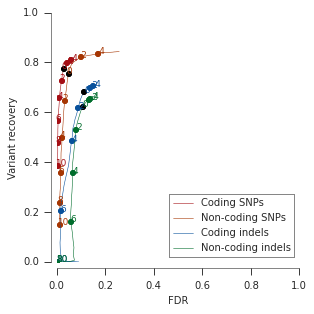

In [131]:
fig = plot_summary_roc_all()

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


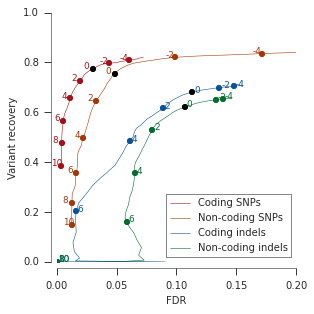

In [132]:
fig = plot_summary_roc_all('VQSLOD', xlim=0.2)

In [133]:
fig.savefig("%s/figures/VQSLOD_ROC_all_0.2.pdf" % output_dir)
fig.savefig("%s/figures/VQSLOD_ROC_all_0.2.png" % output_dir, dpi=300)

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [112]:
def plot_errors_by_score(threshold_variable='VQSLOD', samples=pacbio_samples, xlim=1.0, ylim=1.0):
    ylim = collections.OrderedDict()
    ylim[b'SNP'] = collections.OrderedDict()
    ylim[b'IND'] = collections.OrderedDict()
    ylim[b'SNP'][True] = (9000, 12000)
    ylim[b'SNP'][False] = (8000, 14000)
    ylim[b'IND'][True] = (13000, 14500)
    ylim[b'IND'][False] = (80000, 100000)

    fig = plt.figure(figsize=(8, 8))
    gs = mpl.gridspec.GridSpec(2, 2)
    ax = collections.OrderedDict()
    row_num = 0
#     ax['F'] = fig.add_subplot(gs[row_num, 0])
#     ax['FPhom'] = fig.add_subplot(gs[row_num, 0])
#     ax['FPhet'] = fig.add_subplot(gs[row_num, 1])
#     ax['FPall'] = fig.add_subplot(gs[row_num, 2])

    F = collections.OrderedDict()
#     sensitivity = collections.OrderedDict()
    
    for variant_type_ix, variant_type in enumerate([b'SNP', b'IND']):
        F[variant_type] = collections.OrderedDict()
#         sensitivity[variant_type] = collections.OrderedDict()
        for coding_ix, coding in enumerate ([True, False]):
            print(variant_type, coding)
            F[variant_type][coding] = collections.OrderedDict()
            num_thresholds = len(fdr_thresholds[threshold_variable])
#             for FP_type in ax:
            for FP_type in ['F']:
                F[variant_type][coding][FP_type] = np.zeros(num_thresholds, dtype=float)
#             sensitivity[variant_type][coding] = np.zeros(num_thresholds, dtype=float)
            for i, threshold_value in enumerate(fdr_thresholds[threshold_variable]):
                TP = 0
                FPhom = 0
                FPhet = 0
                FPall = 0
                FN = 0
                FPtype = 'F'
                for sample in samples:
                    status_sum = fdr_results_dict[threshold_variable][threshold_value][sample].groupby(
                        level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                    if 'FPhom' in status_sum[variant_type][coding].keys():
                        FPhom = FPhom + status_sum[variant_type][coding]['FPhom']
                    if 'FPhet' in status_sum[variant_type][coding].keys():
                        FPhet = FPhet + status_sum[variant_type][coding]['FPhet']
                    FPall = FPhom + FPhet
                    if 'TPhom' in status_sum[variant_type][coding].keys():
                        TP = TP + status_sum[variant_type][coding]['TPhom']
                    if 'FN' in status_sum[variant_type][coding].keys():
                        FN = FN + status_sum[variant_type][coding]['FN']
                if (FN+FPhom+FPhet) == 0:
                    F[variant_type][coding][FP_type][i] = 0.0
                else:
                    F[variant_type][coding][FP_type][i] = FN+FPhom+FPhet
#                     F[variant_type][coding][FP_type][i] = (FN+FPhom+FPhet) / (FN+FPhom+FPhet+TP)
            if variant_type == b'SNP':
                text_offset = -0.007
            else:
                text_offset = 0.002
            if coding == True and variant_type == b'SNP':
                label = "Coding SNPs" 
            if coding == False and variant_type == b'SNP':
                label = "Non-coding SNPs" 
            if coding == True and variant_type == b'IND':
                label = "Coding indels" 
            if coding == False and variant_type == b'IND':
                label = "Non-coding indels"
            
            ax['F'] = fig.add_subplot(gs[variant_type_ix, coding_ix])
#             for FP_type in ax:
            for FP_type in ['F']:
                colour = df_colours['colour'][variant_type][coding]['FPall']
                ax[FP_type].plot(
                    fdr_thresholds[threshold_variable],
                    F[variant_type][coding][FP_type],
                    color=colour,
                    label=label
                )
#                 for threshold_value in fdr_plot_points[threshold_variable]:
                for threshold_value in np.array([ -8., -6., -4.,  -2.,   0.,   2.]):
                    threshold_index = np.isclose(fdr_thresholds[threshold_variable], threshold_value)
                    if np.isclose(threshold_value, fdr_selected_threshold[threshold_variable]):
                        ax[FP_type].plot(
                            fdr_thresholds[threshold_variable][threshold_index],
                            F[variant_type][coding][FP_type][threshold_index],
                            'o',
                            color="black"
                        )
                    else:
                        ax[FP_type].plot(
                            fdr_thresholds[threshold_variable][threshold_index],
                            F[variant_type][coding][FP_type][threshold_index],
                            'o',
                            color=colour)
                    ax[FP_type].text(
                        fdr_thresholds[threshold_variable][threshold_index]+text_offset,
                        F[variant_type][coding][FP_type][threshold_index],
                        int(threshold_value),
                        fontsize=8,
                        color=colour
                    )
                sns.despine(ax=ax[FP_type], offset=5)
                ax[FP_type].set_xlim(-8, 2)
                ax[FP_type].set_ylim(ylim[variant_type][coding])
#                 ax[FP_type].set_xlim(0, xlim)
#                 ax[FP_type].set_ylim(0, ylim)
                ax[FP_type].legend(loc='upper left')
            ax['F'].set_xlabel('VQSLOD')
#             ax['FPhom'].set_xlabel(r'$\mathrm{FDR_{hom}}$')
#             ax['FPhet'].set_xlabel(r'$\mathrm{FDR_{het}}$')
#             ax['FPall'].set_xlabel(r'$\mathrm{FDR_{all}}$')
#             ax['FPhom'].set_ylabel('Sensitivity')
            ax['F'].set_ylabel('FP+FN')

    fig.tight_layout()
    return(fig)

    

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


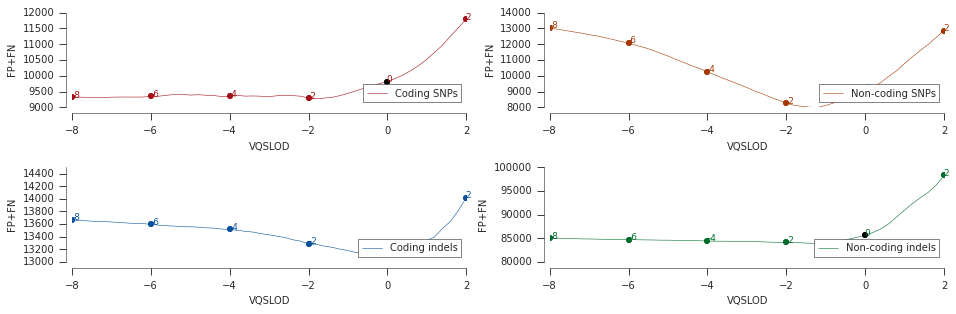

In [107]:
fig = plot_errors_by_score()

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


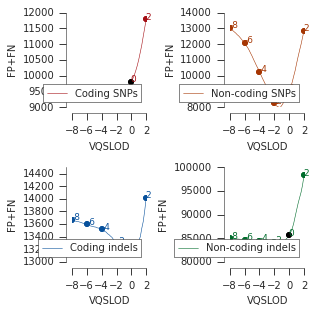

In [109]:
fig = plot_errors_by_score()

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


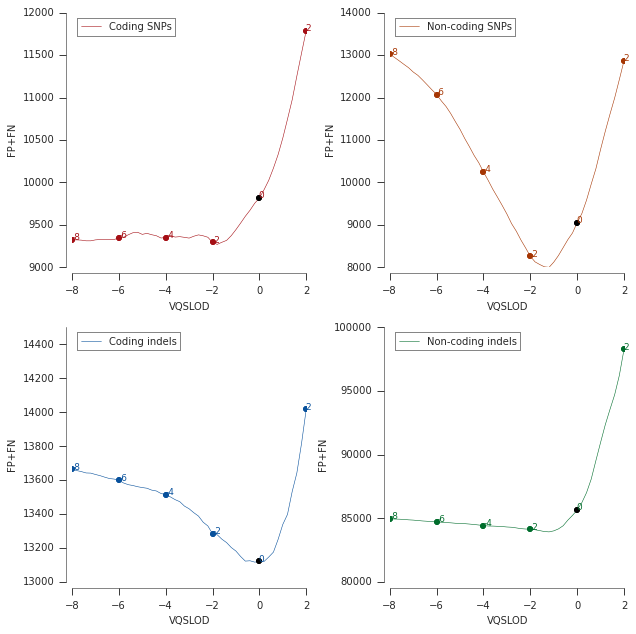

In [128]:
fig = plot_errors_by_score()
fig.savefig("%s/figures/VQSLOD_errors.pdf" % output_dir)
fig.savefig("%s/figures/VQSLOD_errors.png" % output_dir, dpi=300)

In [129]:
output_dir

'/lustre/scratch109/malaria/rp7/data/pf3k/pilot_5_0/20161019_call_set_summary'

In [99]:
def plot_samples_roc(threshold_variable='VQSLOD', samples=pacbio_samples, xlim=None, ylim=None, text_offset=0.005):

    fig = plt.figure(figsize=(12, 16))
    gs = mpl.gridspec.GridSpec(4, 3)

    FDR = collections.OrderedDict()
    sensitivity = collections.OrderedDict()
    
    num_thresholds = len(fdr_thresholds[threshold_variable])
    
    for ix_variant_type, variant_type in enumerate([b'SNP', b'IND']):
        FDR[variant_type] = collections.OrderedDict()
        sensitivity[variant_type] = collections.OrderedDict()
        for ix_coding, coding in enumerate([True, False]):
            print(variant_type, coding)
            FDR[variant_type][coding] = collections.OrderedDict()
            sensitivity[variant_type] = collections.OrderedDict()
            row_num = (ix_variant_type*2) + ix_coding
            ax = collections.OrderedDict()
            ax['FPhom'] = fig.add_subplot(gs[row_num, 0])
            ax['FPhet'] = fig.add_subplot(gs[row_num, 1])
            ax['FPall'] = fig.add_subplot(gs[row_num, 2])
            for sample in samples:
                for FP_type in ax:
                    FDR[variant_type][coding][FP_type] = np.zeros(num_thresholds, dtype=float)
                sensitivity[variant_type][coding] = np.zeros(num_thresholds, dtype=float)
                for i, threshold_value in enumerate(fdr_thresholds[threshold_variable]):
                    status_sum = fdr_results_dict[threshold_variable][threshold_value][sample].groupby(
                        level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                    if 'FPhom' in status_sum[variant_type][coding].keys():
                        FPhom = status_sum[variant_type][coding]['FPhom']
                    if 'FPhet' in status_sum[variant_type][coding].keys():
                        FPhet = status_sum[variant_type][coding]['FPhet']
                    FPall = FPhom + FPhet
                    if 'TPhom' in status_sum[variant_type][coding].keys():
                        TP = status_sum[variant_type][coding]['TPhom']
                    if 'FN' in status_sum[variant_type][coding].keys():
                        FN = status_sum[variant_type][coding]['FN']
                    FDR[variant_type][coding]['FPhom'][i] = FPhom/(TP+FPhom)
                    FDR[variant_type][coding]['FPhet'][i] = FPhet/(TP+FPhet)
                    FDR[variant_type][coding]['FPall'][i] = FPall/(TP+FPall)
                    sensitivity[variant_type][coding][i] = TP/(TP+FN)
                colour = sample_colours[sample]
                if coding == True and variant_type == b'SNP':
                    label = "Sensitivity (coding SNPs)" 
                if coding == False and variant_type == b'SNP':
                    label = "Sensitivity (non-coding SNPs)" 
                if coding == True and variant_type == b'IND':
                    label = "Sensitivity (coding indels)" 
                if coding == False and variant_type == b'IND':
                    label = "Sensitivity (non-coding indels)"
                for FP_type in ax:
                    ax[FP_type].plot(
                        FDR[variant_type][coding][FP_type],
                        sensitivity[variant_type][coding],
                        color=colour,
                        label=sample
                    )
    
                    for threshold_value in fdr_plot_points[threshold_variable]:
                        threshold_index = np.isclose(fdr_thresholds[threshold_variable], threshold_value)
                        if np.isclose(threshold_value, fdr_selected_threshold[threshold_variable]):
                            ax[FP_type].plot(
                                FDR[variant_type][coding][FP_type][threshold_index],
                                sensitivity[variant_type][coding][threshold_index],
                                'o',
                                color="black"
                            )
                        else:
                            ax[FP_type].plot(
                                FDR[variant_type][coding][FP_type][threshold_index],
                                sensitivity[variant_type][coding][threshold_index],
                                'o',
                                color=colour)
                        ax[FP_type].text(
                            FDR[variant_type][coding][FP_type][threshold_index]+text_offset,
                            sensitivity[variant_type][coding][threshold_index],
                            int(threshold_value),
                            fontsize=8,
                            color=colour
                        )
                    
                    sns.despine(ax=ax[FP_type], offset=5)
                    if xlim is not None:
                        ax[FP_type].set_xlim(0, xlim)
                    if ylim is not None:
                        ax[FP_type].set_ylim(0, ylim)
            ax['FPhom'].set_xlabel(r'$\mathrm{FDR_{hom}}$')
            ax['FPhet'].set_xlabel(r'$\mathrm{FDR_{het}}$')
            ax['FPall'].set_xlabel(r'$\mathrm{FDR_{all}}$')
            ax['FPhom'].set_ylabel(label)
            if row_num == 0:
                ax['FPhom'].legend(loc='lower right')

    fig.tight_layout()
    return(fig)


b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


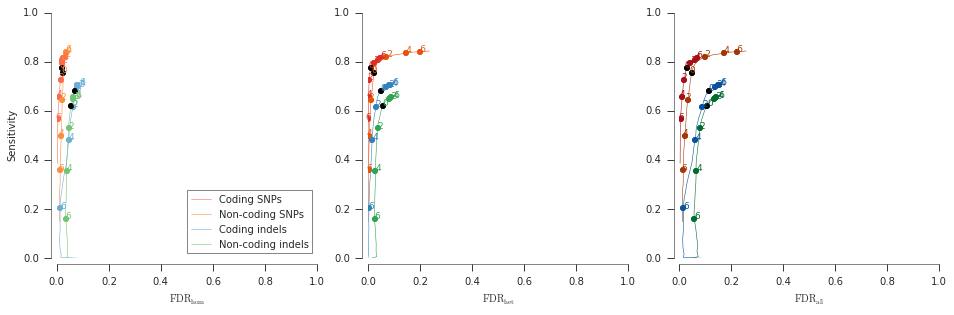

In [64]:
fig = plot_summary_roc()

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


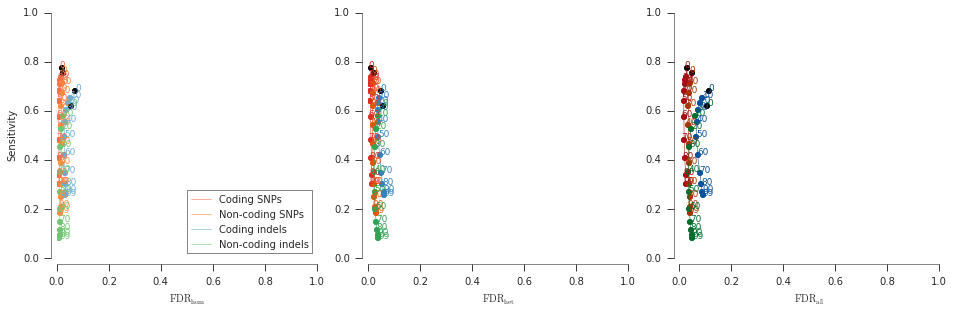

In [65]:
fig = plot_summary_roc('GQ')

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


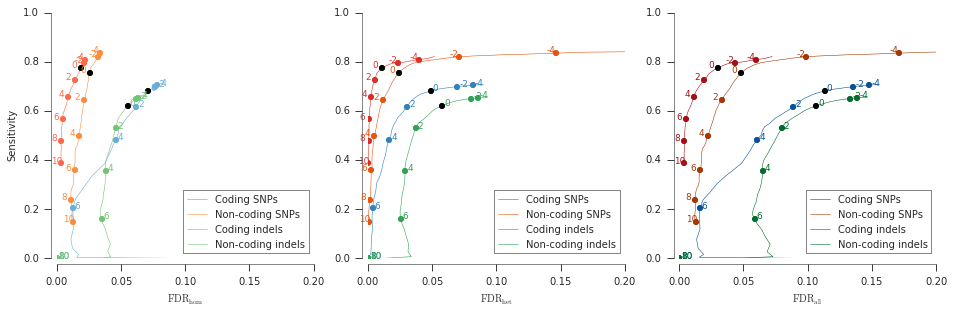

In [82]:
fig = plot_summary_roc('VQSLOD', 0.2)
fig.savefig("%s/figures/VQSLOD_ROC.pdf" % output_dir)
fig.savefig("%s/figures/VQSLOD_ROC.png" % output_dir, dpi=300)

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


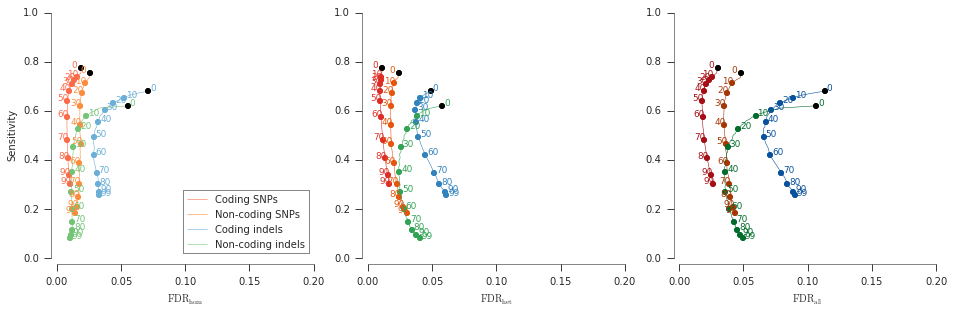

In [67]:
fig = plot_summary_roc('GQ', 0.2)

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


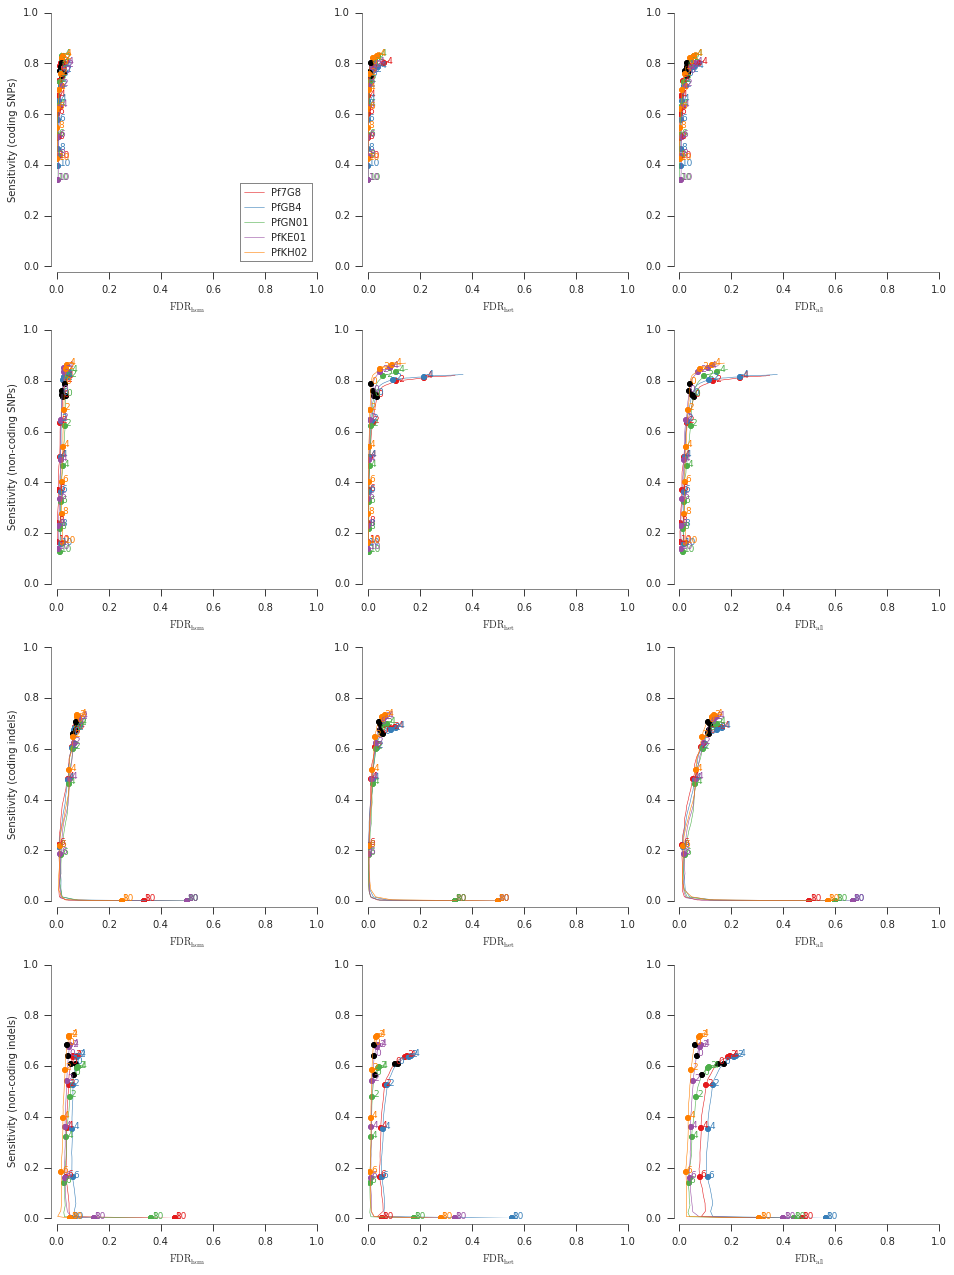

In [100]:
fig = plot_samples_roc(xlim=1.0, ylim=1.0)

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


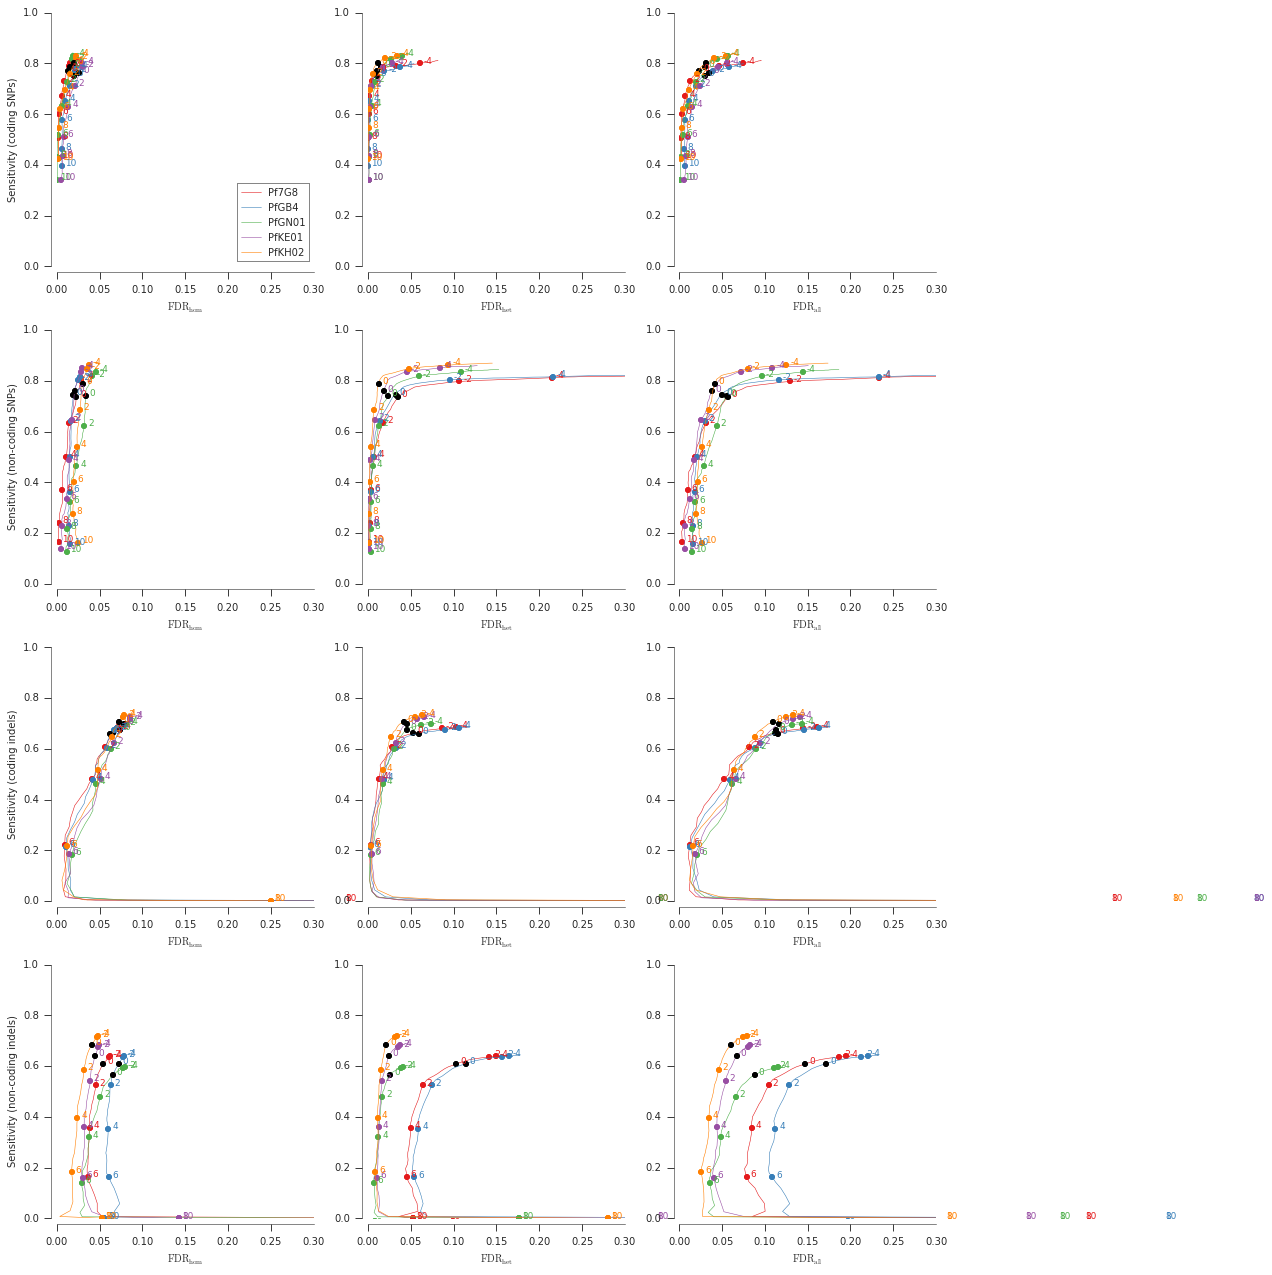

In [96]:
fig = plot_samples_roc(xlim=0.3, ylim=1.0)
fig.savefig("%s/figures/VQSLOD_samples_ROC.pdf" % output_dir)
fig.savefig("%s/figures/VQSLOD_samples_ROC.png" % output_dir, dpi=300)

b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


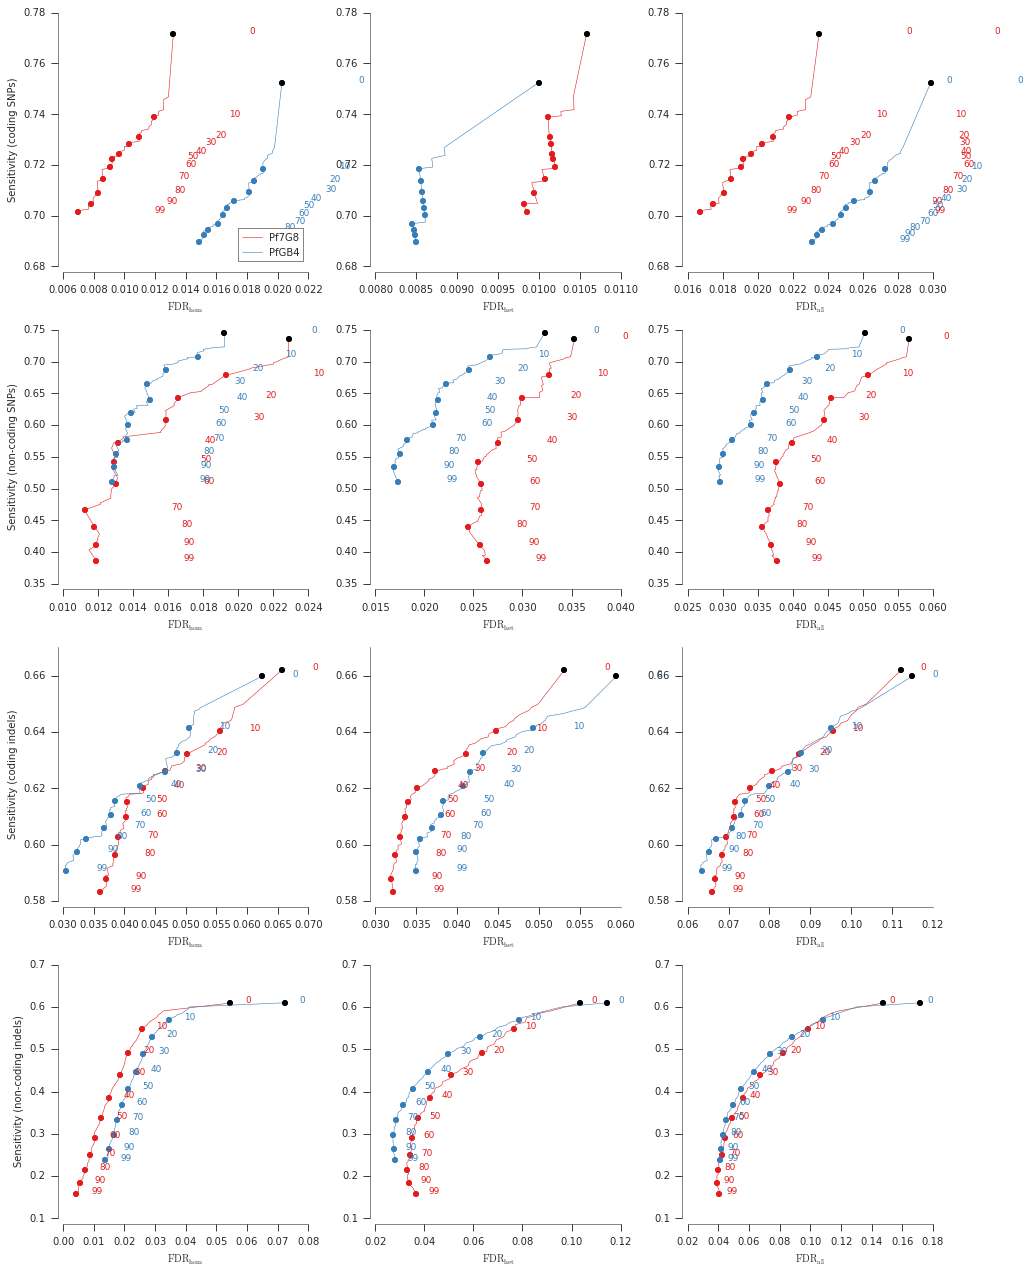

In [101]:
fig = plot_samples_roc('GQ', samples=['Pf7G8', 'PfGB4'])


b'SNP' True
b'SNP' False
b'IND' True
b'IND' False


/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


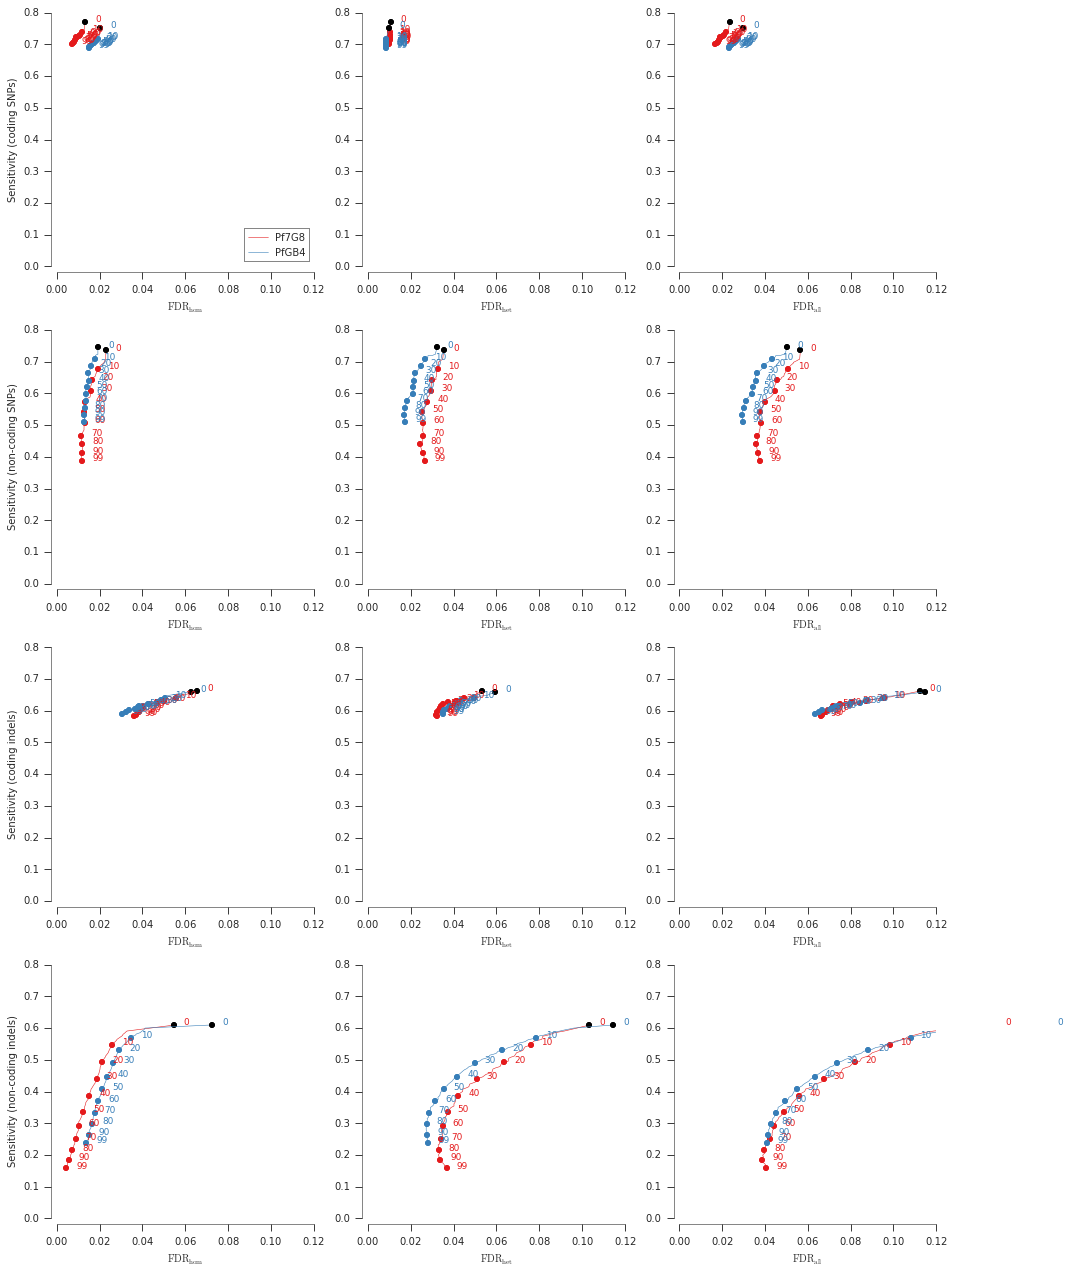

In [102]:
fig = plot_samples_roc('GQ', samples=['Pf7G8', 'PfGB4'], xlim=0.12, ylim=0.8)


# Decision on GQ threshold
After thinking about the results of the above plots, I decided against using a GQ threshold becuase:
1. For SNPs, there is more improvement in FDR by raising VQSLOD threshold than for raising GQ threshold
1. There is clearly a threshold, above which the genotype quality drops, and this threshold is dependent on the depth of coverage (field sample used here have ~30x coverage whereas crosses parents have ~100x coverage)
1. Because of the above we clearly need to use "typical" samples, and typical coverage is ~100x (though there is great variance in sample coverage). For the crosses parents (which we think are typical) there is no obvious cut-off - the choice is very much dependent on the balance between sensitivity and specificity (i.e. on the relative costs of FPs and FNs)
1. If FP and FN are treated as equally bad, the best threshold to use is 0
1. It might be better to use a measure more like QD (e.g. GQ/DP), but this really requires more in-depth exploration
1. Good thresholds might look very different if we filter variants differently in the future, e.g. by incorporating a hyperhet filter. Therefore, we probably want to explore both variant-level and genotype-level filters at the same time.
1. Although the crosses parents have typical coverage, they don't have typical read length (76bp), and therefore a proper analysis of GQ thresholds should perhaps wait until we have incorporated the samples from study 1153
1. We decided to stick to GATK recommendations, and no recommendations are given for GQ thresholds


# Create tables

In [430]:
# fdr_results_dict['VQSLOD'][-3.5527136788005009e-14]['PfGB4']

In [431]:
# fdr_results_dict['VQSLOD'][-3.5527136788005009e-14]['Pf7G8']

In [126]:
# type(fdr_results_dict['VQSLOD'][-3.5527136788005009e-14]['Pf7G8'])

pandas.core.series.Series

In [432]:
# list(fdr_results_dict['VQSLOD'].items())

In [20]:
def create_results_dict(status_sum):
    results = collections.OrderedDict()
    results['FP (het)'] = status_sum['FPhet'].replace(np.nan, 0.0)
    results['FP (hom)'] = status_sum['FPhom'].replace(np.nan, 0.0)
    results['FP (all)'] = (results['FP (het)'] + results['FP (hom)'])
    results['TP'] = status_sum['TPhom'].replace(np.nan, 0.0)
    results['FN'] = status_sum['FN'].replace(np.nan, 0.0)
    results['FDR (het)'] = results['FP (het)'] / (results['FP (het)'] + results['TP'])
    results['FDR (hom)'] = results['FP (hom)'] / (results['FP (hom)'] + results['TP'])
    results['FDR (all)'] = results['FP (all)'] / (results['FP (all)'] + results['TP'])
    results['Sensitivity'] = results['TP'] / (results['TP'] + results['FN'])
    return(results)


def create_fdr_summary(threshold_variable='VQSLOD', threshold_value=-3.5527136788005009e-14, samples=pacbio_samples,
                      groupby_variables = ['VARIANT_TYPE', 'CDS'], ascending=None):
    if ascending is None:
        ascending = [True if x == 'MULTIALLELIC_x' else False for x in groupby_variables]
    
    variant_type_levels = ['status'] + groupby_variables
    fdr_results = fdr_results_dict[threshold_variable][threshold_value][samples[0]]
#     for column in groupby_variables:
#         df_results[column] = df_results[column].str.decode('ascii')
    
    variant_type_sum = fdr_results_dict[threshold_variable][threshold_value][samples[0]].groupby(
            level=variant_type_levels).sum()
#     total_sum = fdr_results_dict[threshold_variable][threshold_value][samples[0]].groupby(
#             level=['status']).sum()
    for sample in samples[1:]:
        variant_type_sum = variant_type_sum + fdr_results_dict[threshold_variable][threshold_value][sample].groupby(
            level=variant_type_levels).sum()
#         total_sum = total_sum + fdr_results_dict[threshold_variable][threshold_value][sample].groupby(
#             level=['status']).sum()

#     See http://stackoverflow.com/questions/16994485/ensuring-the-cartesian-product-of-keys-appears-in-a-pandas-table
    if len(variant_type_levels) == 1:
        temp = pd.DataFrame(variant_type_sum)
        temp['Total'] = 'Total'
        temp.set_index('Total', append=True, inplace=True)
        variant_type_sum = temp.ix[:, 0]
    
    p = pd.MultiIndex.from_product(variant_type_sum.index.levels, names=variant_type_sum.index.names)
    variant_type_sum = variant_type_sum.reindex(p, fill_value=0)
        
    variant_type_results = create_results_dict(variant_type_sum)

    df_results = pd.DataFrame(variant_type_results).sortlevel(range(len(groupby_variables)), ascending=ascending)
    df_results.reset_index(inplace=True)
        
    if 'MULTIALLELIC_x' in df_results.columns:
        df_results = df_results[df_results['MULTIALLELIC_x'] != b'MIS']

    for i, column in enumerate(groupby_variables):
        if column != 'CDS':
            df_results[column] = df_results[column].str.decode('ascii')
        
    df_results.rename(columns={'MULTIALLELIC_x': 'MULTIALLELIC'}, inplace=True)
        
    return(df_results)


In [24]:
create_fdr_summary(groupby_variables=[])

,Total,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,Total,9245,9790,19035,193979,98610,0.045492,0.048045,0.08936,0.662974


In [95]:
create_fdr_summary(groupby_variables=[])

,Total,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,Total,9245,9790,19035,193979,98610,0.045492,0.048045,0.08936,0.662974


In [612]:
main_table_fdr = pd.concat(
    (
        create_fdr_summary(),
        create_fdr_summary(groupby_variables=[])
    )
)[['Total'] + list(create_fdr_summary().columns)]
main_table_fdr_fn = "%s/tables/main_table_fdr.txt" % output_dir
main_table.to_csv(main_table_fdr_fn, sep='\t')
main_table_fdr

,Total,VARIANT_TYPE,CDS,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,NaN,b'SNP',True,346,600,946,30576,8871,0.011189,0.019246,0.030011,0.775116
1,NaN,b'SNP',False,593,628,1221,23997,7833,0.024115,0.025503,0.048418,0.753911
2,NaN,b'IND',True,1129,1683,2812,22005,10309,0.048803,0.071049,0.113309,0.680974
3,NaN,b'IND',False,7177,6879,14056,117401,71597,0.057610,0.055351,0.106925,0.621176
0,Total,NaN,NaN,9245,9790,19035,193979,98610,0.045492,0.048045,0.089360,0.662974


In [613]:
create_fdr_summary(samples=['PfGN01', 'PfKE01', 'PfKH02'])

,VARIANT_TYPE,CDS,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,b'SNP',True,222,397,619,18652,5147,0.011762,0.020841,0.032121,0.783730
1,b'SNP',False,263,425,688,14567,4530,0.017734,0.028348,0.045100,0.762790
2,b'IND',True,634,1115,1749,13709,6051,0.044203,0.075216,0.113145,0.693775
3,b'IND',False,1807,3891,5698,73481,43456,0.024001,0.050290,0.071964,0.628381


In [68]:
create_fdr_summary(groupby_variables=['VARIANT_TYPE', 'CDS', 'MULTIALLELIC_x'])


,VARIANT_TYPE,CDS,MULTIALLELIC,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,SNP,True,BI,55.0,129.0,184.0,24708.0,0.0,0.002221,0.005194,0.007392,1.0
2,SNP,True,MU,61.0,93.0,154.0,4168.0,0.0,0.014424,0.021826,0.035632,1.0
3,SNP,True,SD,230.0,378.0,608.0,1700.0,0.0,0.119171,0.181906,0.263432,1.0
4,SNP,False,BI,112.0,317.0,429.0,17335.0,0.0,0.006419,0.017958,0.024150,1.0
6,SNP,False,MU,93.0,78.0,171.0,2782.0,0.0,0.032348,0.027273,0.057907,1.0
7,SNP,False,SD,388.0,233.0,621.0,3880.0,0.0,0.090909,0.056650,0.137969,1.0
8,IND,True,BI,0.0,13.0,13.0,612.0,0.0,0.000000,0.020800,0.020800,1.0
10,IND,True,MU,987.0,1353.0,2340.0,20349.0,0.0,0.046260,0.062344,0.103134,1.0
11,IND,True,SD,133.0,317.0,450.0,1044.0,0.0,0.112999,0.232917,0.301205,1.0
12,IND,False,BI,40.0,54.0,94.0,3430.0,0.0,0.011527,0.015499,0.026674,1.0


In [615]:
create_fdr_summary(groupby_variables=['VARIANT_TYPE', 'CDS', 'MULTIALLELIC_x'], samples=['PfGN01', 'PfKE01', 'PfKH02'])

,VARIANT_TYPE,CDS,MULTIALLELIC_x,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,b'SNP',True,b'BI',28.0,63.0,91.0,15004.0,0.0,0.001863,0.004181,0.006028,1.0
2,b'SNP',True,b'MU',33.0,61.0,94.0,2527.0,0.0,0.012891,0.023570,0.035864,1.0
3,b'SNP',True,b'SD',161.0,273.0,434.0,1121.0,0.0,0.125585,0.195839,0.279100,1.0
4,b'SNP',False,b'BI',63.0,221.0,284.0,10443.0,0.0,0.005997,0.020724,0.026475,1.0
6,b'SNP',False,b'MU',46.0,61.0,107.0,1681.0,0.0,0.026636,0.035017,0.059843,1.0
7,b'SNP',False,b'SD',154.0,143.0,297.0,2443.0,0.0,0.059299,0.055298,0.108394,1.0
8,b'IND',True,b'BI',0.0,11.0,11.0,370.0,0.0,0.000000,0.028871,0.028871,1.0
10,b'IND',True,b'MU',552.0,906.0,1458.0,12656.0,0.0,0.041793,0.066804,0.103302,1.0
11,b'IND',True,b'SD',79.0,198.0,277.0,683.0,0.0,0.103675,0.224745,0.288542,1.0
12,b'IND',False,b'BI',15.0,29.0,44.0,2149.0,0.0,0.006932,0.013315,0.020064,1.0


In [616]:
create_fdr_summary(threshold_value=5.9999999999999432)

,VARIANT_TYPE,CDS,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,b'SNP',True,29.0,117.0,146.0,25794.0,19777.0,0.001123,0.004515,0.005628,0.566018
1,b'SNP',False,37.0,204.0,241.0,14415.0,25822.0,0.002560,0.013954,0.016444,0.358252
2,b'IND',True,21.0,75.0,96.0,5904.0,23117.0,0.003544,0.012544,0.016000,0.203439
3,b'IND',False,800.0,1112.0,1912.0,30672.0,159521.0,0.025419,0.034986,0.058679,0.161268


In [617]:
create_fdr_summary(threshold_value=4.9999999999999467)

,VARIANT_TYPE,CDS,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,b'SNP',True,39.0,174.0,213.0,27337.0,17599.0,0.001425,0.006325,0.007731,0.608354
1,b'SNP',False,59.0,247.0,306.0,16955.0,21830.0,0.003468,0.014359,0.017728,0.437154
2,b'IND',True,116.0,359.0,475.0,10601.0,18603.0,0.010824,0.032755,0.042886,0.362998
3,b'IND',False,1259.0,1754.0,3013.0,46773.0,143856.0,0.026212,0.036145,0.060519,0.245361


In [618]:
create_fdr_summary(threshold_value=5.9999999999999432, groupby_variables=['VARIANT_TYPE', 'CDS', 'MULTIALLELIC_x'])

,VARIANT_TYPE,CDS,MULTIALLELIC_x,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,b'SNP',True,b'BI',0.0,0.0,0.0,21498.0,0.0,0.000000,0.000000,0.000000,1.0
2,b'SNP',True,b'MU',0.0,23.0,23.0,3496.0,0.0,0.000000,0.006536,0.006536,1.0
3,b'SNP',True,b'SD',18.0,45.0,63.0,800.0,0.0,0.022005,0.053254,0.073001,1.0
4,b'SNP',False,b'BI',9.0,134.0,143.0,11320.0,0.0,0.000794,0.011699,0.012475,1.0
6,b'SNP',False,b'MU',0.0,0.0,0.0,1644.0,0.0,0.000000,0.000000,0.000000,1.0
7,b'SNP',False,b'SD',27.0,48.0,75.0,1451.0,0.0,0.018268,0.032021,0.049148,1.0
8,b'IND',True,b'BI',0.0,0.0,0.0,172.0,0.0,0.000000,0.000000,0.000000,1.0
10,b'IND',True,b'MU',20.0,72.0,92.0,5649.0,0.0,0.003528,0.012585,0.016025,1.0
11,b'IND',True,b'SD',0.0,0.0,0.0,83.0,0.0,0.000000,0.000000,0.000000,1.0
12,b'IND',False,b'BI',0.0,0.0,0.0,891.0,0.0,0.000000,0.000000,0.000000,1.0


In [619]:
create_fdr_summary(threshold_value=5.9999999999999432, groupby_variables=['VARIANT_TYPE', 'CDS', 'MULTIALLELIC_x'])

,VARIANT_TYPE,CDS,MULTIALLELIC_x,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,b'SNP',True,b'BI',0.0,0.0,0.0,21498.0,0.0,0.000000,0.000000,0.000000,1.0
2,b'SNP',True,b'MU',0.0,23.0,23.0,3496.0,0.0,0.000000,0.006536,0.006536,1.0
3,b'SNP',True,b'SD',18.0,45.0,63.0,800.0,0.0,0.022005,0.053254,0.073001,1.0
4,b'SNP',False,b'BI',9.0,134.0,143.0,11320.0,0.0,0.000794,0.011699,0.012475,1.0
6,b'SNP',False,b'MU',0.0,0.0,0.0,1644.0,0.0,0.000000,0.000000,0.000000,1.0
7,b'SNP',False,b'SD',27.0,48.0,75.0,1451.0,0.0,0.018268,0.032021,0.049148,1.0
8,b'IND',True,b'BI',0.0,0.0,0.0,172.0,0.0,0.000000,0.000000,0.000000,1.0
10,b'IND',True,b'MU',20.0,72.0,92.0,5649.0,0.0,0.003528,0.012585,0.016025,1.0
11,b'IND',True,b'SD',0.0,0.0,0.0,83.0,0.0,0.000000,0.000000,0.000000,1.0
12,b'IND',False,b'BI',0.0,0.0,0.0,891.0,0.0,0.000000,0.000000,0.000000,1.0


# Overall variant counts summary

In [9]:
gc.collect()

9

In [23]:
pf3k_all_variants = np.load("%s.vcfnp_cache/variants.npy" % sites_annotation_vcf_fn)

In [9]:
len(pf3k_all_variants)

6824972

In [10]:
np.unique(pf3k_all_variants['VARIANT_TYPE'], return_counts=True)

(array([b'', b'IND', b'SNP'], 
       dtype='|S3'), array([     20, 3919111, 2905841]))

In [21]:
# import pandas as pd

# def num_unique(values):
#     return(len(np.unique(values)))

# def determine_variant_counts(VQSLOD_threshold=0.0, all_variants=False):
#     columns_of_interest = ['CHROM', 'POS', 'AC', 'AN', 'CDS', 'VARIANT_TYPE', 'MULTIALLELIC']
#     if all_variants:
#         df_pf3k_all_variants = pd.DataFrame(pf3k_all_variants).loc[:, columns_of_interest]
#     else:
#         ix_good_calls = (
#             (pf3k_all_variants['VARIANT_TYPE'] != b'') &
#             (~pf3k_all_variants['FILTER_Centromere']) &
#             (~pf3k_all_variants['FILTER_InternalHypervariable']) &
#             (~pf3k_all_variants['FILTER_SubtelomericHypervariable']) &
#             (pf3k_all_variants['VQSLOD'] > VQSLOD_threshold)
#         )
#         df_pf3k_all_variants = pd.DataFrame(pf3k_all_variants[ix_good_calls]).loc[:, columns_of_interest]

#     for column in ['CHROM', 'VARIANT_TYPE', 'MULTIALLELIC']:
#         df_pf3k_all_variants[column] = df_pf3k_all_variants[column].str.decode('ascii')
#     df_pf3k_all_variants['CHROM_POS'] = df_pf3k_all_variants['CHROM'].str.cat(df_pf3k_all_variants['POS'].astype(str), sep='_')
    
#     df_summary = pd.DataFrame(
#         {
#             "Positions": df_pf3k_all_variants.groupby(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])['CHROM_POS'].agg(num_unique),
#             "Alleles": df_pf3k_all_variants.groupby(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC']).size()
#         }
#     )
#     df_summary["Alleles per position"] = df_summary["Alleles"] / df_summary["Positions"]

# #     return(df_summary, df_pf3k_all_variants)
#     return(df_summary)
    


In [21]:
def num_unique(values):
    return(len(np.unique(values)))

def determine_variant_counts(VQSLOD_threshold=0.0, groupby_variables = ['VARIANT_TYPE', 'CDS'], ascending=None,
                             number_of_samples=2640):
    if ascending is None:
        ascending = [True if x == 'MULTIALLELIC' else False for x in groupby_variables]
        
    df_pf3k_all_variants = pd.DataFrame(
        {
            'CHROM': pd.Series(pf3k_all_variants['CHROM'], dtype="category"),
            'POS': pd.Series(pf3k_all_variants['POS']),
            'AC': pd.Series(pf3k_all_variants['AC']),
            'AN': pd.Series(pf3k_all_variants['AN']),
            'NRAF': pd.Series(pf3k_all_variants['AC'] / pf3k_all_variants['AN']),
            'Missingness': pd.Series(((number_of_samples * 2) - pf3k_all_variants['AN']) / (number_of_samples * 2)),
            'CDS': pd.Series(pf3k_all_variants['CDS'], dtype="category"),
            'VARIANT_TYPE': pd.Series(pf3k_all_variants['VARIANT_TYPE'], dtype="category"),
            'MULTIALLELIC': pd.Series(pf3k_all_variants['MULTIALLELIC'], dtype="category"),
        }
    )
#     df_pf3k_all_variants.loc[df_pf3k_all_variants['VARIANT_TYPE'] == b'', 'VARIANT_TYPE'] = b'IND'
    ix_good_calls = (
        (pf3k_all_variants['VARIANT_TYPE'] != b'') &
        (~pf3k_all_variants['FILTER_Centromere']) &
        (~pf3k_all_variants['FILTER_InternalHypervariable']) &
        (~pf3k_all_variants['FILTER_SubtelomericHypervariable']) &
        (~pf3k_all_variants['FILTER_SubtelomericRepeat']) &
        (pf3k_all_variants['VQSLOD'] > VQSLOD_threshold)
    )

    df_pf3k_all_variants['PASS'] = ix_good_calls
    
    for i, column in enumerate(['CHROM', 'VARIANT_TYPE', 'MULTIALLELIC']):
        df_pf3k_all_variants[column].cat.categories = [
            x.decode('ascii') for x in df_pf3k_all_variants[column].cat.categories
        ]
    df_pf3k_all_variants['CHROM_POS'] = df_pf3k_all_variants['CHROM'].str.cat(df_pf3k_all_variants['POS'].astype(str), sep='_')

    if len(groupby_variables) == 0:
#         temp = pd.DataFrame(variant_type_sum)
        df_pf3k_all_variants['Total'] = 'Total'
        groupby_variables = ['Total']
    
#         temp.set_index('Total', append=True, inplace=True)
#         variant_type_sum = temp.ix[:, 0]
    
    gb_all = df_pf3k_all_variants.groupby(groupby_variables)
    gb_pass = df_pf3k_all_variants[df_pf3k_all_variants['PASS']].groupby(groupby_variables)
    
    df_summary = pd.concat(
        [
            gb_all['CHROM_POS'].agg(num_unique).rename("Discovered variant positions"),
            gb_pass['CHROM_POS'].agg(num_unique).rename("Pass variant positions"),
            gb_pass.size().rename("Alleles"),
            gb_pass['NRAF'].mean().rename("Mean NRAF"),
            gb_pass['Missingness'].mean().rename("Missingness"),
        ],
        axis=1
    )
    df_summary["% pass"] = df_summary["Pass variant positions"] / df_summary["Discovered variant positions"]
    df_summary["Alleles per position"] = df_summary["Alleles"] / df_summary["Pass variant positions"]
    df_summary["Variants per sample"] = df_summary["Alleles"] * df_summary["Mean NRAF"]
    
    df_summary.sortlevel(range(len(groupby_variables)), ascending=ascending, inplace=True)
    df_summary.reset_index(inplace=True)
        
    if 'MULTIALLELIC' in df_summary.columns:
        df_summary = df_summary[df_summary['MULTIALLELIC'] != 'MIS']
    

#     return(df_summary, df_pf3k_all_variants)
    return(df_summary)
    


In [51]:
ix_good_calls = (
    (pf3k_all_variants['VARIANT_TYPE'] != b'') &
    (~pf3k_all_variants['FILTER_Centromere']) &
    (~pf3k_all_variants['FILTER_InternalHypervariable']) &
    (~pf3k_all_variants['FILTER_SubtelomericHypervariable']) &
    (pf3k_all_variants['VQSLOD'] > 0.0)
)
print(np.unique(ix_good_calls, return_counts=True))
print(np.unique(pf3k_all_variants['FILTER_PASS'], return_counts=True))

(array([False,  True], dtype=bool), array([3813546, 3011426]))
(array([False,  True], dtype=bool), array([4152099, 2672873]))


In [54]:
discordant_filters = (
    (pf3k_all_variants['VARIANT_TYPE'] != b'') &
    (~pf3k_all_variants['FILTER_Centromere']) &
    (~pf3k_all_variants['FILTER_InternalHypervariable']) &
    (~pf3k_all_variants['FILTER_SubtelomericHypervariable']) &
    (~pf3k_all_variants['FILTER_SubtelomericRepeat']) &
    (pf3k_all_variants['VQSLOD'] > 0.0) &
    (pf3k_all_variants['FILTER_PASS'] == False)
)
print(np.unique(discordant_filters, return_counts=True))
pf3k_all_variants[discordant_filters]

(array([False], dtype=bool), array([6824972]))


array([], 
      dtype=[('CHROM', 'S12'), ('POS', '<i4'), ('CDS', '?'), ('VARIANT_TYPE', 'S3'), ('MULTIALLELIC', 'S2'), ('AC', '<u2'), ('AN', '<u2'), ('FILTER_Centromere', '?'), ('FILTER_InternalHypervariable', '?'), ('FILTER_LowQual', '?'), ('FILTER_Low_VQSLOD', '?'), ('FILTER_PASS', '?'), ('FILTER_SubtelomericHypervariable', '?'), ('FILTER_SubtelomericRepeat', '?'), ('FILTER_VQSRTrancheINDEL99.00to99.90', '?'), ('FILTER_VQSRTrancheINDEL99.90to100.00', '?'), ('FILTER_VQSRTrancheINDEL99.90to100.00+', '?'), ('FILTER_VQSRTrancheSNP99.90to100.00', '?'), ('FILTER_VQSRTrancheSNP99.90to100.00+', '?'), ('VQSLOD', '<f4')])

In [52]:
pf3k_all_variants

array([ (b'Pf3D7_01_v3', 37, False, b'IND', b'BI', 6, 3386, False, False, False, False, False, False, True, False, False, False, False, False, 3.5799999237060547),
       (b'Pf3D7_01_v3', 67, False, b'IND', b'BI', 1, 4092, False, False, False, False, False, False, True, False, False, False, False, False, 3.049999952316284),
       (b'Pf3D7_01_v3', 68, False, b'SNP', b'SD', 3, 4056, False, False, False, True, False, False, True, False, False, False, False, False, -5.140999794006348),
       ...,
       (b'Pf_M76611', 5960, False, b'SNP', b'BI', 1, 2, False, False, False, True, False, False, False, False, False, False, False, False, -98.30999755859375),
       (b'Pf_M76611', 5963, False, b'SNP', b'BI', 2, 2, False, False, False, True, False, False, False, False, False, False, False, False, -60.68000030517578),
       (b'Pf_M76611', 5964, False, b'SNP', b'BI', 4, 4, False, False, False, True, False, False, False, False, False, False, False, False, -65.69999694824219)], 
      dtype=[('CHR

In [41]:
np.unique(pf3k_all_variants['VARIANT_TYPE'], return_counts=True)

(array([b'', b'IND', b'SNP'], 
       dtype='|S3'), array([     20, 3919111, 2905841]))

In [42]:
pf3k_all_variants[pf3k_all_variants['VARIANT_TYPE'] == b'']

array([ (b'Pf3D7_01_v3', 10831, False, b'', b'', 2, 5100, False, False, False, True, False, False, True, False, False, False, False, False, -2.984999895095825),
       (b'Pf3D7_01_v3', 637475, False, b'', b'', 1, 4696, False, False, False, False, False, False, True, False, False, False, False, False, 1.4900000095367432),
       (b'Pf3D7_02_v3', 10946, False, b'', b'', 1, 4456, False, False, False, False, False, False, True, False, False, False, False, False, 2.3299999237060547),
       (b'Pf3D7_02_v3', 933850, False, b'', b'', 1, 1162, False, False, False, False, False, False, True, False, False, False, False, False, 0.2619999945163727),
       (b'Pf3D7_03_v3', 15569, False, b'', b'', 8, 2466, False, False, False, False, False, False, True, False, False, False, False, False, 3.369999885559082),
       (b'Pf3D7_03_v3', 1052544, False, b'', b'', 1, 4370, False, False, False, False, False, False, True, False, False, False, False, False, 2.009999990463257),
       (b'Pf3D7_06_v3', 60280, F

In [13]:
gc.collect()

440

In [29]:
# df_summary, df_pf3k_all_variants = determine_variant_counts()
df_summary, df_pf3k_all_variants = determine_variant_counts()

In [32]:
determine_variant_counts(groupby_variables=[])

,Total,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,Total,4212467,2055920,3011426,0.016534,0.088755,0.488056,1.464758,49792.064947


In [56]:
determine_variant_counts(groupby_variables=[])

,Total,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,Total,4212467,1935195,2672872,0.017019,0.067453,0.459397,1.38119,45490.12682


In [64]:
determine_variant_counts(groupby_variables=[])

,Total,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,Total,4212467,1935195,2672873,0.017019,0.067453,0.459397,1.381191,45490.127013


In [62]:
determine_variant_counts(groupby_variables=[])

,Total,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,Total,4212467,1935215,2672900,0.017019,0.067453,0.459402,1.38119,45491.019882


In [24]:
determine_variant_counts(groupby_variables=[])

,Total,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,Total,4212467,1935195,2672872,0.017019,0.067453,0.459397,1.38119,45490.12682


In [47]:
2055951 - 1935198

120753

In [46]:
determine_variant_counts()

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,SNP,True,1252268,756150,809200,0.008008,0.007975,0.603824,1.070158,6479.803128
1,SNP,False,1309622,573729,605478,0.009548,0.054917,0.438087,1.055338,5781.223633
2,IND,True,508655,120483,264318,0.020760,0.040475,0.236866,2.193820,5487.285442
3,IND,False,1141924,605558,1332430,0.024049,0.162767,0.530296,2.200334,32043.752744


In [25]:
determine_variant_counts()

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,SNP,True,1252268,756150.0,809200.0,0.008008,0.007975,0.603824,1.070158,6479.803128
1,SNP,False,1309622,573179.0,604598.0,0.009481,0.054612,0.437668,1.054815,5732.456383
2,IND,True,508655,120483.0,264318.0,0.020760,0.040475,0.236866,2.193820,5487.285442
3,IND,False,1141920,485383.0,994756.0,0.027937,0.130808,0.425059,2.049425,27790.581866
4,,False,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
df_summary

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,SNP,True,1252268,756150.0,809200.0,0.008008,0.007975,0.603824,1.070158,6479.803128
1,SNP,False,1309622,573729.0,605478.0,0.009548,0.054917,0.438087,1.055338,5781.223633
2,IND,True,508655,120483.0,264318.0,0.020760,0.040475,0.236866,2.193820,5487.285442
3,IND,False,1141920,605558.0,1332430.0,0.024049,0.162767,0.530298,2.200334,32043.752744
4,,False,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_summary

,VARIANT_TYPE,CDS,MULTIALLELIC,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,SNP,True,BI,1011168,641856.0,641856.0,0.007808,31.285943,0.634767,1.000000,5011.539202
1,SNP,True,MU,119930,51184.0,104234.0,0.008449,48.015158,0.426782,2.036457,880.643091
2,SNP,True,SD,121170,63110.0,63110.0,0.009311,142.415243,0.520838,1.000000,587.620835
3,SNP,False,BI,842330,417828.0,417828.0,0.008422,197.546560,0.496038,1.000000,3519.062717
4,SNP,False,MU,173409,30720.0,62469.0,0.010539,251.898382,0.177153,2.033496,658.380589
5,SNP,False,SD,293883,125181.0,125181.0,0.012812,617.410725,0.425955,1.000000,1603.780327
6,IND,True,BI,53257,10686.0,10686.0,0.012223,75.557739,0.200650,1.000000,130.619167
7,IND,True,MU,365527,66211.0,210046.0,0.023559,221.324729,0.181138,3.172373,4948.476365
8,IND,True,SD,89871,43586.0,43586.0,0.009365,210.864498,0.484984,1.000000,408.189909
9,IND,False,BI,209921,90005.0,90005.0,0.007784,361.702972,0.428757,1.000000,700.642669


In [31]:
df_summary.set_index(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'], inplace=True)

In [39]:
df_fdr = create_fdr_summary(groupby_variables=['VARIANT_TYPE', 'CDS', 'MULTIALLELIC_x'])
# df_fdr.rename(columns={"MULTIALLELIC_x": "MULTIALLELIC"}, inplace=True)
df_fdr

,VARIANT_TYPE,CDS,MULTIALLELIC,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,SNP,True,BI,55.0,129.0,184.0,24708.0,0.0,0.002221,0.005194,0.007392,1.0
2,SNP,True,MU,61.0,93.0,154.0,4168.0,0.0,0.014424,0.021826,0.035632,1.0
3,SNP,True,SD,230.0,378.0,608.0,1700.0,0.0,0.119171,0.181906,0.263432,1.0
4,SNP,False,BI,112.0,317.0,429.0,17335.0,0.0,0.006419,0.017958,0.024150,1.0
6,SNP,False,MU,93.0,78.0,171.0,2782.0,0.0,0.032348,0.027273,0.057907,1.0
7,SNP,False,SD,388.0,233.0,621.0,3880.0,0.0,0.090909,0.056650,0.137969,1.0
8,IND,True,BI,0.0,13.0,13.0,612.0,0.0,0.000000,0.020800,0.020800,1.0
10,IND,True,MU,987.0,1353.0,2340.0,20349.0,0.0,0.046260,0.062344,0.103134,1.0
11,IND,True,SD,133.0,317.0,450.0,1044.0,0.0,0.112999,0.232917,0.301205,1.0
12,IND,False,BI,40.0,54.0,94.0,3430.0,0.0,0.011527,0.015499,0.026674,1.0


In [44]:
df_fdr = create_fdr_summary(groupby_variables=['VARIANT_TYPE', 'CDS'])
# df_fdr.rename(columns={"MULTIALLELIC_x": "MULTIALLELIC"}, inplace=True)
df_fdr

,VARIANT_TYPE,CDS,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,SNP,True,346,600,946,30576,8871,0.011189,0.019246,0.030011,0.775116
1,SNP,False,593,628,1221,23997,7833,0.024115,0.025503,0.048418,0.753911
2,IND,True,1129,1683,2812,22005,10309,0.048803,0.071049,0.113309,0.680974
3,IND,False,7177,6879,14056,117401,71597,0.057610,0.055351,0.106925,0.621176


In [32]:
df_fdr.set_index(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'], inplace=True)

In [36]:
pd.concat([df_summary, df_fdr], axis=1)

Discovered variant positions  \
VARIANT_TYPE CDS   MULTIALLELIC                                 
             False                                         20   
IND          False BI                                  209921   
                   MU                                  608987   
                   SD                                  323012   
             True  BI                                   53257   
                   MU                                  365527   
                   SD                                   89871   
SNP          False BI                                  842330   
                   MU                                  173409   
                   SD                                  293883   
             True  BI                                 1011168   
                   MU                                  119930   
                   SD                                  121170   

                                 Pass variant positions    Alleles  Mean NRAF  \
VARIANT_TYPE CDS   MULTIALLELIC                                                 
             False                                  NaN        NaN        NaN   
IND          False BI                           90005.0    90005.0   0.007784   
                   MU                          311834.0  1038706.0   0.028227   
                   SD                          203719.0   203719.0   0.009931   
             True  BI                           10686.0    10686.0   0.012223   
                   MU                           66211.0   210046.0   0.023559   
                   SD                           43586.0    43586.0   0.009365   
SNP          False BI                          417828.0   417828.0   0.008422   
                   MU                           30720.0    62469.0   0.010539   
                   SD                          125181.0   125181.0   0.012812   
             True  BI                          641856.0   641856.0   0.007808   
                   MU                           51184.0   104234.0   0.008449   
                   SD                           63110.0    63110.0   0.009311   

                                 Missingness    % pass  Alleles per position  \
VARIANT_TYPE CDS   MULTIALLELIC                                                
             False                       NaN       NaN                   NaN   
IND          False BI             361.702972  0.428757              1.000000   
                   MU             900.810838  0.512054              3.330958   
                   SD             868.214413  0.630686              1.000000   
             True  BI              75.557739  0.200650              1.000000   
                   MU             221.324729  0.181138              3.172373   
                   SD             210.864498  0.484984              1.000000   
SNP          False BI             197.546560  0.496038              1.000000   
                   MU             251.898382  0.177153              2.033496   
                   SD             617.410725  0.425955              1.000000   
             True  BI              31.285943  0.634767              1.000000   
                   MU              48.015158  0.426782              2.036457   
                   SD             142.415243  0.520838              1.000000   

                                 Variants per sample  FP (het)  FP (hom)  \
VARIANT_TYPE CDS   MULTIALLELIC                                            
             False                               NaN       NaN       NaN   
IND          False BI                     700.642669      40.0      54.0   
                   MU                   29319.935996    6700.0    6515.0   
                   SD                    2023.174079     437.0     310.0   
             True  BI                     130.619167       0.0      13.0   
                   MU                    4948.476365     987.0    1353.0   
                   SD           

In [41]:
pd.merge( df_summary, df_fdr, on=['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])

,VARIANT_TYPE,CDS,MULTIALLELIC,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,SNP,True,BI,1011168,641856.0,641856.0,0.007808,31.285943,0.634767,1.000000,5011.539202,55.0,129.0,184.0,24708.0,0.0,0.002221,0.005194,0.007392,1.0
1,SNP,True,MU,119930,51184.0,104234.0,0.008449,48.015158,0.426782,2.036457,880.643091,61.0,93.0,154.0,4168.0,0.0,0.014424,0.021826,0.035632,1.0
2,SNP,True,SD,121170,63110.0,63110.0,0.009311,142.415243,0.520838,1.000000,587.620835,230.0,378.0,608.0,1700.0,0.0,0.119171,0.181906,0.263432,1.0
3,SNP,False,BI,842330,417828.0,417828.0,0.008422,197.546560,0.496038,1.000000,3519.062717,112.0,317.0,429.0,17335.0,0.0,0.006419,0.017958,0.024150,1.0
4,SNP,False,MU,173409,30720.0,62469.0,0.010539,251.898382,0.177153,2.033496,658.380589,93.0,78.0,171.0,2782.0,0.0,0.032348,0.027273,0.057907,1.0
5,SNP,False,SD,293883,125181.0,125181.0,0.012812,617.410725,0.425955,1.000000,1603.780327,388.0,233.0,621.0,3880.0,0.0,0.090909,0.056650,0.137969,1.0
6,IND,True,BI,53257,10686.0,10686.0,0.012223,75.557739,0.200650,1.000000,130.619167,0.0,13.0,13.0,612.0,0.0,0.000000,0.020800,0.020800,1.0
7,IND,True,MU,365527,66211.0,210046.0,0.023559,221.324729,0.181138,3.172373,4948.476365,987.0,1353.0,2340.0,20349.0,0.0,0.046260,0.062344,0.103134,1.0
8,IND,True,SD,89871,43586.0,43586.0,0.009365,210.864498,0.484984,1.000000,408.189909,133.0,317.0,450.0,1044.0,0.0,0.112999,0.232917,0.301205,1.0
9,IND,False,BI,209921,90005.0,90005.0,0.007784,361.702972,0.428757,1.000000,700.642669,40.0,54.0,94.0,3430.0,0.0,0.011527,0.015499,0.026674,1.0


In [49]:
pd.merge( df_summary, df_fdr, on=['VARIANT_TYPE', 'CDS'])

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,SNP,True,1252268,756150.0,809200.0,0.008008,42.107894,0.603824,1.070158,6479.803128,346,600,946,30576,8871,0.011189,0.019246,0.030011,0.775116
1,SNP,False,1309622,573729.0,605478.0,0.009548,289.960025,0.438087,1.055338,5781.223633,593,628,1221,23997,7833,0.024115,0.025503,0.048418,0.753911
2,IND,True,508655,120483.0,264318.0,0.020760,213.706687,0.236866,2.193820,5487.285442,1129,1683,2812,22005,10309,0.048803,0.071049,0.113309,0.680974
3,IND,False,1141920,605558.0,1332430.0,0.024049,859.410603,0.530298,2.200334,32043.752744,7177,6879,14056,117401,71597,0.057610,0.055351,0.106925,0.621176


In [35]:
def create_full_table(threshold_variable='VQSLOD', fdr_threshold_value=-3.5527136788005009e-14,
    VQSLOD_threshold=0.0, samples=pacbio_samples,
    groupby_variables = ['VARIANT_TYPE', 'CDS'], ascending=None, number_of_samples=2640,
    output_variables = [
        'Discovered variant positions', 'Pass variant positions', '% pass', 'Alleles per position', 'Mean NRAF',
        'Variants per sample', 'Missingness', 'FDR (het)', 'FDR (hom)', 'FDR (all)', 'Sensitivity', 'MER',
        'Discordance (hom)', 'Discordance (any)', 'Heterozygosity (crosses)', 'Missingness (crosses)',
        'Missingness (replicates)'
    ]
):
    fdr_groupby_variables = ['MULTIALLELIC_x' if x == 'MULTIALLELIC' else x for x in groupby_variables]
    df_fdr = create_fdr_summary(threshold_variable=threshold_variable, threshold_value=fdr_threshold_value,
                                samples=pacbio_samples, groupby_variables=fdr_groupby_variables, ascending=ascending)
    df_summary = determine_variant_counts(VQSLOD_threshold=VQSLOD_threshold, groupby_variables=groupby_variables,
                                            ascending=ascending, number_of_samples=number_of_samples)
    df_crosses = create_cross_variant_summary(VQSLOD_threshold=VQSLOD_threshold, groupby_variables=groupby_variables,
                                ascending=ascending)
    if len(groupby_variables) == 0:
        groupby_variables = ['Total']

    df_full = (df_summary
        .merge(df_fdr, on=groupby_variables, how='outer')
        .merge(df_crosses, on=groupby_variables, how='outer')
    )
    output_columns = groupby_variables + output_variables
#     df_full = pd.merge( df_summary, df_fdr, on=groupby_variables, how='outer')
    return(df_full.ix[:, output_columns])
#     return(df_summary, df_fdr, df_crosses)

# def create_fdr_summary(threshold_variable='VQSLOD', threshold_value=-3.5527136788005009e-14, samples=pacbio_samples,
#                       groupby_variables = ['VARIANT_TYPE', 'CDS'], ascending=None):

# def determine_variant_counts(VQSLOD_threshold=0.0, groupby_variables = ['VARIANT_TYPE', 'CDS'], ascending=None,
#                              number_of_samples=2640):


In [65]:
df_full_total_VSQLOD0 = create_full_table(groupby_variables=[])
df_full_total_VSQLOD0

,Total,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,Total,4212467,1935215,0.459402,1.38119,0.017019,45491.019882,0.067453,0.045492,0.048045,0.08936,0.662974,0.009827,0.019473,0.151709,0.064065,0.031732,0.039357


In [101]:
1935215-20

1935195

In [72]:
df_full_total_VSQLOD0 = create_full_table(groupby_variables=[])
df_full_total_VSQLOD0

,Total,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,Total,4212467,1935215,0.459402,1.38119,0.017019,45491.019882,0.067453,0.045492,0.048045,0.08936,0.662974,0.009827,0.019473,0.151709,0.064065,0.031732,0.039357


In [27]:
df_full_total_VSQLOD0 = create_full_table(groupby_variables=[])
df_full_total_VSQLOD0

,Total,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,Total,4212467,1935215,0.459402,1.38119,0.017019,45491.019689,0.067453,0.045492,0.048045,0.08936,0.662974,0.009827,0.019473,0.151709,0.064065,0.031732,0.039357


In [36]:
df_full_total_VSQLOD0 = create_full_table(groupby_variables=[])
df_full_total_VSQLOD0

,Total,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,Total,4212467,1935195,0.459397,1.38119,0.017019,45490.12682,0.067453,0.045492,0.048045,0.08936,0.662974,0.009825,0.019472,0.151707,0.064064,0.031732,0.039358


In [24]:
determine_variant_counts(groupby_variables=[])

,Total,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,Total,4212467,1935195,2672872,0.017019,0.067453,0.459397,1.38119,45490.12682


In [31]:
determine_variant_counts(-3.5527136788005009e-14, groupby_variables=[])

,Total,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,Total,4212467,1935215,2672899,0.017019,0.067453,0.459402,1.38119,45491.019689


In [37]:
df_full_total_VSQLOD0_fn = "%s/tables/df_full_total_VSQLOD0.xlsx" % output_dir
df_full_total_VSQLOD0.to_excel(df_full_total_VSQLOD0_fn)

In [59]:
df_full_total_VSQLOD6 = create_full_table(groupby_variables=[], fdr_threshold_value=5.9999999999999432,
                                          VQSLOD_threshold=6.0)
df_full_total_VSQLOD6

,Total,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,Total,4212467,318620,0.075637,1.253738,0.039366,15725.273521,0.035121,0.01142,0.019261,0.030248,0.251736,0.006721,0.011308,0.127405,0.042225,0.014104,0.015076


In [60]:
df_full_total_VSQLOD6_fn = "%s/tables/df_full_total_VSQLOD6.xlsx" % output_dir
df_full_total_VSQLOD6.to_excel(df_full_total_VSQLOD6_fn)

In [38]:
df_full_VSQLOD0 = create_full_table()
df_full_VSQLOD0

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,SNP,True,1252268,756153.0,0.603827,1.070158,0.008008,6479.805840,0.007975,0.011189,0.019246,0.030011,0.775116,0.003298,0.003751,0.018853,0.016326,0.017534,0.024497
1,SNP,False,1309622,573735.0,0.438092,1.055337,0.009548,5781.227208,0.054916,0.024115,0.025503,0.048418,0.753911,0.003281,0.006192,0.068537,0.036458,0.033039,0.043210
2,IND,True,508655,120486.0,0.236872,2.193807,0.020760,5487.397477,0.040474,0.048803,0.071049,0.113309,0.680974,0.011376,0.024936,0.100002,0.045687,0.038374,0.051828
3,IND,False,1141920,605577.0,0.530315,2.200340,0.024049,32045.220819,0.162772,0.057610,0.055351,0.106925,0.621176,0.010989,0.021771,0.171095,0.071367,0.031865,0.038746
4,,False,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
df_full_VSQLOD0 = create_full_table()
df_full_VSQLOD0

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,SNP,True,1252268,756150.0,0.603824,1.070158,0.008008,6479.803128,0.007975,0.011189,0.019246,0.030011,0.775116,0.003298,0.003751,0.018853,0.016326,0.017534,0.024497
1,SNP,False,1309622,573179.0,0.437668,1.054815,0.009481,5732.456383,0.054612,0.024115,0.025503,0.048418,0.753911,0.003281,0.006192,0.068537,0.036458,0.033039,0.043210
2,IND,True,508655,120483.0,0.236866,2.193820,0.020760,5487.285442,0.040475,0.048803,0.071049,0.113309,0.680974,0.011376,0.024936,0.100002,0.045687,0.038374,0.051828
3,IND,False,1141920,485383.0,0.425059,2.049425,0.027937,27790.581866,0.130808,0.057610,0.055351,0.106925,0.621176,0.010987,0.021770,0.171093,0.071365,0.031866,0.038747
4,,False,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_full_VSQLOD0_fn = "%s/tables/df_full_VSQLOD0.xlsx" % output_dir
df_full_VSQLOD0.to_excel(df_full_VSQLOD0_fn)

In [38]:
df_full_VSQLOD6 = create_full_table()
df_full_VSQLOD6

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,SNP,True,1252268,756150.0,0.603824,1.070158,0.008008,6479.803128,0.007975,0.011189,0.019246,0.030011,0.775116,0.003298,0.003751,0.018853,0.016326,0.017534,0.024497
1,SNP,False,1309622,573179.0,0.437668,1.054815,0.009481,5732.456383,0.054612,0.024115,0.025503,0.048418,0.753911,0.003281,0.006192,0.068537,0.036458,0.033039,0.043210
2,IND,True,508655,120483.0,0.236866,2.193820,0.020760,5487.285442,0.040475,0.048803,0.071049,0.113309,0.680974,0.011376,0.024936,0.100002,0.045687,0.038374,0.051828
3,IND,False,1141920,485383.0,0.425059,2.049425,0.027937,27790.581866,0.130808,0.057610,0.055351,0.106925,0.621176,0.010987,0.021770,0.171093,0.071365,0.031866,0.038747
4,,False,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_full_VSQLOD0 = create_full_table()
df_full_VSQLOD0

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,SNP,True,1252268,756153.0,809203.0,0.008008,42.107963,0.603827,1.070158,6479.805840,346.0,600.0,946.0,30576.0,8871.0,0.011189,0.019246,0.030011,0.775116
1,SNP,False,1309622,573735.0,605484.0,0.009548,289.958820,0.438092,1.055337,5781.227208,593.0,628.0,1221.0,23997.0,7833.0,0.024115,0.025503,0.048418,0.753911
2,IND,True,508655,120486.0,264323.0,0.020760,213.704347,0.236872,2.193807,5487.397477,1129.0,1683.0,2812.0,22005.0,10309.0,0.048803,0.071049,0.113309,0.680974
3,IND,False,1141920,605577.0,1332475.0,0.024049,859.434595,0.530315,2.200340,32045.220819,7177.0,6879.0,14056.0,117401.0,71597.0,0.057610,0.055351,0.106925,0.621176
4,,False,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [190]:
df_full_VSQLOD6 = create_full_table(threshold_value=5.9999999999999432)
df_full_VSQLOD6

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,SNP,True,1252268,202849.0,0.161985,1.076579,0.023311,5090.725119,34.790703,0.001123,0.004515,0.005628,0.566018,0.000425,0.000179,0.003624,0.005147,0.004627,0.005738
1,SNP,False,1309622,101045.0,0.077156,1.061854,0.028382,3045.228363,256.720015,0.002560,0.013954,0.016444,0.358252,0.001174,0.002043,0.034428,0.017193,0.015877,0.017891
2,IND,True,508655,2894.0,0.005690,4.726676,0.085066,1163.615652,159.279772,0.003544,0.012544,0.016000,0.203439,0.003943,0.007929,0.064462,0.017586,0.009945,0.012336
3,IND,False,1141920,11834.0,0.010363,5.079686,0.106906,6426.452124,611.621779,0.025419,0.034986,0.058679,0.161268,0.010664,0.018107,0.179496,0.059803,0.016864,0.017463
4,,False,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df_full_VSQLOD6 = create_full_table(fdr_threshold_value=5.9999999999999432, VQSLOD_threshold=6.0)
df_full_VSQLOD6

,VARIANT_TYPE,CDS,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,SNP,True,1252268,202849.0,0.161985,1.076579,0.023311,5090.725119,0.006589,0.001123,0.004515,0.005628,0.566018,0.000425,0.000179,0.003624,0.005147,0.004627,0.005738
1,SNP,False,1309622,101044.0,0.077155,1.061854,0.028382,3045.227675,0.048617,0.002560,0.013954,0.016444,0.358252,0.001174,0.002043,0.034428,0.017193,0.015877,0.017891
2,IND,True,508655,2894.0,0.005690,4.726676,0.085066,1163.615652,0.030167,0.003544,0.012544,0.016000,0.203439,0.003943,0.007929,0.064462,0.017586,0.009945,0.012336
3,IND,False,1141920,11833.0,0.010362,5.079861,0.106899,6425.705075,0.115816,0.025419,0.034986,0.058679,0.161268,0.010664,0.018107,0.179496,0.059803,0.016864,0.017463
4,,False,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df_full_VSQLOD6_fn = "%s/tables/df_full_VSQLOD6.xlsx" % output_dir
df_full_VSQLOD6.to_excel(df_full_VSQLOD6_fn)

In [48]:
df_full_MA_VSQLOD0 = create_full_table(groupby_variables = ['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])
df_full_MA_VSQLOD0

,VARIANT_TYPE,CDS,MULTIALLELIC,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,SNP,True,BI,1011168,641858.0,0.634769,1.000000,0.007808,5011.539583,0.005925,0.002221,0.005194,0.007392,1.0,0.000080,0.000094,0.005038,0.008858,0.006176,0.009198
1,SNP,True,MU,119930,51184.0,0.426782,2.036457,0.008449,880.643091,0.009094,0.014424,0.021826,0.035632,1.0,0.003351,0.004537,0.018438,0.018714,0.021754,0.029908
2,SNP,True,SD,121170,63111.0,0.520847,1.000000,0.009311,587.623166,0.026973,0.119171,0.181906,0.263432,1.0,0.023611,0.024455,0.089328,0.051545,0.069367,0.096502
3,SNP,False,BI,842330,417833.0,0.496044,1.000000,0.008422,3519.065872,0.037414,0.006419,0.017958,0.024150,1.0,0.000521,0.000753,0.016180,0.014659,0.018408,0.022405
4,SNP,False,MU,173409,30720.0,0.177153,2.033496,0.010539,658.380589,0.047708,0.032348,0.027273,0.057907,1.0,0.003845,0.006116,0.063120,0.041643,0.043489,0.058867
5,SNP,False,SD,293883,125182.0,0.425959,1.000000,0.012812,1603.780746,0.116934,0.090909,0.056650,0.137969,1.0,0.004938,0.009718,0.097761,0.047676,0.039737,0.053049
6,IND,True,BI,53257,10686.0,0.200650,1.000000,0.012223,130.619167,0.014310,0.000000,0.020800,0.020800,1.0,0.002231,0.006636,0.050529,0.033507,0.013878,0.014842
7,IND,True,MU,365527,66213.0,0.181144,3.172338,0.023559,4948.588209,0.041917,0.046260,0.062344,0.103134,1.0,0.010147,0.023774,0.100931,0.046052,0.038777,0.052242
8,IND,True,SD,89871,43587.0,0.484995,1.000000,0.009365,408.190101,0.039936,0.112999,0.232917,0.301205,1.0,0.027783,0.041795,0.100710,0.044384,0.039400,0.055636
9,IND,False,,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_full_MA_VSQLOD0 = create_full_table(groupby_variables = ['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])
df_full_MA_VSQLOD0

,VARIANT_TYPE,CDS,MULTIALLELIC,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,SNP,True,BI,1011168,641856.0,0.634767,1.000000,0.007808,5011.539202,0.005925,0.002221,0.005194,0.007392,1.0,0.000080,0.000094,0.005038,0.008858,0.006176,0.009198
1,SNP,True,MU,119930,51184.0,0.426782,2.036457,0.008449,880.643091,0.009094,0.014424,0.021826,0.035632,1.0,0.003351,0.004537,0.018438,0.018714,0.021754,0.029908
2,SNP,True,SD,121170,63110.0,0.520838,1.000000,0.009311,587.620835,0.026973,0.119171,0.181906,0.263432,1.0,0.023611,0.024455,0.089328,0.051545,0.069367,0.096502
3,SNP,False,BI,842330,417751.0,0.495947,1.000000,0.008421,3517.749355,0.037380,0.006419,0.017958,0.024150,1.0,0.000521,0.000753,0.016180,0.014659,0.018408,0.022405
4,SNP,False,MU,173409,30468.0,0.175700,2.031213,0.009968,616.901013,0.045786,0.032348,0.027273,0.057907,1.0,0.003845,0.006116,0.063120,0.041643,0.043489,0.058867
5,SNP,False,SD,293883,124960.0,0.425203,1.000000,0.012787,1597.806015,0.116591,0.090909,0.056650,0.137969,1.0,0.004938,0.009718,0.097761,0.047676,0.039737,0.053049
6,IND,True,BI,53257,10686.0,0.200650,1.000000,0.012223,130.619167,0.014310,0.000000,0.020800,0.020800,1.0,0.002231,0.006636,0.050529,0.033507,0.013878,0.014842
7,IND,True,MU,365527,66211.0,0.181138,3.172373,0.023559,4948.476365,0.041918,0.046260,0.062344,0.103134,1.0,0.010147,0.023774,0.100931,0.046052,0.038777,0.052242
8,IND,True,SD,89871,43586.0,0.484984,1.000000,0.009365,408.189909,0.039936,0.112999,0.232917,0.301205,1.0,0.027783,0.041795,0.100710,0.044384,0.039400,0.055636
9,IND,False,BI,209921,89206.0,0.424950,1.000000,0.007795,695.317844,0.066842,0.011527,0.015499,0.026674,1.0,0.004235,0.007855,0.064911,0.035542,0.029610,0.033024


In [41]:
df_full_MA_VSQLOD0_fn = "%s/tables/df_full_MA_VSQLOD0.xlsx" % output_dir
df_full_MA_VSQLOD0.to_excel(df_full_MA_VSQLOD0_fn)

In [45]:
df_full_MAonly_VSQLOD0 = create_full_table(groupby_variables = ['MULTIALLELIC'])
df_full_MAonly_VSQLOD0

,MULTIALLELIC,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,,20,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BI,2116676,1159499,0.547792,1.000000,0.008068,9355.225569,0.022022,0.004665,0.011009,0.015572,1.0,0.000728,0.001313,0.017378,0.014710,0.013805,0.017181
2,MU,1267853,363208,0.286475,3.031004,0.028735,31634.020776,0.099038,0.054596,0.055897,0.104709,1.0,0.011023,0.022190,0.169440,0.070291,0.030725,0.037478
3,SD,827936,412488,0.498212,1.000000,0.010912,4500.880474,0.110860,0.089296,0.092706,0.166827,1.0,0.008884,0.015688,0.102655,0.051676,0.048376,0.064587


In [46]:
df_full_MAonly_VSQLOD0_fn = "%s/tables/df_full_MAonly_VSQLOD0.xlsx" % output_dir
df_full_MAonly_VSQLOD0.to_excel(df_full_MAonly_VSQLOD0_fn)

In [192]:
df_full_MA_VSQLOD6 = create_full_table(threshold_value=5.9999999999999432, groupby_variables = ['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])
df_full_MA_VSQLOD6

,VARIANT_TYPE,CDS,MULTIALLELIC,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,SNP,True,BI,1011168,175362.0,0.173425,1.000000,0.024076,4221.991258,29.321495,0.000000,0.000000,0.000000,1.0,0.000021,0.000016,0.002249,0.004629,0.001992,0.002594
1,SNP,True,MU,119930,14909.0,0.124314,2.041921,0.022433,682.926630,36.873239,0.000000,0.006536,0.006536,1.0,0.000081,0.000095,0.004264,0.004964,0.006262,0.008630
2,SNP,True,SD,121170,12578.0,0.103805,1.000000,0.014772,185.807231,106.001749,0.022005,0.053254,0.073001,1.0,0.010071,0.003726,0.027829,0.015580,0.047731,0.054999
3,SNP,False,BI,842330,72446.0,0.086007,1.000000,0.031000,2245.792426,175.282390,0.000794,0.011699,0.012475,1.0,0.000032,0.000000,0.005080,0.005422,0.007521,0.006690
4,SNP,False,MU,173409,6026.0,0.034750,2.037172,0.026964,331.006469,198.777778,0.000000,0.000000,0.000000,1.0,0.000120,0.000416,0.017725,0.010978,0.012515,0.014369
5,SNP,False,SD,293883,22573.0,0.076809,1.000000,0.020752,468.429468,549.597750,0.018268,0.032021,0.049148,1.0,0.003643,0.006618,0.088134,0.038498,0.030879,0.038746
6,IND,True,BI,53257,101.0,0.001896,1.000000,0.301683,30.470001,53.148515,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.003964,0.000221,0.000000
7,IND,True,MU,365527,2673.0,0.007313,5.034792,0.083018,1117.250026,158.911131,0.003528,0.012585,0.016025,1.0,0.003884,0.008217,0.066127,0.017938,0.009711,0.012028
8,IND,True,SD,89871,120.0,0.001335,1.000000,0.132464,15.895626,289.950000,0.000000,0.000000,0.000000,1.0,0.014035,0.000000,0.033682,0.011816,0.039299,0.050228
9,IND,False,BI,209921,453.0,0.002158,1.000000,0.385335,174.556935,364.741722,0.000000,0.000000,0.000000,1.0,0.000000,0.000205,0.008254,0.007993,0.012373,0.011240


In [50]:
df_full_MA_VSQLOD6 = create_full_table(fdr_threshold_value=5.9999999999999432, VQSLOD_threshold=6.0,
                                       groupby_variables = ['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])
df_full_MA_VSQLOD6

,VARIANT_TYPE,CDS,MULTIALLELIC,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,SNP,True,BI,1011168,175362.0,0.173425,1.000000,0.024076,4221.991258,0.005553,0.000000,0.000000,0.000000,1.0,0.000021,0.000016,0.002249,0.004629,0.001992,0.002594
1,SNP,True,MU,119930,14909.0,0.124314,2.041921,0.022433,682.926630,0.006984,0.000000,0.006536,0.006536,1.0,0.000081,0.000095,0.004264,0.004964,0.006262,0.008630
2,SNP,True,SD,121170,12578.0,0.103805,1.000000,0.014772,185.807231,0.020076,0.022005,0.053254,0.073001,1.0,0.010071,0.003726,0.027829,0.015580,0.047731,0.054999
3,SNP,False,BI,842330,72445.0,0.086005,1.000000,0.031000,2245.791737,0.033192,0.000794,0.011699,0.012475,1.0,0.000032,0.000000,0.005080,0.005422,0.007521,0.006690
4,SNP,False,MU,173409,6026.0,0.034750,2.037172,0.026964,331.006469,0.037647,0.000000,0.000000,0.000000,1.0,0.000120,0.000416,0.017725,0.010978,0.012515,0.014369
5,SNP,False,SD,293883,22573.0,0.076809,1.000000,0.020752,468.429468,0.104090,0.018268,0.032021,0.049148,1.0,0.003643,0.006618,0.088134,0.038498,0.030879,0.038746
6,IND,True,BI,53257,101.0,0.001896,1.000000,0.301683,30.470001,0.010066,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.003964,0.000221,0.000000
7,IND,True,MU,365527,2673.0,0.007313,5.034792,0.083018,1117.250026,0.030097,0.003528,0.012585,0.016025,1.0,0.003884,0.008217,0.066127,0.017938,0.009711,0.012028
8,IND,True,SD,89871,120.0,0.001335,1.000000,0.132464,15.895626,0.054915,0.000000,0.000000,0.000000,1.0,0.014035,0.000000,0.033682,0.011816,0.039299,0.050228
9,IND,False,BI,209921,453.0,0.002158,1.000000,0.385335,174.556935,0.069080,0.000000,0.000000,0.000000,1.0,0.000000,0.000205,0.008254,0.007993,0.012373,0.011240


In [51]:
df_full_MA_VSQLOD6_fn = "%s/tables/df_full_MA_VSQLOD6.xlsx" % output_dir
df_full_MA_VSQLOD6.to_excel(df_full_MA_VSQLOD6_fn)

In [52]:
df_full_MAonly_VSQLOD6 = create_full_table(fdr_threshold_value=5.9999999999999432, VQSLOD_threshold=6.0,
                                       groupby_variables = ['MULTIALLELIC'])
df_full_MAonly_VSQLOD6

,MULTIALLELIC,Discovered variant positions,Pass variant positions,% pass,Alleles per position,Mean NRAF,Variants per sample,Missingness,FDR (het),FDR (hom),FDR (all),Sensitivity,MER,Discordance (hom),Discordance (any),Heterozygosity (crosses),Missingness (crosses),Missingness (replicates)
0,,20,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BI,2116676,248361,0.117335,1.000000,0.026867,6672.809931,0.013733,0.000443,0.005401,0.005839,1.0,0.000024,0.000015,0.003326,0.004971,0.004069,0.004157
2,MU,1267853,34608,0.027297,3.336049,0.071980,8310.395549,0.068902,0.020131,0.029614,0.048581,1.0,0.009419,0.016142,0.163990,0.053758,0.015573,0.016392
3,SD,827936,35651,0.043060,1.000000,0.020815,742.068041,0.074722,0.016764,0.034705,0.050334,1.0,0.004571,0.006174,0.079579,0.036389,0.034942,0.042773


In [53]:
df_full_MAonly_VSQLOD6_fn = "%s/tables/df_full_MAonly_VSQLOD6.xlsx" % output_dir
df_full_MAonly_VSQLOD6.to_excel(df_full_MAonly_VSQLOD6_fn)

In [50]:
pacbio_samples

array(['Pf7G8', 'PfGB4', 'PfGN01', 'PfKE01', 'PfKH02'], 
      dtype='<U6')

In [33]:
df_summary.index

MultiIndex(levels=[['', 'IND', 'SNP'], [False, True], ['', 'BI', 'MU', 'SD']],
           labels=[[2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3, 0]],
           names=['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])

In [28]:
df_summary['CDS']

0      True
1      True
2      True
3     False
4     False
5     False
6      True
7      True
8      True
9     False
10    False
11    False
12    False
Name: CDS, dtype: bool

In [29]:
df_fdr['CDS']

0      True
2      True
3      True
4     False
6     False
7     False
8      True
10     True
11     True
12    False
14    False
15    False
Name: CDS, dtype: bool

In [18]:
df_fdr.index

Int64Index([0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15], dtype='int64')

In [23]:
pd.concat([df_summary, df_fdr], keys=['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'], join='outer', ignore_index=False, axis=0)

% pass    Alleles  Alleles per position    CDS  \
VARIANT_TYPE 0   0.634767   641856.0              1.000000   True   
             1   0.426782   104234.0              2.036457   True   
             2   0.520838    63110.0              1.000000   True   
             3   0.496038   417828.0              1.000000  False   
             4   0.177153    62469.0              2.033496  False   
             5   0.425955   125181.0              1.000000  False   
             6   0.200650    10686.0              1.000000   True   
             7   0.181138   210046.0              3.172373   True   
             8   0.484984    43586.0              1.000000   True   
             9   0.428757    90005.0              1.000000  False   
             10  0.512054  1038706.0              3.330958  False   
             11  0.630686   203719.0              1.000000  False   
             12       NaN        NaN                   NaN  False   
CDS          0        NaN        NaN                   NaN   True   
             2        NaN        NaN                   NaN   True   
             3        NaN        NaN                   NaN   True   
             4        NaN        NaN                   NaN  False   
             6        NaN        NaN                   NaN  False   
             7        NaN        NaN                   NaN  False   
             8        NaN        NaN                   NaN   True   
             10       NaN        NaN                   NaN   True   
             11       NaN        NaN                   NaN   True   
             12       NaN        NaN                   NaN  False   
             14       NaN        NaN                   NaN  False   
             15       NaN        NaN                   NaN  False   

                 Discovered variant positions  FDR (all)  FDR (het)  \
VARIANT_TYPE 0                      1011168.0        NaN        NaN   
             1                       119930.0        NaN        NaN   
             2                       121170.0        NaN        NaN   
             3                       842330.0        NaN        NaN   
             4                       173409.0        NaN        NaN   
             5                       293883.0        NaN        NaN   
             6                        53257.0        NaN        NaN   
             7                       365527.0        NaN        NaN   
             8                        89871.0        NaN        NaN   
             9                       209921.0        NaN        NaN   
             10                      608987.0        NaN        NaN   
             11                      323012.0        NaN        NaN   
             12                          20.0        NaN        NaN   
CDS          0                            NaN   0.007392   0.002221   
             2                            NaN   0.035632   0.014424   
             3                            NaN   0.263432   0.119171   
             4                            NaN   0.024150   0.006419   
             6                            NaN   0.057907   0.032348   
             7                            NaN   0.137969   0.090909   
             8                            NaN   0.020800   0.000000   
             10                           NaN   0.103134   0.046260   
             11                           NaN   0.301205   0.112999   
             12                           NaN   0.026674   0.011527   
             14                           NaN   0.108592   0.058170   
             15                           NaN   0.119731   0.073706   

                 FDR (hom)   FN  FP (all)  FP (het)  FP (hom) MULTIALLELIC  \
VARIANT_TYPE 0         NaN  NaN       NaN       NaN       NaN           BI   
             1         NaN  NaN       NaN       NaN       NaN           MU   
             2         NaN  NaN       NaN       NaN       NaN           SD   
             3         NaN  NaN       NaN       NaN       NaN    

In [55]:
df_summary.reset_index(inplace=True)
df_summary

,VARIANT_TYPE,CDS,MULTIALLELIC,Discovered variant positions,Pass variant positions,Alleles,Mean NRAF,Missingness,% pass,Alleles per position,Variants per sample
0,,False,,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IND,False,BI,209921,90005.0,90005.0,0.007784,361.702972,0.428757,1.000000,700.642669
2,IND,False,MU,608987,311834.0,1038706.0,0.028227,900.810838,0.512054,3.330958,29319.935996
3,IND,False,SD,323012,203719.0,203719.0,0.009931,868.214413,0.630686,1.000000,2023.174079
4,IND,True,BI,53257,10686.0,10686.0,0.012223,75.557739,0.200650,1.000000,130.619167
5,IND,True,MU,365527,66211.0,210046.0,0.023559,221.324729,0.181138,3.172373,4948.476365
6,IND,True,SD,89871,43586.0,43586.0,0.009365,210.864498,0.484984,1.000000,408.189909
7,SNP,False,BI,842330,417828.0,417828.0,0.008422,197.546560,0.496038,1.000000,3519.062717
8,SNP,False,MU,173409,30720.0,62469.0,0.010539,251.898382,0.177153,2.033496,658.380589
9,SNP,False,SD,293883,125181.0,125181.0,0.012812,617.410725,0.425955,1.000000,1603.780327


In [25]:
df_fdr['VARIANT_TYPE'][0]

'SNP'

In [26]:
df_fdr

,VARIANT_TYPE,CDS,MULTIALLELIC_x,FP (het),FP (hom),FP (all),TP,FN,FDR (het),FDR (hom),FDR (all),Sensitivity
0,SNP,True,b'BI',55.0,129.0,184.0,24708.0,0.0,0.002221,0.005194,0.007392,1.0
2,SNP,True,b'MU',61.0,93.0,154.0,4168.0,0.0,0.014424,0.021826,0.035632,1.0
3,SNP,True,b'SD',230.0,378.0,608.0,1700.0,0.0,0.119171,0.181906,0.263432,1.0
4,SNP,False,b'BI',112.0,317.0,429.0,17335.0,0.0,0.006419,0.017958,0.024150,1.0
6,SNP,False,b'MU',93.0,78.0,171.0,2782.0,0.0,0.032348,0.027273,0.057907,1.0
7,SNP,False,b'SD',388.0,233.0,621.0,3880.0,0.0,0.090909,0.056650,0.137969,1.0
8,IND,True,b'BI',0.0,13.0,13.0,612.0,0.0,0.000000,0.020800,0.020800,1.0
10,IND,True,b'MU',987.0,1353.0,2340.0,20349.0,0.0,0.046260,0.062344,0.103134,1.0
11,IND,True,b'SD',133.0,317.0,450.0,1044.0,0.0,0.112999,0.232917,0.301205,1.0
12,IND,False,b'BI',40.0,54.0,94.0,3430.0,0.0,0.011527,0.015499,0.026674,1.0


In [19]:
type(df_summary)

pandas.core.frame.DataFrame

In [45]:
df_summary.index.sortorder

0

In [33]:
df_fdr.index.rename(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'], inplace=True)

In [46]:
df_fdr.index.sortorder = 0

In [47]:
df_fdr.index

MultiIndex(levels=[['IND', 'SNP'], [False, True], ['BI', 'MU', 'SD']],
           labels=[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0], [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]],
           names=['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'],
           sortorder=0)

In [48]:
pd.concat([df_summary, df_fdr], join='outer')

% pass    Alleles  Alleles per position  \
VARIANT_TYPE CDS   MULTIALLELIC                                              
             False                    NaN        NaN                   NaN   
IND          False BI            0.428757    90005.0              1.000000   
                   MU            0.512054  1038706.0              3.330958   
                   SD            0.630686   203719.0              1.000000   
             True  BI            0.200650    10686.0              1.000000   
                   MU            0.181138   210046.0              3.172373   
                   SD            0.484984    43586.0              1.000000   
SNP          False BI            0.496038   417828.0              1.000000   
                   MU            0.177153    62469.0              2.033496   
                   SD            0.425955   125181.0              1.000000   
             True  BI            0.634767   641856.0              1.000000   
                   MU            0.426782   104234.0              2.036457   
                   SD            0.520838    63110.0              1.000000   
                   BI                 NaN        NaN                   NaN   
                   MU                 NaN        NaN                   NaN   
                   SD                 NaN        NaN                   NaN   
             False BI                 NaN        NaN                   NaN   
                   MU                 NaN        NaN                   NaN   
                   SD                 NaN        NaN                   NaN   
IND          True  BI                 NaN        NaN                   NaN   
                   MU                 NaN        NaN                   NaN   
                   SD                 NaN        NaN                   NaN   
             False BI                 NaN        NaN                   NaN   
                   MU                 NaN        NaN                   NaN   
                   SD                 NaN        NaN                   NaN   

                                 Discovered variant positions  FDR (all)  \
VARIANT_TYPE CDS   MULTIALLELIC                                            
             False                                       20.0        NaN   
IND          False BI                                209921.0        NaN   
                   MU                                608987.0        NaN   
                   SD                                323012.0        NaN   
             True  BI                                 53257.0        NaN   
                   MU                                365527.0        NaN   
                   SD                                 89871.0        NaN   
SNP          False BI                                842330.0        NaN   
                   MU                                173409.0        NaN   
                   SD                                293883.0        NaN   
             True  BI                               1011168.0        NaN   
                   MU                                119930.0        NaN   
                   SD                                121170.0        NaN   
                   BI                                     NaN   0.007392   
                   MU                                     NaN   0.035632   
                   SD                                     NaN   0.263432   
             False BI                                     NaN   0.024150   
                   MU                                     NaN   0.057907   
                   SD                                     NaN   0.137969   
IND          True  BI                                     NaN   0.020800   
                   MU                                     NaN   0.103134   
                   SD                                     NaN   0.301205   
             False BI                                     NaN   0.026674   
                   MU       

In [38]:
df_pf3k_all_variants['AN'].describe()

count    6.824972e+06
mean     4.404529e+03
std      1.105465e+03
min      2.000000e+00
25%      4.024000e+03
50%      4.900000e+03
75%      5.208000e+03
max      5.280000e+03
Name: AN, dtype: float64

In [39]:
5.280000e+03/2

2640.0

In [ ]:
2+2

In [33]:
df_pf3k_all_variants

,CHROM,POS,AC,AN,CDS,VARIANT_TYPE,MULTIALLELIC,CHROM_POS
0,Pf3D7_01_v3,37,6,3386,False,IND,BI,Pf3D7_01_v3_37
1,Pf3D7_01_v3,67,1,4092,False,IND,BI,Pf3D7_01_v3_67
2,Pf3D7_01_v3,88,2,4032,False,IND,BI,Pf3D7_01_v3_88
3,Pf3D7_01_v3,89,6,4012,False,IND,SD,Pf3D7_01_v3_89
4,Pf3D7_01_v3,96,2,3720,False,IND,SD,Pf3D7_01_v3_96
5,Pf3D7_01_v3,99,5,3590,False,IND,SD,Pf3D7_01_v3_99
6,Pf3D7_01_v3,100,16,3464,False,IND,MU,Pf3D7_01_v3_100
7,Pf3D7_01_v3,100,1,3464,False,IND,MU,Pf3D7_01_v3_100
8,Pf3D7_01_v3,101,2,3502,False,IND,SD,Pf3D7_01_v3_101
9,Pf3D7_01_v3,102,3,3434,False,IND,SD,Pf3D7_01_v3_102


In [37]:
pd.DataFrame(
    {
        "Positions": df_pf3k_all_variants.groupby(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC'])['CHROM_POS'].agg(num_unique),
        "Alleles": df_pf3k_all_variants.groupby(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC']).size()
    }
)


Alleles  Positions
VARIANT_TYPE CDS   MULTIALLELIC                    
             False                    17         17
IND          False BI              90005      90005
                   MU            1038706     311834
                   SD             203719     203719
             True  BI              10686      10686
                   MU             210046      66211
                   SD              43586      43586
SNP          False BI             417828     417828
                   MU              62469      30720
                   SD             125181     125181
             True  BI             641856     641856
                   MU             104234      51184
                   SD              63110      63110

In [36]:
df_pf3k_all_variants.groupby(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC']).size()

VARIANT_TYPE  CDS    MULTIALLELIC
              False                       17
IND           False  BI                90005
                     MU              1038706
                     SD               203719
              True   BI                10686
                     MU               210046
                     SD                43586
SNP           False  BI               417828
                     MU                62469
                     SD               125181
              True   BI               641856
                     MU               104234
                     SD                63110
dtype: int64

In [14]:
df_pf3k_all_variants.groupby(['VARIANT_TYPE', 'CDS', 'MULTIALLELIC']).sum()

POS           AC            AN
VARIANT_TYPE CDS   MULTIALLELIC                                         
b''          False b''           2.218466e+07         27.0  5.728600e+04
b'IND'       False b'BI'         9.036635e+10    3324461.0  4.426713e+08
                   b'MU'         9.747146e+11  128501439.0  4.548690e+09
                   b'SD'         1.971490e+11    8543723.0  8.987645e+08
             True  b'BI'         1.069237e+10     662686.0  5.561467e+07
                   b'MU'         1.981934e+11   24502464.0  1.062555e+09
                   b'SD'         4.122837e+10    1968207.0  2.209433e+08
b'SNP'       False b'BI'         4.414528e+11   17440788.0  2.123591e+09
                   b'MU'         6.816375e+10    3095299.0  3.141005e+08
                   b'SD'         1.251495e+11    7089538.0  5.836676e+08
             True  b'BI'         6.622330e+11   26014857.0  3.368919e+09
                   b'MU'         1.117575e+11    4486876.0  5.453507e+08
                   b'SD'         6.173865e+10    2779339.0  3.242330e+08

In [471]:
list(fdr_results_dict['VQSLOD'].keys())

[-10.0,
 -9.8000000000000007,
 -9.6000000000000014,
 -9.4000000000000021,
 -9.2000000000000028,
 -9.0000000000000036,
 -8.8000000000000043,
 -8.600000000000005,
 -8.4000000000000057,
 -8.2000000000000064,
 -8.0000000000000071,
 -7.8000000000000078,
 -7.6000000000000085,
 -7.4000000000000092,
 -7.2000000000000099,
 -7.0000000000000107,
 -6.8000000000000114,
 -6.6000000000000121,
 -6.4000000000000128,
 -6.2000000000000135,
 -6.0000000000000142,
 -5.8000000000000149,
 -5.6000000000000156,
 -5.4000000000000163,
 -5.2000000000000171,
 -5.0000000000000178,
 -4.8000000000000185,
 -4.6000000000000192,
 -4.4000000000000199,
 -4.2000000000000206,
 -4.0000000000000213,
 -3.800000000000022,
 -3.6000000000000227,
 -3.4000000000000234,
 -3.2000000000000242,
 -3.0000000000000249,
 -2.8000000000000256,
 -2.6000000000000263,
 -2.400000000000027,
 -2.2000000000000277,
 -2.0000000000000284,
 -1.8000000000000291,
 -1.6000000000000298,
 -1.4000000000000306,
 -1.2000000000000313,
 -1.000000000000032,
 -0.80

In [94]:
list(fdr_results_dict['VQSLOD'].keys())

[-10.0,
 -9.8000000000000007,
 -9.6000000000000014,
 -9.4000000000000021,
 -9.2000000000000028,
 -9.0000000000000036,
 -8.8000000000000043,
 -8.600000000000005,
 -8.4000000000000057,
 -8.2000000000000064,
 -8.0000000000000071,
 -7.8000000000000078,
 -7.6000000000000085,
 -7.4000000000000092,
 -7.2000000000000099,
 -7.0000000000000107,
 -6.8000000000000114,
 -6.6000000000000121,
 -6.4000000000000128,
 -6.2000000000000135,
 -6.0000000000000142,
 -5.8000000000000149,
 -5.6000000000000156,
 -5.4000000000000163,
 -5.2000000000000171,
 -5.0000000000000178,
 -4.8000000000000185,
 -4.6000000000000192,
 -4.4000000000000199,
 -4.2000000000000206,
 -4.0000000000000213,
 -3.800000000000022,
 -3.6000000000000227,
 -3.4000000000000234,
 -3.2000000000000242,
 -3.0000000000000249,
 -2.8000000000000256,
 -2.6000000000000263,
 -2.400000000000027,
 -2.2000000000000277,
 -2.0000000000000284,
 -1.8000000000000291,
 -1.6000000000000298,
 -1.4000000000000306,
 -1.2000000000000313,
 -1.000000000000032,
 -0.80

In [233]:
pd.concat((temp, temp2))

FP (het)  FP (hom)  FP (all)      TP     FN  FDR (het)  \
VARIANT_TYPE CDS                                                             
b'IND'       False      7177      6879     14056  117401  71597   0.057610   
             True       1129      1683      2812   22005  10309   0.048803   
b'SNP'       False       593       628      1221   23997   7833   0.024115   
             True        346       600       946   30576   8871   0.011189   
b'Total'                9245      9790     19035  193979  98610   0.045492   

                    FDR (hom)  FDR (all)  Sensitivity  
VARIANT_TYPE CDS                                       
b'IND'       False   0.055351   0.106925     0.621176  
             True    0.071049   0.113309     0.680974  
b'SNP'       False   0.025503   0.048418     0.753911  
             True    0.019246   0.030011     0.775116  
b'Total'             0.048045   0.089360     0.662974

In [215]:
pd.concat(
    (pd.DataFrame(temp[0]),
     pd.DataFrame(temp[1], index=pd.MultiIndex(levels=[[b'Total'], ['']],
           labels=[[0], [0]],
           names=['VARIANT_TYPE', 'CDS']))
     )
    )

FP (het)  FP (hom)  FP (all)      TP     FN  FDR (het)  \
VARIANT_TYPE CDS                                                             
b'IND'       False      7177      6879     14056  117401  71597   0.057610   
             True       1129      1683      2812   22005  10309   0.048803   
b'SNP'       False       593       628      1221   23997   7833   0.024115   
             True        346       600       946   30576   8871   0.011189   
b'Total'                9245      9790     19035  193979  98610   0.045492   

                    FDR (hom)  FDR (all)  Sensitivity  
VARIANT_TYPE CDS                                       
b'IND'       False   0.055351   0.106925     0.621176  
             True    0.071049   0.113309     0.680974  
b'SNP'       False   0.025503   0.048418     0.753911  
             True    0.019246   0.030011     0.775116  
b'Total'             0.048045   0.089360     0.662974

In [216]:
7177+1129+593+346

9245

In [209]:
pd.MultiIndex(levels=[[b'Total'], [True]],
           labels=[[0], [0]],
           names=['VARIANT_TYPE', 'CDS'])

MultiIndex(levels=[[b'Total'], [True]],
           labels=[[0], [0]],
           names=['VARIANT_TYPE', 'CDS'])

In [ ]:
pd.DataFrame(
    dict(Total = pd.Series(temp[1]))).transpose(),
pd.MultiIndex(levels=[[b'IND', b'SNP'], [False, True]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]],
           names=['VARIANT_TYPE', 'CDS'])

In [202]:
pd.MultiIndex(levels=[[b'IND', b'SNP'], [False, True]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]],
           names=['VARIANT_TYPE', 'CDS'])

MultiIndex(levels=[[b'IND', b'SNP'], [False, True]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]],
           names=['VARIANT_TYPE', 'CDS'])

In [191]:
temp[1]

OrderedDict([('FP (het)', 9245),
             ('FP (hom)', 9790),
             ('FP (all)', 19035),
             ('TP', 193979),
             ('FN', 98610),
             ('FDR (het)', 0.045491674211707279),
             ('FDR (hom)', 0.048044599522007764),
             ('FDR (all)', 0.089360323734590213),
             ('Sensitivity', 0.66297434284952617)])

In [183]:
type(temp[1])

collections.OrderedDict

In [144]:
pd.DataFrame(
    dict(
        FDRhet = temp[:, :, 'FPhet'] / (temp[:, :, 'FPhet'] + temp[:, :, 'TPhom']),
        FDRhom = temp[:, :, 'FPhom'] / (temp[:, :, 'FPhom'] + temp[:, :, 'TPhom'])
    )
)    

FDRhet    FDRhom
VARIANT_TYPE CDS                      
b'IND'       False  0.057610  0.055351
             True   0.048803  0.071049
b'SNP'       False  0.024115  0.025503
             True   0.011189  0.019246

In [142]:
temp[:, :, 'FPhom'] / (temp[:, :, 'FPhom'] + temp[:, :, 'TPhom'])

VARIANT_TYPE  CDS  
b'IND'        False    0.055351
              True     0.071049
b'SNP'        False    0.025503
              True     0.019246
dtype: float64

In [27]:
def confusion_tr_style(row):
    style = 'background-color: %s' % ('#4f4' if row.status == 'TP' 
                                      else '#f44' if row.status == 'FP'
                                      else '#44f' if row.status == 'FN'
                                      else 'white')
    return style


In [28]:
df_calls.display(100, tr_style=confusion_tr_style)

AttributeError: 'DataFrame' object has no attribute 'display'

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


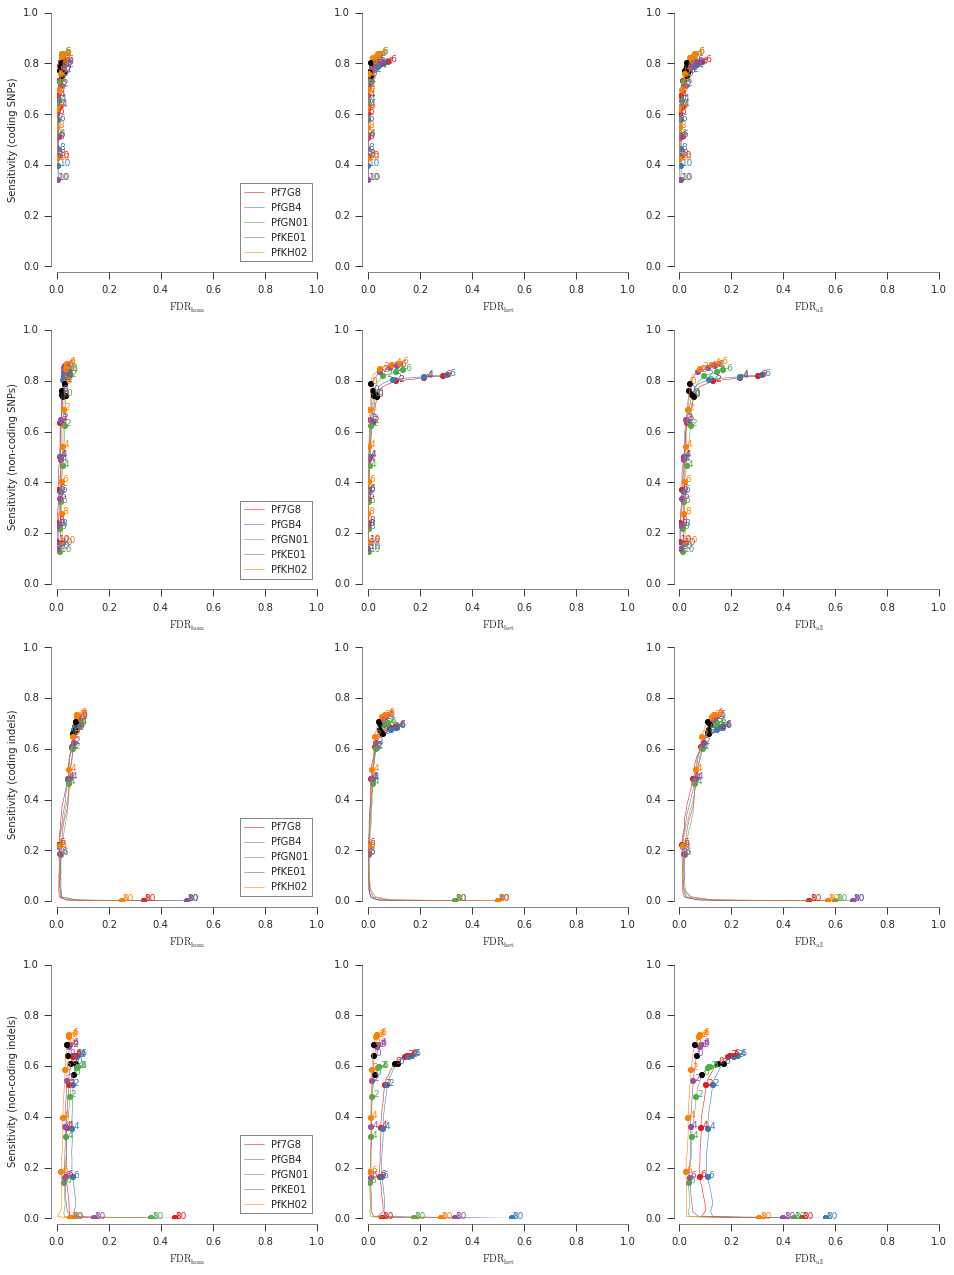

In [124]:
#  GQ ROC (FDR vs sensitivity) for coding/variant_type/FPtype (12 lines) across all samples
fig = plt.figure(figsize=(12, 16))
gs = mpl.gridspec.GridSpec(4, 3)

FDR = collections.OrderedDict()
sensitivity = collections.OrderedDict()
for ii, variant_type in enumerate([b'SNP', b'IND']):
    FDR[variant_type] = collections.OrderedDict()
    sensitivity[variant_type] = collections.OrderedDict()
    for j, coding in enumerate([True, False]):
        FDR[variant_type][coding] = collections.OrderedDict()
        sensitivity[variant_type][coding] = collections.OrderedDict()
        row_num = (ii*2) + j
        ax = collections.OrderedDict()
        ax['FPhom'] = fig.add_subplot(gs[row_num, 0])
        ax['FPhet'] = fig.add_subplot(gs[row_num, 1])
        ax['FPall'] = fig.add_subplot(gs[row_num, 2])
        for sample in pacbio_samples:
            FDR[variant_type][coding][sample] = collections.OrderedDict()
            for FP_type in ax:
                FDR[variant_type][coding][sample][FP_type] = np.zeros(81, dtype=float)
            sensitivity[variant_type][coding][sample] = np.zeros(81, dtype=float)
            for i, VQSLOD_threshold in enumerate(np.arange(-6.0, 10.1, 0.2)):
                status_sum = VQSLOD_dict[VQSLOD_threshold][sample].groupby(level=['VARIANT_TYPE', 'CDS', 'status']).sum()
                if 'FPhom' in status_sum[variant_type][coding].keys():
                    FPhom = status_sum[variant_type][coding]['FPhom']
                if 'FPhet' in status_sum[variant_type][coding].keys():
                    FPhet = status_sum[variant_type][coding]['FPhet']
                FPall = FPhom + FPhet
                if 'TPhom' in status_sum[variant_type][coding].keys():
                    TP = status_sum[variant_type][coding]['TPhom']
                if 'FN' in status_sum[variant_type][coding].keys():
                    FN = status_sum[variant_type][coding]['FN']
                FDR[variant_type][coding][sample]['FPhom'][i] = FPhom/(TP+FPhom)
                FDR[variant_type][coding][sample]['FPhet'][i] = FPhet/(TP+FPhet)
                FDR[variant_type][coding][sample]['FPall'][i] = FPall/(TP+FPall)
                sensitivity[variant_type][coding][sample][i] = TP/(TP+FN)
            colour = sample_colours[sample]
            if coding == True and variant_type == b'SNP':
                label = "Sensitivity (coding SNPs)" 
            if coding == False and variant_type == b'SNP':
                label = "Sensitivity (non-coding SNPs)" 
            if coding == True and variant_type == b'IND':
                label = "Sensitivity (coding indels)" 
            if coding == False and variant_type == b'IND':
                label = "Sensitivity (non-coding indels)"
            for FP_type in ax:
                ax[FP_type].plot(
                    FDR[variant_type][coding][sample][FP_type],
                    sensitivity[variant_type][coding][sample],
                    color=colour,
                    label=sample
                )
                for i, VQSLOD in enumerate(np.arange(-6.0, 11.0, 2.0)):
                    if VQSLOD == 0.0:
                        ax[FP_type].plot(
                            FDR[variant_type][coding][sample][FP_type][i*10],
                            sensitivity[variant_type][coding][sample][i*10],
                            'o',
                            color="black"
                        )
                    else:
                        ax[FP_type].plot(
                            FDR[variant_type][coding][sample][FP_type][i*10],
                            sensitivity[variant_type][coding][sample][i*10],
                            'o',
                            color=colour)
                    ax[FP_type].text(
                        FDR[variant_type][coding][sample][FP_type][i*10]+text_offset,
                        sensitivity[variant_type][coding][sample][i*10],
                        int(VQSLOD),
                        fontsize=8,
                        color=colour
                    )
                sns.despine(ax=ax[FP_type], offset=5)
                ax[FP_type].set_xlim(0, 1)
                ax[FP_type].set_ylim(0, 1)
            ax['FPhom'].set_xlabel(r'$\mathrm{FDR_{hom}}$')
            ax['FPhet'].set_xlabel(r'$\mathrm{FDR_{het}}$')
            ax['FPall'].set_xlabel(r'$\mathrm{FDR_{all}}$')
            ax['FPhom'].set_ylabel(label)
            ax['FPhom'].legend(loc='lower right')

fig.tight_layout()


In [594]:
temp = fdr_results_dict['VQSLOD'][-10.0]['Pf7G8']
temp_index = temp.index
for i, name in enumerate(temp_index.names):
    print(i, temp_index.names[i], type(temp_index.levels[i][0]))
    if isinstance(temp_index.levels[i][0], bytes):
        temp_index.set_levels([x.decode('ascii') for x in temp_index.levels[i]], level=i, inplace=True)

# temp_index_levels = [temp.index.levels
# temp_index_levels
temp_index

0 VARIANT_TYPE <class 'str'>
1 CDS <class 'bool'>
2 MULTIALLELIC_x <class 'bytes'>
3 status <class 'str'>


MultiIndex(levels=[['IND', 'SNP'], [False, True], ['BI', 'MIS', 'MU', 'SD'], ['!!!FN', '!!!FP', '!FPHR', '!TPHR', 'FN', 'FPhet', 'FPhom', 'TPhet', 'TPhom']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,

In [552]:
variant_type_levels = ['status', 'VARIANT_TYPE']
variant_type_levels = ['status']
temp = pd.DataFrame(fdr_results_dict['VQSLOD'][-10.0]['Pf7G8'].groupby(level=variant_type_levels).sum())
temp['test'] = True
temp.set_index('test', append=True, inplace=True)
temp = temp.ix[:, 0]
temp['FN']
# pd.Series(temp['0'])
# temp = pd.Series(temp['test'])
# temp['FN']

test
True    17009
Name: 0, dtype: int64